In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, auc, roc_auc_score, roc_curve, f1_score, classification_report, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder

import xgboost as xgb

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import shakespeare

from keras.preprocessing.text import Tokenizer

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from IPython.display import display, HTML

import copy
import glob
import time
import os
import re
import gc
from tqdm import tqdm
import warnings

print(os.listdir("../input"))
stop_words = stopwords.words('english')
hamlet = ' '.join(shakespeare.words('hamlet.xml'))
macbeth = ' '.join(shakespeare.words('macbeth.xml'))
grids = {}
entropies = {}

string_size = 0.20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
pd.set_option('display.max_columns',8)
pd.set_option('precision',3)
%matplotlib inline

Using TensorFlow backend.


['glove6b300dtxt', 'glove6b50dtxt', 'spamham2', 'glove6b200d', 'glove6b100dtxt']


We are listing all the datasets we have and their location in `../input` directory.

In [2]:
%ls ../input/glove6b50dtxt
%ls ../input/glove6b100dtxt
%ls ../input/glove6b200d
%ls ../input/glove6b300dtxt
%ls ../input/spamham2/spam-ham/spam-ham

glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
test_CSDMC2010_SPAM/  test_PU1/              train_ENRON/      train_trec07p/
test_ENRON/           test_trec07p/          train_Ling-Spam/
test_Ling-Spam/       train_CSDMC2010_SPAM/  train_PU1/


In [3]:
datasets = [ ('train_ENRON','test_ENRON'), ('train_PU1', 'test_PU1'), ('train_Ling-Spam', 'test_Ling-Spam'),\
            ('train_CSDMC2010_SPAM', 'test_CSDMC2010_SPAM'),('train_trec07p','test_trec07p')]

Below we are listing down number of spam and ham mails available for each dataset.

In [4]:
root_dir = '../input/spamham2/spam-ham/spam-ham'
for train_test in datasets:
    train_path = os.path.join(root_dir,train_test[0])
    test_path = os.path.join(root_dir,train_test[1])
    print(train_path,test_path)
    if len(train_test) == 2:
        if 'ENRON' in train_test[0]:
            print('Train Ham (%s) :'%train_test[0],len(glob.glob('%s/*/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0],len(glob.glob('%s/*/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/*/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/*/s/*'%test_path)))
        else:
            print('Train Ham (%s) :'%train_test[0], len(glob.glob('%s/h/*'%train_path)))
            print('Train Spam (%s) :'%train_test[0], len(glob.glob('%s/s/*'%train_path)))
            print('Test Ham (%s) :'%train_test[1], len(glob.glob('%s/h/*'%test_path)))
            print('Test Spam (%s) :'%train_test[1], len(glob.glob('%s/s/*'%test_path)))

../input/spamham2/spam-ham/spam-ham/train_ENRON ../input/spamham2/spam-ham/spam-ham/test_ENRON
Train Ham (train_ENRON) : 11627
Train Spam (train_ENRON) : 11970
Test Ham (test_ENRON) : 4918
Test Spam (test_ENRON) : 5201
../input/spamham2/spam-ham/spam-ham/train_PU1 ../input/spamham2/spam-ham/spam-ham/test_PU1
Train Ham (train_PU1) : 424
Train Spam (train_PU1) : 342
Test Ham (test_PU1) : 194
Test Spam (test_PU1) : 139
../input/spamham2/spam-ham/spam-ham/train_Ling-Spam ../input/spamham2/spam-ham/spam-ham/test_Ling-Spam
Train Ham (train_Ling-Spam) : 1727
Train Spam (train_Ling-Spam) : 342
Test Ham (test_Ling-Spam) : 685
Test Spam (test_Ling-Spam) : 139
../input/spamham2/spam-ham/spam-ham/train_CSDMC2010_SPAM ../input/spamham2/spam-ham/spam-ham/test_CSDMC2010_SPAM
Train Ham (train_CSDMC2010_SPAM) : 2086
Train Spam (train_CSDMC2010_SPAM) : 966
Test Ham (test_CSDMC2010_SPAM) : 863
Test Spam (test_CSDMC2010_SPAM) : 412
../input/spamham2/spam-ham/spam-ham/train_trec07p ../input/spamham2/spam-h

### Gathering train and test file names
Below method takes as input train and test path where `spam` and `ham` mails are stored in folder named `s` and `h` respectively.

In [5]:
def gather_train_test_file_names(train_root, test_root):
    if 'ENRON' in train_root and 'ENRON' in test_root:
        train_spam_x = glob.glob('%s/*/s/*'%train_root)
        train_ham_x = glob.glob('%s/*/h/*'%train_root)
        
        test_spam_x = glob.glob('%s/*/s/*'%test_root)
        test_ham_x = glob.glob('%s/*/h/*'%test_root)
    else:
        train_spam_x = glob.glob('%s/s/*'%train_root)
        train_ham_x = glob.glob('%s/h/*'%train_root)

        test_spam_x = glob.glob('%s/s/*'%test_root)
        test_ham_x = glob.glob('%s/h/*'%test_root)
    
    train_x = train_spam_x + train_ham_x

    y_train_ham = np.zeros(len(train_ham_x))
    y_train_spam = np.ones(len(train_spam_x))
    y_train = np.concatenate((y_train_spam,y_train_ham))
    
    test_x = test_spam_x+test_ham_x

    y_test_spam = np.ones(len(test_spam_x))
    y_test_ham = np.zeros(len(test_ham_x))
    y_test = np.concatenate((y_test_spam,y_test_ham))
    
    del train_spam_x,train_ham_x, test_spam_x,test_ham_x, y_train_ham, y_train_spam, y_test_spam, y_test_ham

    gc.enable();gc.collect();
    
    return train_x, test_x, y_train, y_test

### Clean Data
Below method takes as input all list of file names and performs below mentioned steps
1. Loops through each file
2. Tokenize file contents ignoring unwanted characters using `ISO-8859-1` encoding
3. Remove stop words which are commonly occuring words in sentence and does not contribute much to classification.
4. Reconstruct text contents after all above steps properly cleans data.

In [6]:
def clean_data(x_total):
    x_all = np.empty_like(x_total)
    regex = re.compile(r'[a-z]+')
    for i, file_name in enumerate(x_total):
        with open(file_name, encoding='ISO-8859-1') as f:
            #print(file_name)
            #print(f.read())
            words = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in  word_tokenize(f.read().lower())] # .decode(errors='replace')
            words = [regex.match(word).string for word in words if regex.match(word)]
            words = [word for word in words if regex.match(word) if word not in stop_words]
            x_all[i] = ' '.join(words)
    
    print('Check whether lenth is same as original data : ',len(x_all) == len(x_total))

    return x_all

### Load Embeddings from Glove Dataset.
We are using glove embeddings ([Wikipedia Embeddings](https://nlp.stanford.edu/projects/glove/)) for our classification purpose. We are loading glove files and maintaining embeddings dictionary which keeps mapping from words to embedding vector of length 100.

In [7]:
def load_embeddings(embedding_file):
    embeddings_index = {}
    #f = open('pretrained_word_embeddings/glove.6B.300d.txt',encoding="utf8")
    f = open(embedding_file,encoding="utf8")
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

### Converting texts to Embedding vectors
Below method takes as input contents of mails. For each word in mail it tried to find embedding from embedding dictionary and then normalizes vectors of each words to create one vector which represents contents of that mail text.

In [8]:
def text2vec(s,size):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return list(np.zeros(size))
    return list(v / np.sqrt((v ** 2).sum()))

### Grid Search Params
Below method takes as input grid pipeline which consists of preprocessing steps & model, params of pipeline steps, train data, test data and then performs grid search on all params provided. After performing grid search it keeps track of best performing model and its params.

It also prints best train accuracy, test accuracy and params which gave good results.

In [9]:
def grid_search_through_params(model_name,pipeline, params,X, Y, X_test, Y_test):
    grid = GridSearchCV(pipeline, param_grid=params, scoring=['neg_log_loss', 'accuracy', 'roc_auc'], refit='accuracy', cv=3, n_jobs=-1, verbose=2)
    grid.fit(X, Y)

    #print('Train Accuracy : ',grid.score(X_train_subjects, Y_train_subjects))
    #print('Validation Accuracy : ',grid.score(X_test_subjects, Y_test_subjects))
    print('Best Score : ',grid.best_score_)
    print('Test Accuracy : ',grid.score(X_test, Y_test))
    print('Best Params : ',grid.best_params_)
    
    return grid

### Trying various models to find best performing one
Belo method takes as input train data, test data and types of preprocessing to be performed. It then tries various models like LogisticRegression, SVC, NaiveBayes and Extremem Gradient Boosting. It grid searches through each of models and tries to find best params. It also tries various preprocessing steps like Term Frequency-Inverse Document Frequency, Count Vectorizer and Embedding preprocessing steps with these models as preprocessing steps before performing actual parameter fitting.

In [10]:
def try_various_models_on_data(dataset_name, train_x_cleaned, y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer'):
    params_lr = {
             'logisticregression__C': [1.0, 10,100],'logisticregression__penalty': ['l1', 'l2'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_svc = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 0.1, 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_xgb = {
             'xgbclassifier__n_estimators': [100,200,500,1000], 'xgbclassifier__max_depth': [3,4,5,], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    params_nb = {
            'multinomialnb__alpha' : [0.1,0.5,1.0,]
    }
    params_rf = {
             'randomforestclassifier__n_estimators': [100,200,500], 'randomforestclassifier__max_depth': [3,5,None], #'xgbclassifier__learning_rate': [0.01, 0.1],
             #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
    if preprocessing == 'tfidfvectorizer':
        params_lr.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(TfidfVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'countvectorizer':
        params_lr.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_svc.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_xgb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_nb.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        params_rf.update({'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
                         })
        pipeline_lr = make_pipeline(CountVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(CountVectorizer(), SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(CountVectorizer(), xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(CountVectorizer(), MultinomialNB())
        pipeline_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state=123))
    elif preprocessing == 'Embedding':
        pipeline_lr = make_pipeline(LogisticRegression(random_state=123, n_jobs=-1))
        pipeline_svc = make_pipeline(SVC(probability=True, random_state=123))
        pipeline_xgb = make_pipeline(xgb.XGBClassifier(random_state=123, seed=123, n_jobs=-1))
        pipeline_nb = make_pipeline(MultinomialNB())
        pipeline_rf = make_pipeline(RandomForestClassifier(random_state=123))
    grids['LogisticRegression_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('LogisticRegression', pipeline_lr, params_lr, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['SVC_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('SVC', pipeline_svc, params_svc, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['XGBoost_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('XGBoost', pipeline_xgb, params_xgb, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    grids['RandomForest_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('RandomForest', pipeline_rf, params_rf, train_x_cleaned, y_train, test_x_cleaned, y_test)
    print()
    if preprocessing != 'Embedding':
        grids['NaiveBayes_'+preprocessing+'_'+dataset_name]  = grid_search_through_params('NaiveBayes', pipeline_nb, params_nb, train_x_cleaned, y_train, test_x_cleaned, y_test)

### Simple Dense Neural Network
Below is simple dense neural network of only linear layers.

In [11]:
def get_dense_model(num_max):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
    print('compile done')
    return model


### CNN Version 1
CNN model with embedding of size 50 and Convolution layer of size (64,3).

In [12]:
def get_cnn_model_v1(max_len): # added embed   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        50, #!!!!!!!!!!!!!!!!!!!!!!!
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(128,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

### CNN Version 2
CNN with embedding of size 20 and Convolution of size (256,3)

In [13]:
def get_cnn_model_v2(max_len):    # added filter
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        50,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, #!!!!!!!!!!!!!!!!!!!
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

### Adding Shakshpere Macbeth Strings to test data
Below method adds text from macbeth which is 20% length of original mail text data to test data. Below exercise is performed to check whether we are able to confuse classifier by adding good text to it.

In [14]:
def add_meaningfull_strings(test_x, proportion=0.2):
    return np.array([x+' '+macbeth[:int(len(x)*proportion)] for x in test_x])

def add_meaningfull_strings_scrambled(test_x, proportion=0.2):
    import random
    test_x_2 = np.empty_like(test_x, dtype=np.str)
    for i, x in enumerate(test_x):
        temp = macbeth[:int(len(x)*proportion)]
        split_words = temp.split(' ')
        random.shuffle(split_words)
        temp = ' '.join(split_words)
        test_x_2[i] = x+' '+temp
    return test_x_2

### Calculate Entropies
Below method takes as input best performing model and test data. It generates shannon entropies, relative entropies, log losses for each of test sample and returns it.

In [15]:
def calculate_entropies(model_name, model, test_x, y_test):
    if 'DNN' in model_name or 'CNN' in model_name:
        y_test_preds = np.hstack((1- model.predict_proba(test_x), model.predict_proba(test_x)))
    else:
        y_test_preds = model.predict_proba(test_x)
    #print(y_test_preds)
    one_hot = sklearn.preprocessing.OneHotEncoder()
    one_hot_encoded = one_hot.fit_transform(y_test.reshape(-1,1))
    y_test_one_hot_encoded = one_hot_encoded.toarray()

    shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized = [],[],[],[]
    for y_true, y_pred in zip(y_test_one_hot_encoded,y_test_preds):
        #print(entropy(y_pred))
        shannon_entropies.append(entropy(y_pred))
        relative_entropies.append(entropy(y_true, y_pred))
        log_losses_unnormalized.append(log_loss(y_true,y_pred,normalize=False))
        log_losses_normalized.append(log_loss(y_true,y_pred))
        
    return np.clip(np.array(shannon_entropies),0.0,6.0), np.clip(np.array(relative_entropies),0.0,6.0), np.array(log_losses_unnormalized), np.array(log_losses_normalized), y_test_preds

### Dataframe creation function for Entropies and other details
Below method takes as input various entropies and other details related to prediction and creates dataframe from it which we'll use later for display purpose.

In [16]:
def create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized):
    #print(shannon_entropies.shape, relative_entropies.shape, test_x.shape, y_test.shape, y_test_preds.shape, log_losses_unnormalized.shape, log_losses_normalized.shape)
    return pd.DataFrame(data={'Shannon':shannon_entropies,'Relative':relative_entropies,
                                      'Y True':y_test, 'Y Pred': model.predict_classes(test_x).flatten() if ('CNN' in model_name) or ('DNN' in model_name) else model.predict(test_x),
                                      'Y Preds(0)': y_test_preds[:,0],'Y Preds(1)': y_test_preds[:,1],
                                     'Log Loss(Unnormalized)':log_losses_unnormalized,
                                     'Log Loss(Normalized)':log_losses_normalized})

### Plot Entropy Histogram
Below method takes as input entropies and test data. It then prints histogram represeting spam and ham mails entropies.

In [17]:
def draw_entropy_histogram(model_name, entropies, y_test, entropy_type, before_after='Before'):
    plt.figure(figsize=(18,6))
    plt.hist(entropies[y_test == 1.0],bins=50, rwidth=0.6, linewidth=1.2, color='red', label='Spam',edgecolor='black')
    plt.hist(entropies[y_test == 0.0],bins=50, rwidth=0.6, linewidth=1.2, color='green', label='Ham',edgecolor='black')
    plt.xlabel(entropy_type)
    plt.ylabel('Frequency')
    plt.title('%s : %s (%s adding Random Strings), Mean : %.3f'%(model_name, entropy_type, before_after,entropies.mean()))
    plt.legend(loc='best')

### Plot Confusion Matrix
Below method takes as input best performing model and test data as input. It then generates confusion matrix and plots it.

In [18]:
def draw_confusion_matrix(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        conf_mat = confusion_matrix(y_test, model.predict_classes(test_x).flatten())
    else:
        conf_mat = confusion_matrix(y_test, model.predict(test_x))
    
    plt.figure(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Plot ROC AUC Curve

Below method takes as input best performing model and test data. It then generates ROC AUC curve based on True Positives and False Positives.

In [19]:
def draw_roc_auc_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_preds_proba)
    r_auc = roc_auc_score(y_test, y_preds_proba)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, r_auc), linewidth=3)
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    plt.title('%s : ROC AUC Curve'%model_name)
    plt.legend(loc="best")
    plt.show()

### Plot Precision Recall Curve
Below method takes as input best performing model and test data. It then draws precision recall curve.

In [20]:
def draw_precision_recall_curve(model_name, model, test_x, y_test):
    if 'CNN' in model_name or 'DNN' in model_name:
        y_preds = model.predict_classes(test_x).flatten()
        y_preds_proba = model.predict_proba(test_x).flatten()
    else:
        y_preds = model.predict(test_x)
        y_preds_proba = model.predict_proba(test_x)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_preds_proba)
    p_auc = auc(recall, precision)
    acc = accuracy_score(y_test, y_preds)
 
    plt.figure(figsize=(12,12))
    plt.plot(recall, precision, label="acc:%.2f auc:%.2f" % (acc, p_auc), linewidth=3)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="best")
    plt.title('%s : Precision Recall Curve'%model_name)
    plt.show()

### Visualising Entropies generated by various models
Below method takes as input test data and dataset name. It then loops through each model for that particular dataset and prints average of entropies, entropies for wrong predictions and plots entropies as well.

In [21]:
def visualise_entropies(dataset_name, test_x_cleaned, y_test,before_after='Before'):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            shannon_entropies,relative_entropies,log_losses_unnormalized,log_losses_normalized,y_test_preds = calculate_entropies(model_name, model, test_x_cleaned, y_test)
            #print(shannon_entropies.shape,relative_entropies.shape,log_losses_unnormalized.shape,log_losses_normalized.shape,y_test_preds.shape)
            print('Mean Shannon Entropy : ',shannon_entropies.mean())
            print('Mean Relative Entropy : ', relative_entropies.mean())

            entropies = create_summary_dataframe(model_name, model, shannon_entropies, relative_entropies, test_x_cleaned, y_test, y_test_preds, log_losses_unnormalized, log_losses_normalized)
            print('Head 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].head())
            print('Tail 5 : ')
            print(entropies[entropies['Y True'] != entropies['Y Pred']][['Shannon','Relative','Y True','Y Pred', 'Y Preds(0)','Y Preds(1)']].tail())
            draw_entropy_histogram(model_name, shannon_entropies, y_test,'Shannon Entropy',before_after)
            draw_entropy_histogram(model_name, relative_entropies, y_test,'Relative Entropy',before_after)
            #entropies[model_name+'_'+before_after] = copy.deepcopy(entropies)

### Calculate Various Evaluation Metrics
Below methods takes as input test data and then prints log loss, roc auc, accuracy and classification report(f1 score, precision, recall).

In [22]:
def calculate_evaluation_metrics_and_display_metrics(dataset_name, test_x_cleaned, y_test):
    for model_name, model in grids.items():
        if dataset_name in model_name:
            print('*'*80)
            print(model_name)
            print('*'*80)
            if 'CNN' in model_name or 'DNN' in model_name:
                y_preds = model.predict_classes(test_x_cleaned).flatten()
            else:
                y_preds = model.predict(test_x_cleaned)
            print('Log Loss : ',log_loss(y_test, y_preds))
            if 'CNN' in model_name or 'DNN' in model_name:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned).flatten()))
            else:
                print('ROC AUC : ',roc_auc_score(y_test, model.predict_proba(test_x_cleaned)[:,1]))
            print('Accuracy : ',accuracy_score(y_test, y_preds))
            print('Classification Report : ')
            print(classification_report(y_test, y_preds))
            draw_confusion_matrix(model_name, model, test_x_cleaned, y_test)
            draw_roc_auc_curve(model_name, model, test_x_cleaned, y_test)
            draw_precision_recall_curve(model_name, model, test_x_cleaned, y_test)

In [23]:
def visualize_coefficients(classifier, feature_names, n_top_features=30):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(18, 6))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2*n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2*n_top_features), feature_names[interesting_coefficients],rotation=70, ha="right")
    plt.tight_layout(pad=0, h_pad=0, w_pad=0);

### Loading Embeddings

In [24]:
embeddings_index = load_embeddings('../input/glove6b300dtxt/glove.6B.300d.txt')
embedding_size = 300

400000it [00:36, 10975.78it/s]

Found 400000 word vectors.


## CSDMC2010 Dataset

## Loading and Cleaning Data

In [25]:
%%time
dataset = 'CSDMC2010'

csdmc_train_root = os.path.join(root_dir, 'train_CSDMC2010_SPAM')
csdmc_test_root = os.path.join(root_dir, 'test_CSDMC2010_SPAM')

train_x, test_x, y_train, y_test = gather_train_test_file_names(csdmc_train_root, csdmc_test_root)    

print('Train : ',len(train_x),len(y_train))
print('Test : ',len(test_x),len(y_test))

train_x_cleaned = clean_data(train_x)
test_x_cleaned = clean_data(test_x)

#train_x_cleaned[0], train_x_cleaned[0].split()
gc.enable(); gc.collect();

Train :  3052 3052
Test :  1275 1275
Check whether lenth is same as original data :  True
Check whether lenth is same as original data :  True
CPU times: user 1min 10s, sys: 552 ms, total: 1min 11s
Wall time: 1min 22s


## 1. CountVecotrizer Approach

## Trying various models and keeping track of best performing params

In [26]:
%%time
grids = {}
entropies = {}
try_various_models_on_data(dataset, train_x_cleaned,y_train, test_x_cleaned, y_test, preprocessing='countvectorizer')
gc.enable(); gc.collect();

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   19.3s finished


Best Score :  0.9770642201834863
Test Accuracy :  0.9827450980392157
Best Params :  {'countvectorizer__ngram_range': (1, 3), 'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.7min finished


Best Score :  0.97870249017038
Test Accuracy :  0.9819607843137255
Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 10, 'svc__gamma': 0.1}

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  9.8min finished


Best Score :  0.9701834862385321
Test Accuracy :  0.9725490196078431
Best Params :  {'countvectorizer__ngram_range': (1, 2), 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 500}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.4min finished


Best Score :  0.9757536041939712
Test Accuracy :  0.9788235294117648
Best Params :  {'countvectorizer__ngram_range': (1, 2), 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.9s finished


Best Score :  0.9705111402359109
Test Accuracy :  0.9647058823529412
Best Params :  {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 0.1}
CPU times: user 15.6 s, sys: 576 ms, total: 16.1 s
Wall time: 14min 38s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_countvectorizer_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.044690913205870854
Mean Relative Entropy :  0.06191593028464134
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
74     0.458     1.763     1.0     0.0       0.828       0.172
97     0.473     1.710     1.0     0.0       0.819       0.181
137    0.160     3.287     1.0     0.0       0.963       0.037
144    0.241     2.733     1.0     0.0       0.935       0.065
151    0.475     1.703     1.0     0.0       0.818       0.182
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
585     0.584     1.308     0.0     1.0       0.270       0.730
613     0.012     6.000     0.0     1.0       0.002       0.998
1063    0.321     2.322     0.0     1.0       0.098       0.902
1078    0.369     2.113     0.0     1.0       0.1

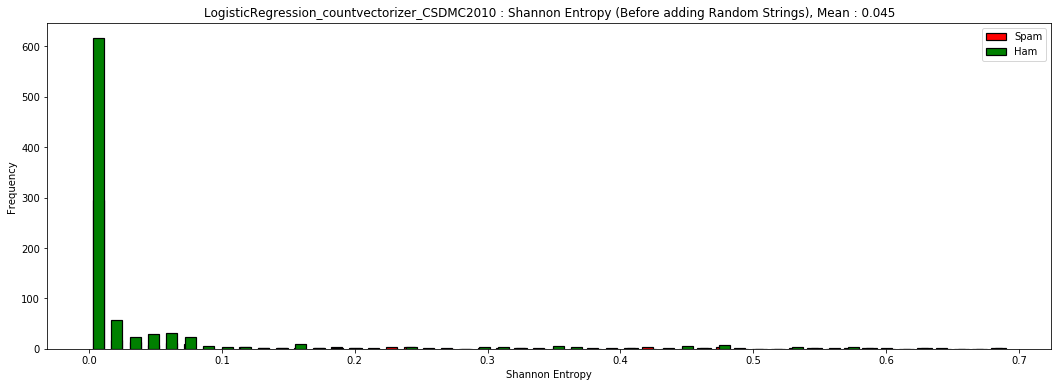

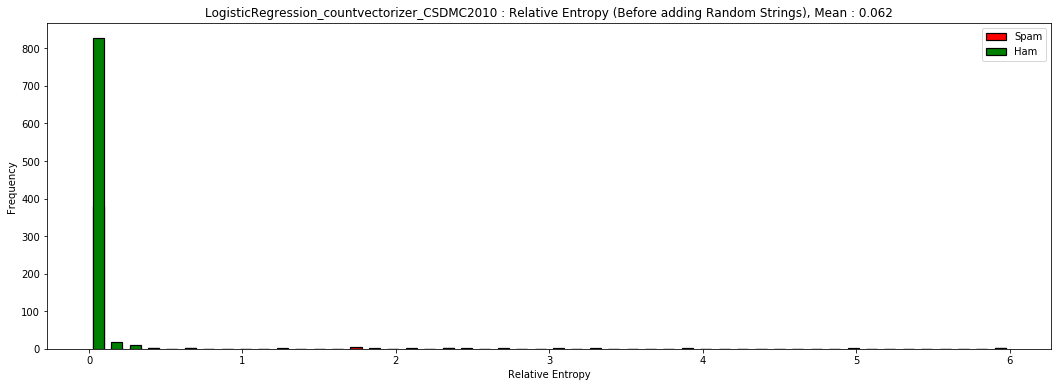

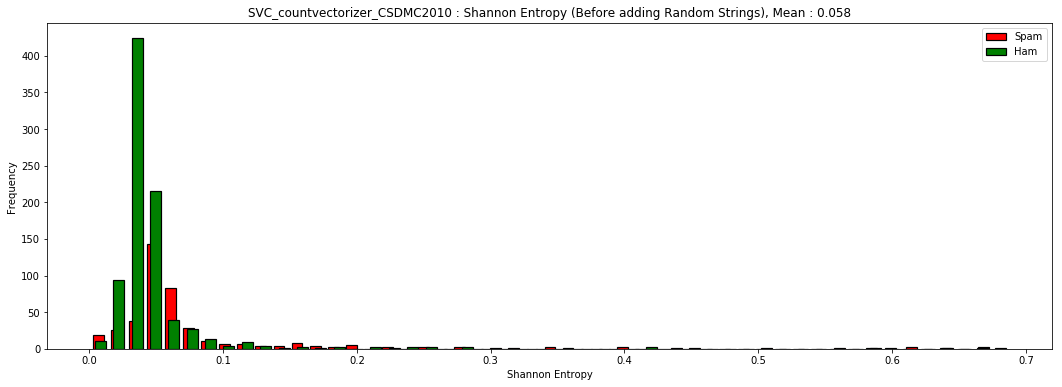

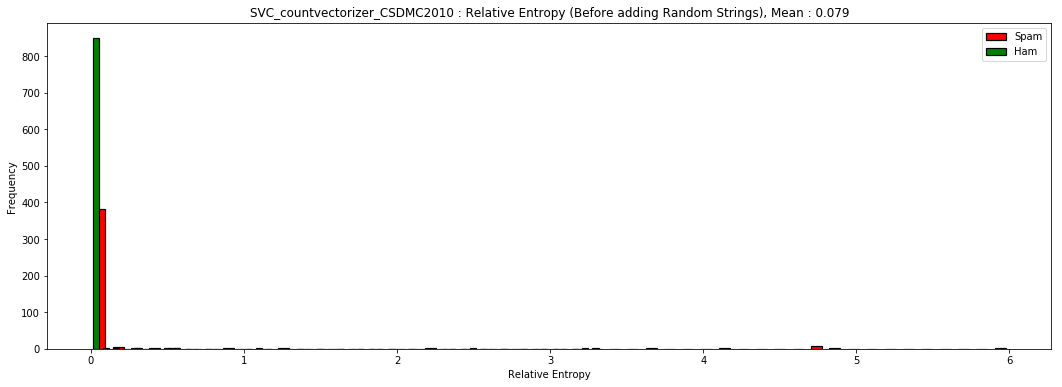

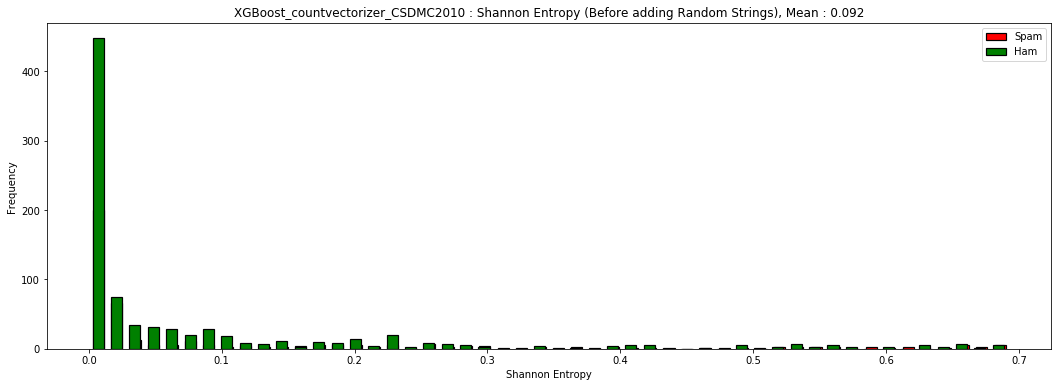

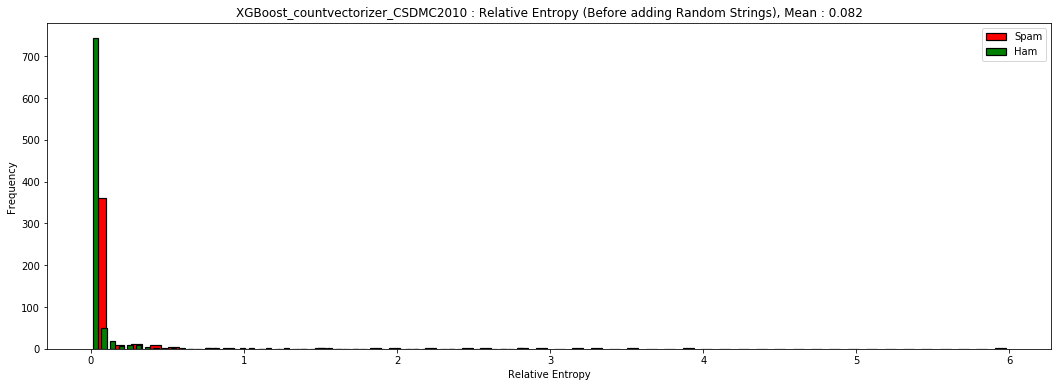

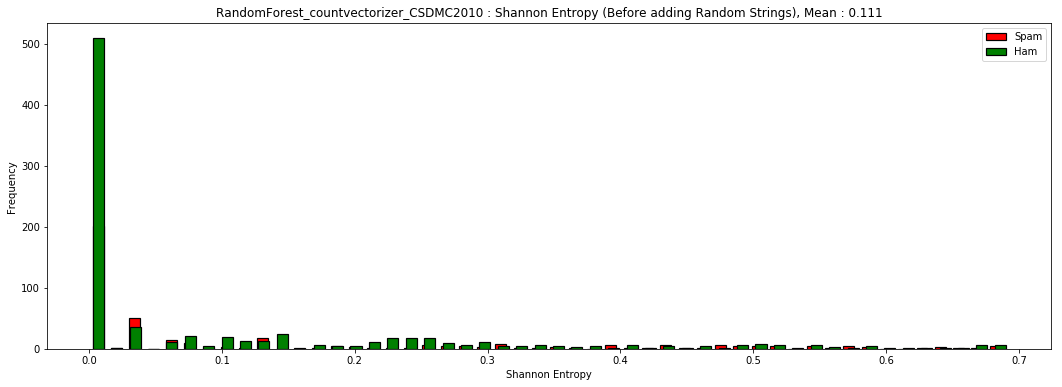

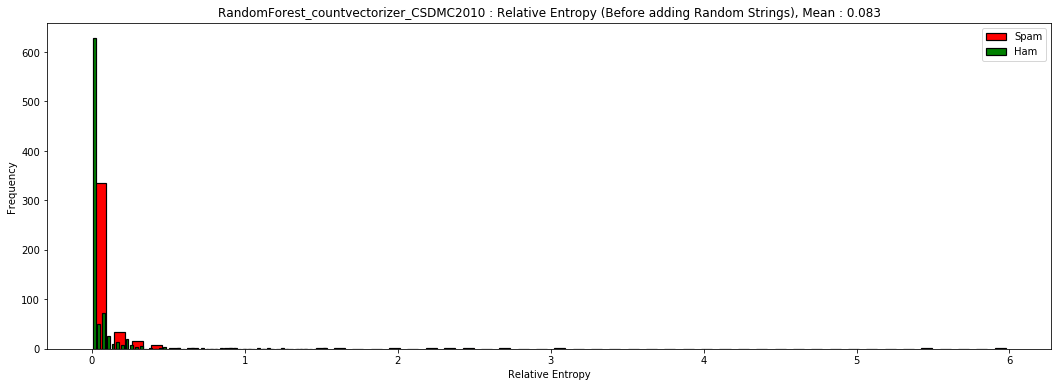

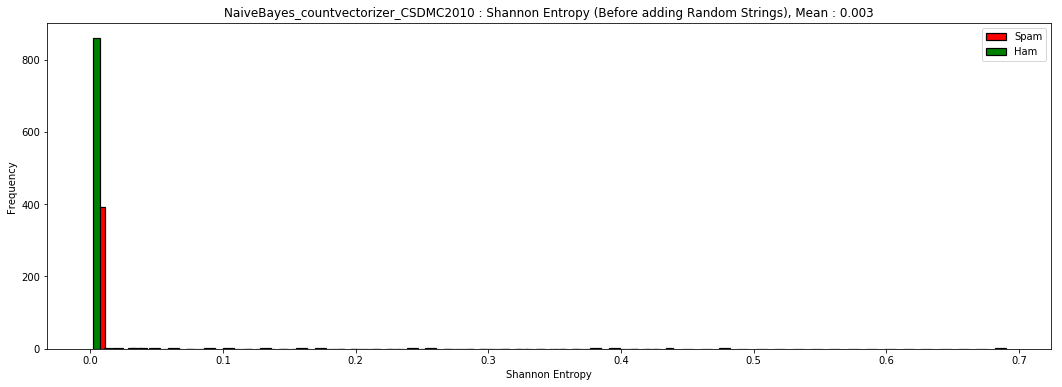

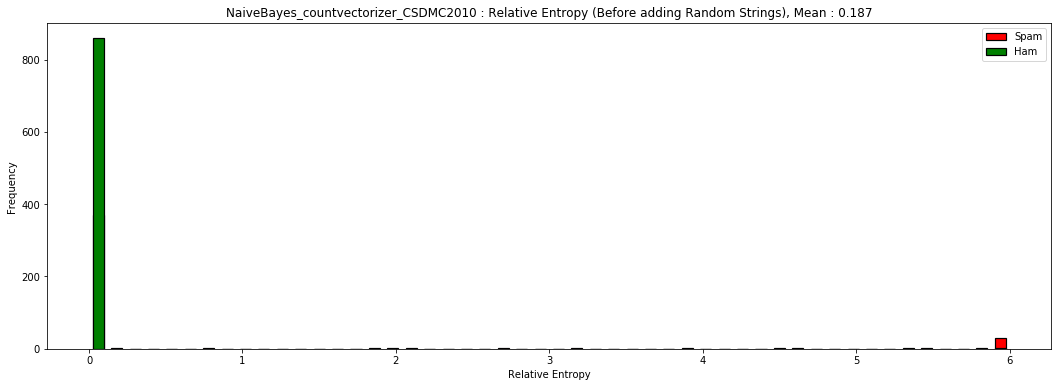

In [27]:
visualise_entropies(dataset, test_x_cleaned, y_test, 'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.5959669633510724
ROC AUC :  0.9960090674886656
Accuracy :  0.9827450980392157
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       863
         1.0       0.99      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.98      0.98      1275
weighted avg       0.98      0.98      0.98      1275



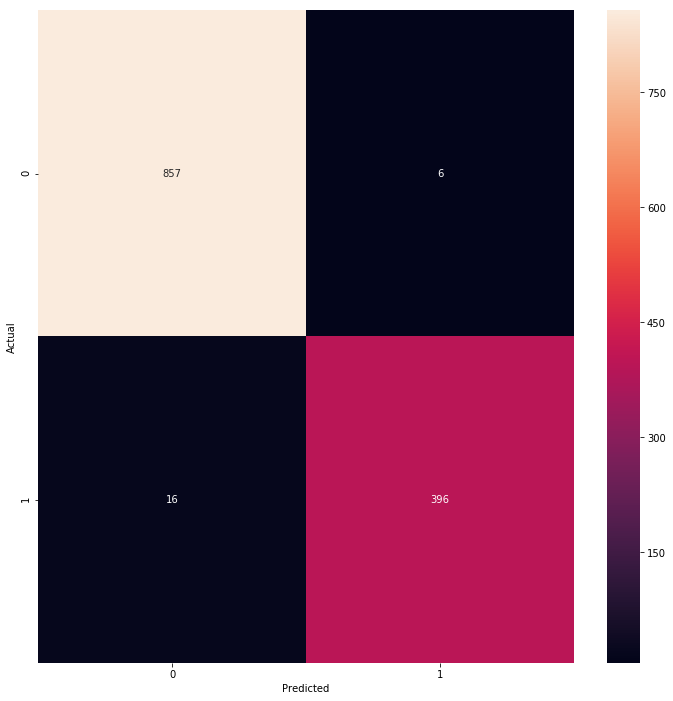

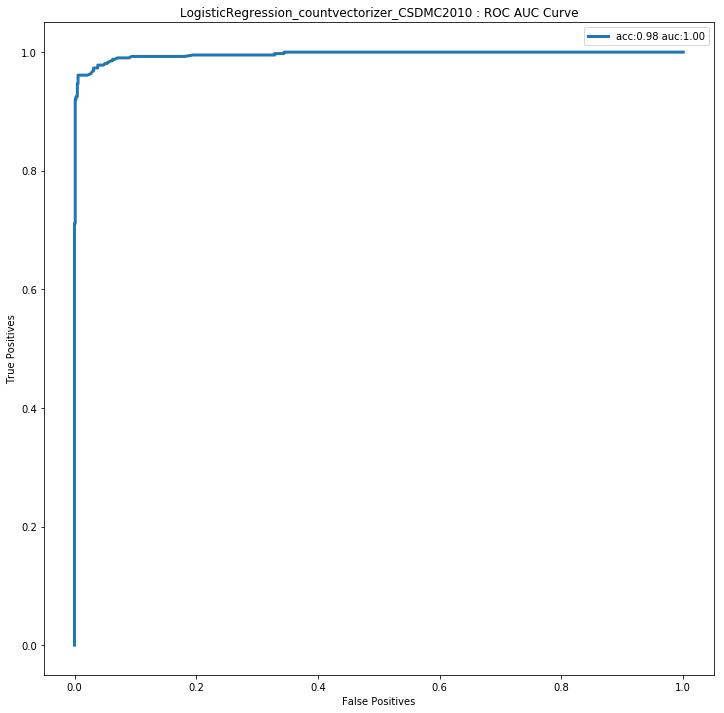

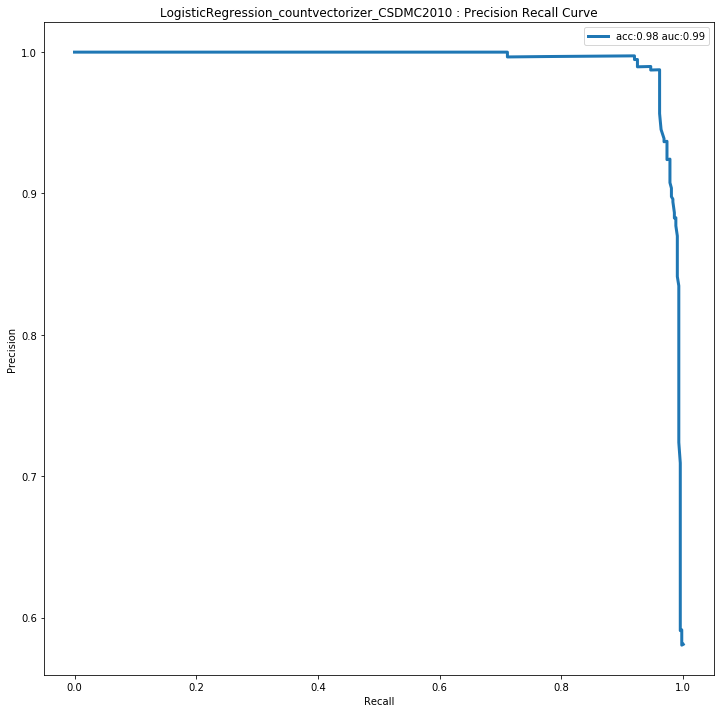

********************************************************************************
SVC_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.6230555726039982
ROC AUC :  0.9899931375085782
Accuracy :  0.9819607843137255
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       863
         1.0       0.99      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.98      0.98      1275
weighted avg       0.98      0.98      0.98      1275



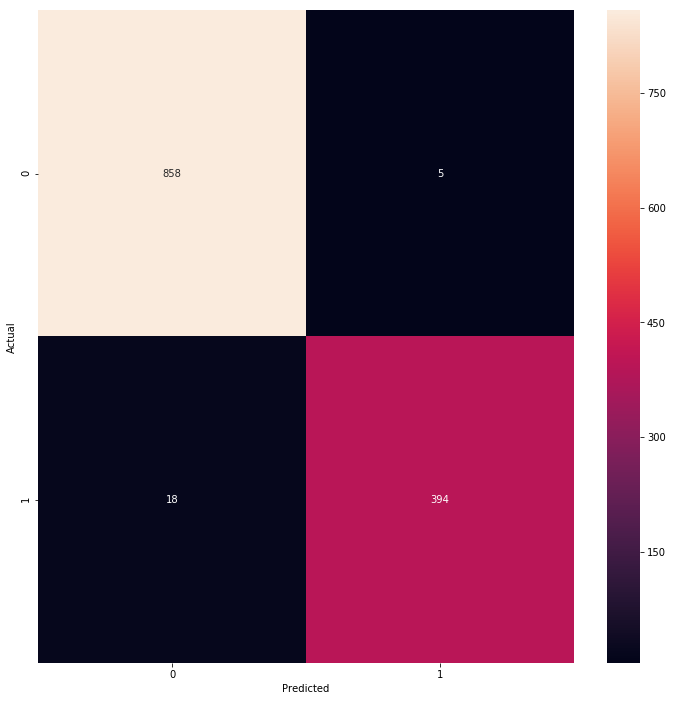

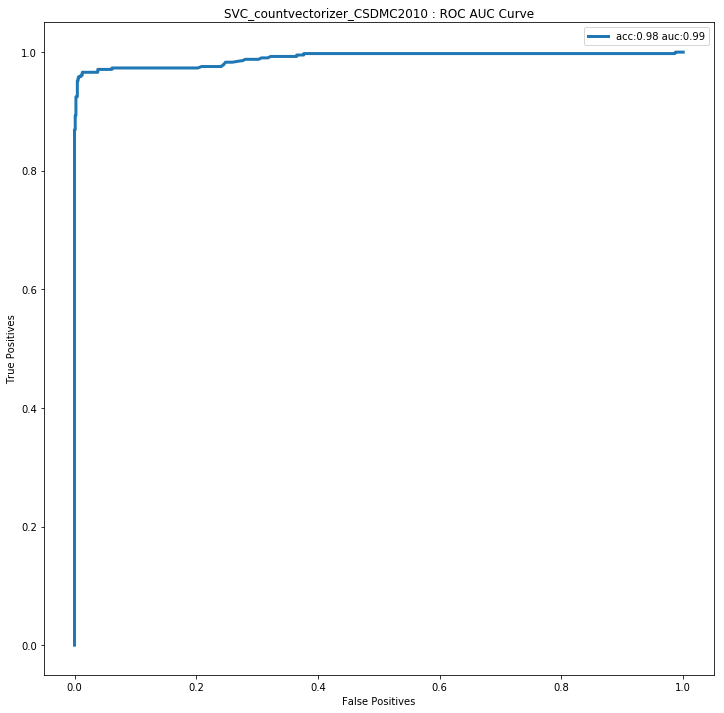

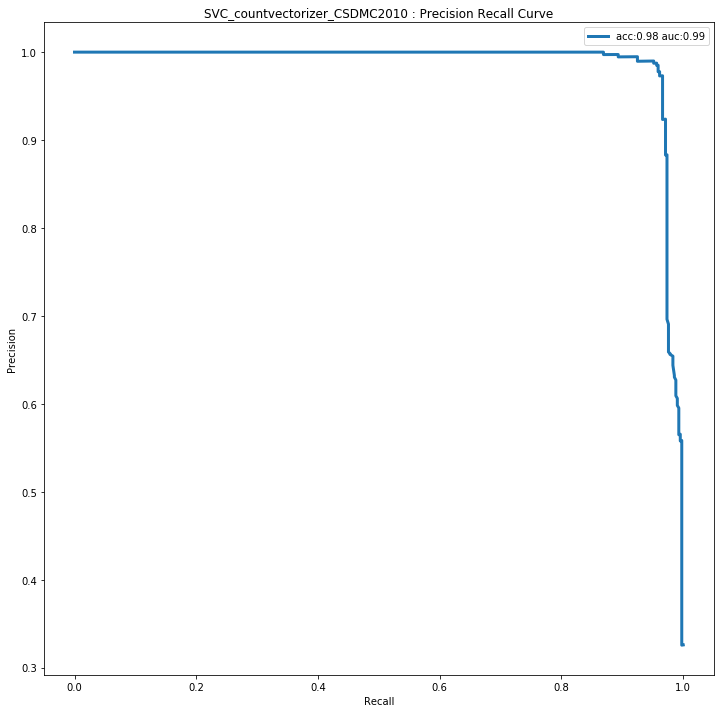

********************************************************************************
XGBoost_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.948132680614375
ROC AUC :  0.9939376638279203
Accuracy :  0.9725490196078431
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       863
         1.0       0.96      0.95      0.96       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.97      0.97      1275
weighted avg       0.97      0.97      0.97      1275



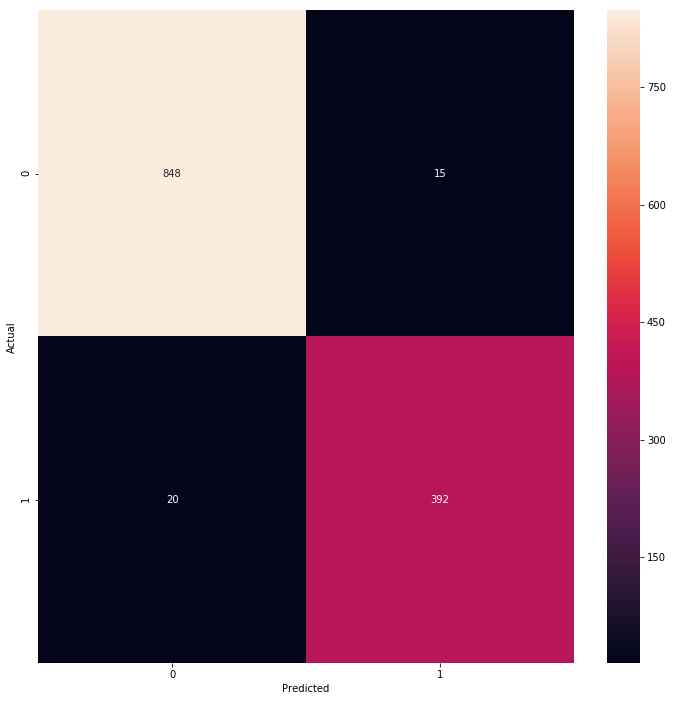

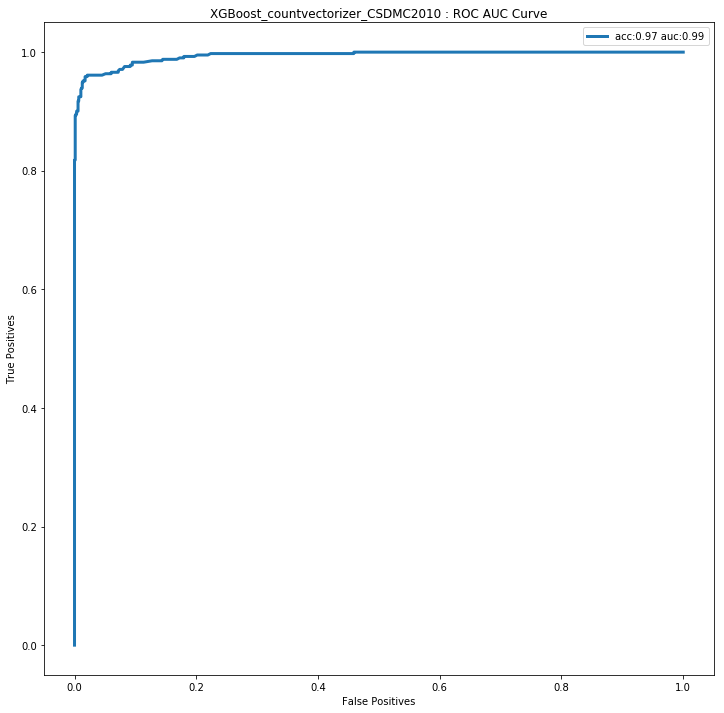

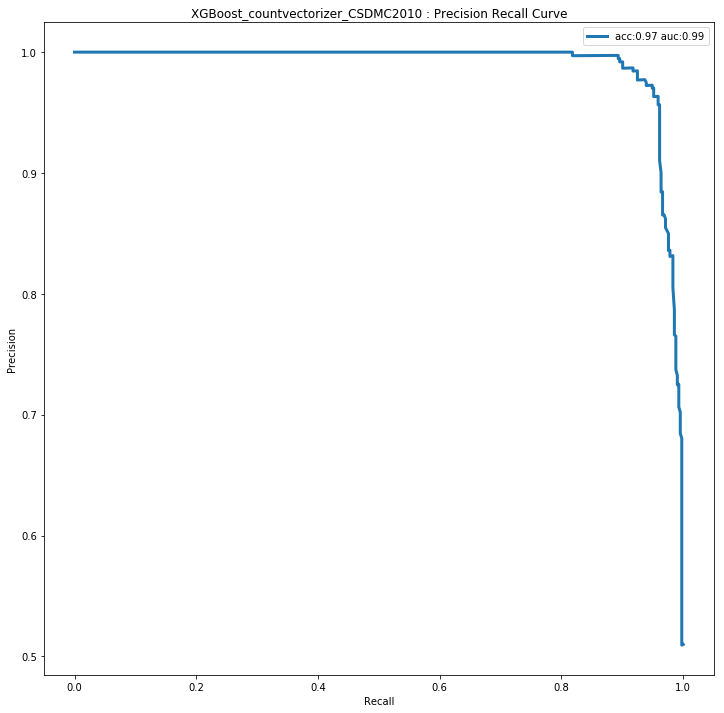

********************************************************************************
RandomForest_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.7314169081033348
ROC AUC :  0.9922445409443239
Accuracy :  0.9788235294117648
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       863
         1.0       0.97      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.97      0.98      1275
weighted avg       0.98      0.98      0.98      1275



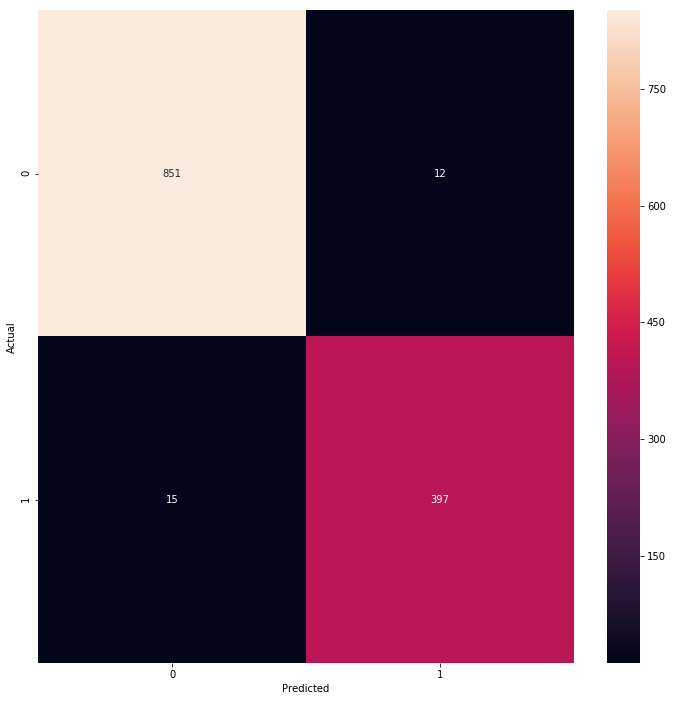

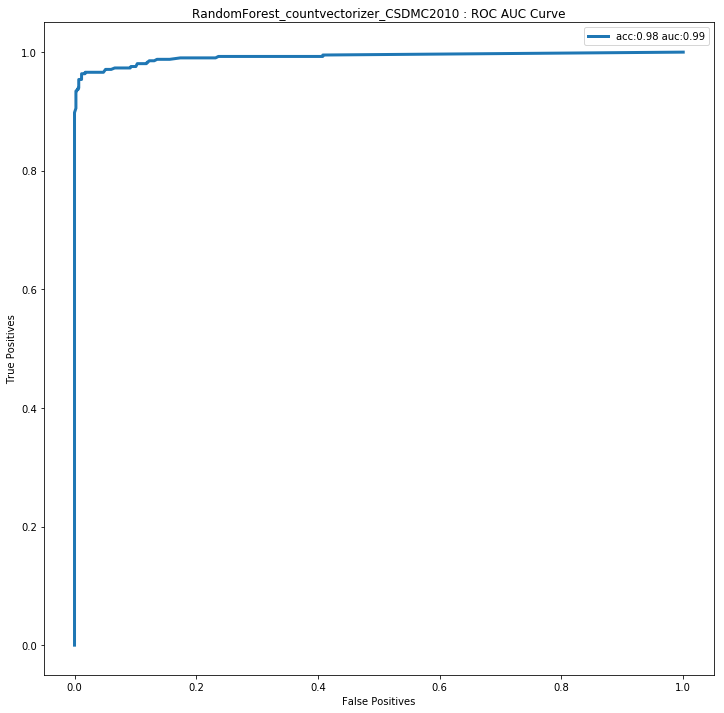

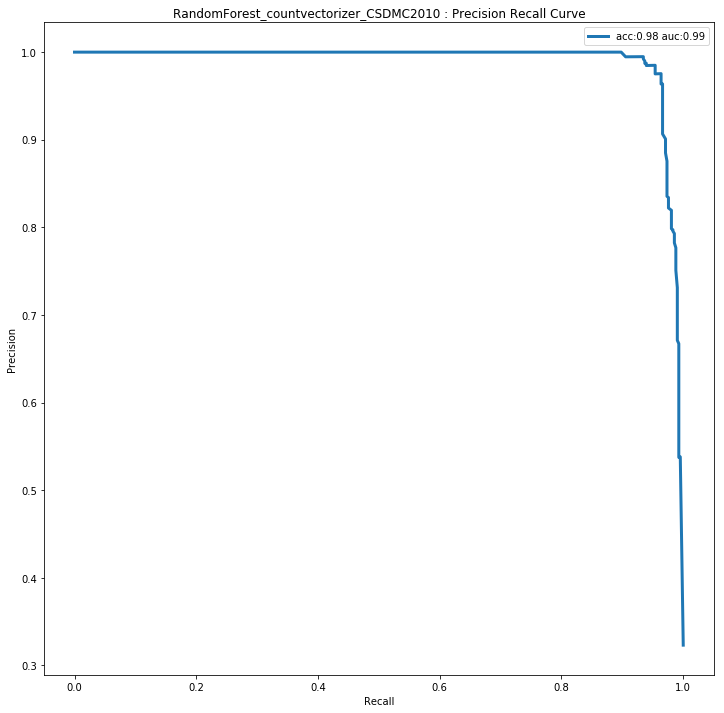

********************************************************************************
NaiveBayes_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  1.219018146008394
ROC AUC :  0.9825611155486056
Accuracy :  0.9647058823529412
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       863
         1.0       0.99      0.90      0.94       412

   micro avg       0.96      0.96      0.96      1275
   macro avg       0.97      0.95      0.96      1275
weighted avg       0.97      0.96      0.96      1275



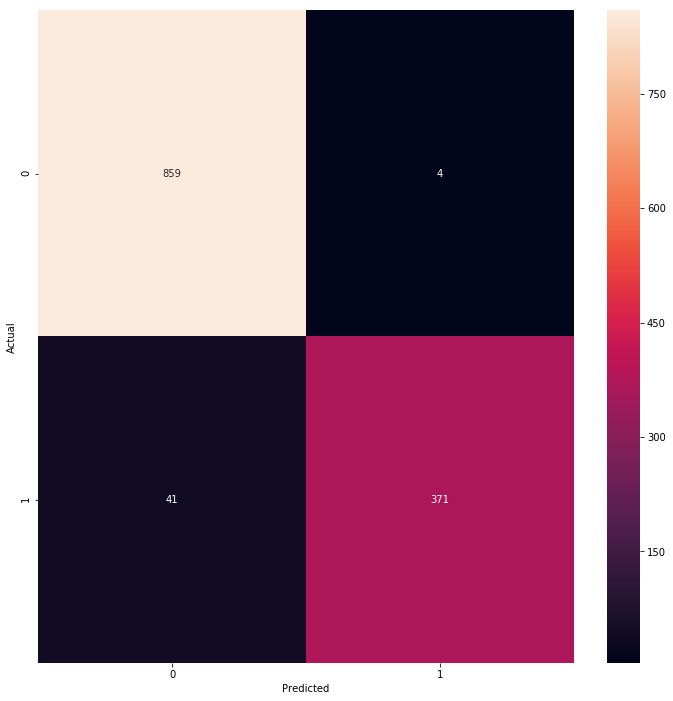

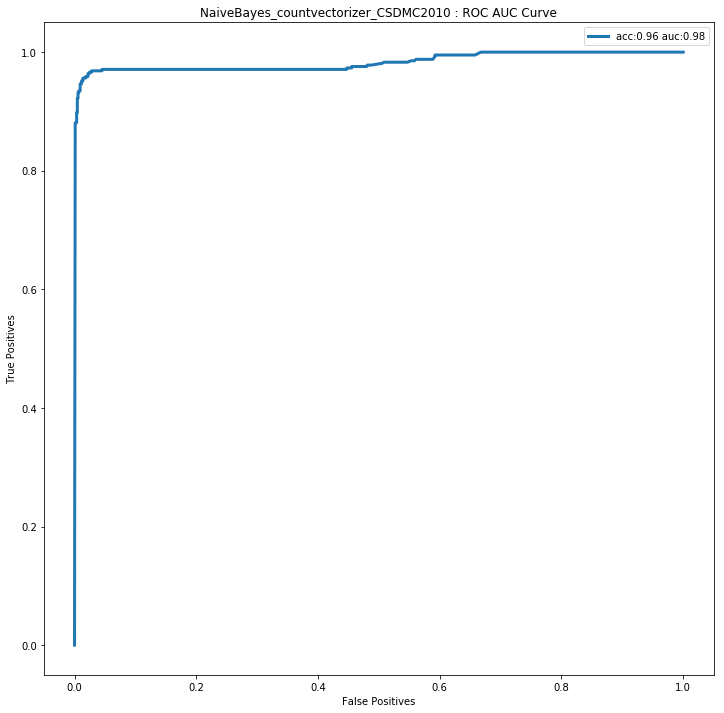

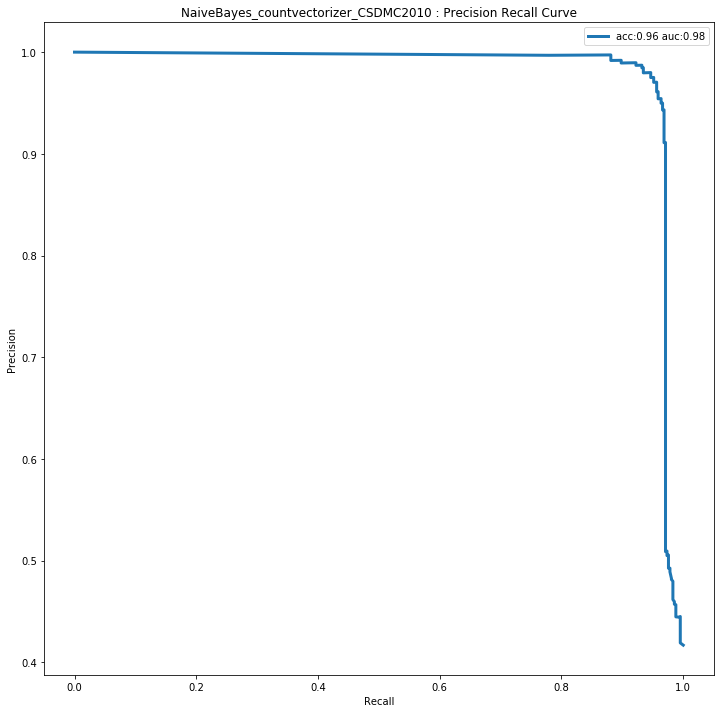

In [28]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cleaned, y_test)

## Adding Meaningful Strings to Test Data

In [29]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_countvectorizer_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.04492591917515508
Mean Relative Entropy :  0.06183256698464253
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
74     0.464     1.742     1.0     0.0       0.825       0.175
97     0.478     1.689     1.0     0.0       0.815       0.185
137    0.163     3.262     1.0     0.0       0.962       0.038
144    0.245     2.709     1.0     0.0       0.933       0.067
151    0.480     1.682     1.0     0.0       0.814       0.186
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
585     0.579     1.326     0.0     1.0       0.265       0.735
613     0.012     6.000     0.0     1.0       0.002       0.998
1063    0.316     2.346     0.0     1.0       0.096       0.904
1078    0.363     2.136     0.0     1.0       0.11

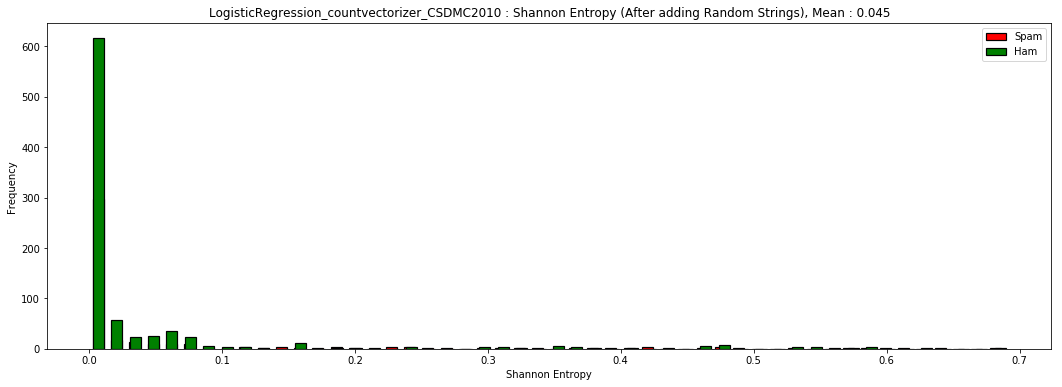

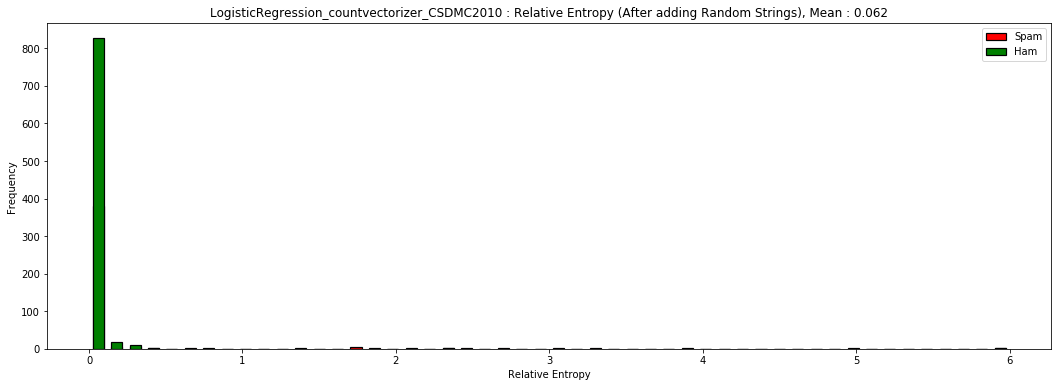

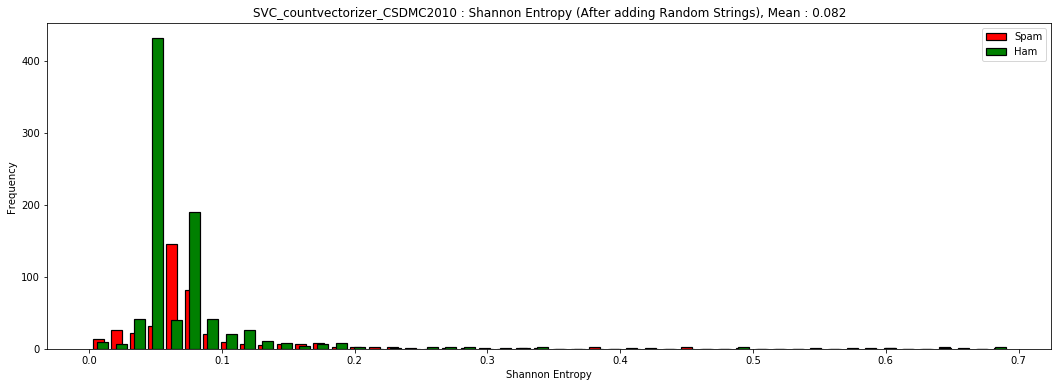

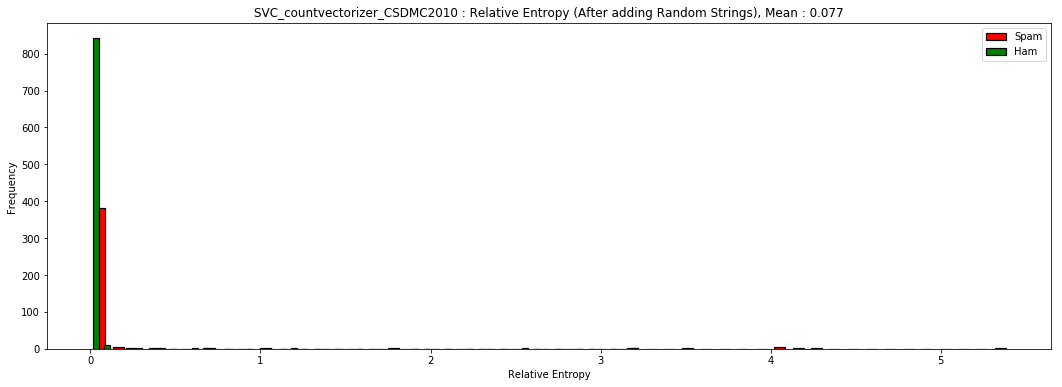

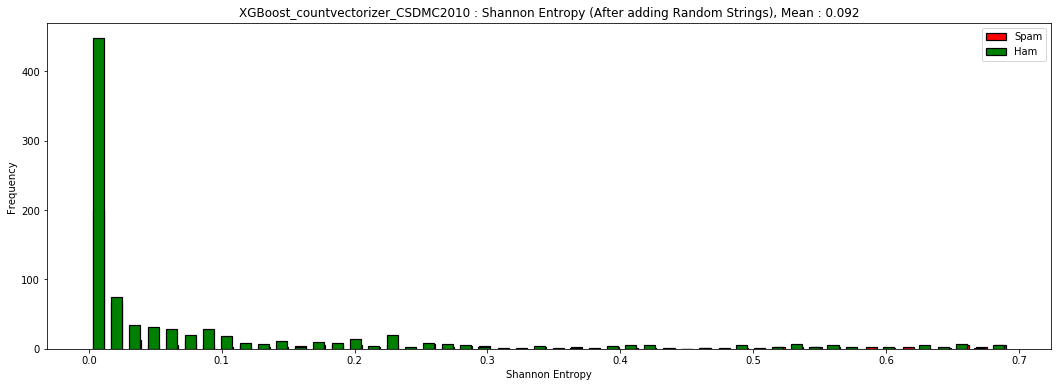

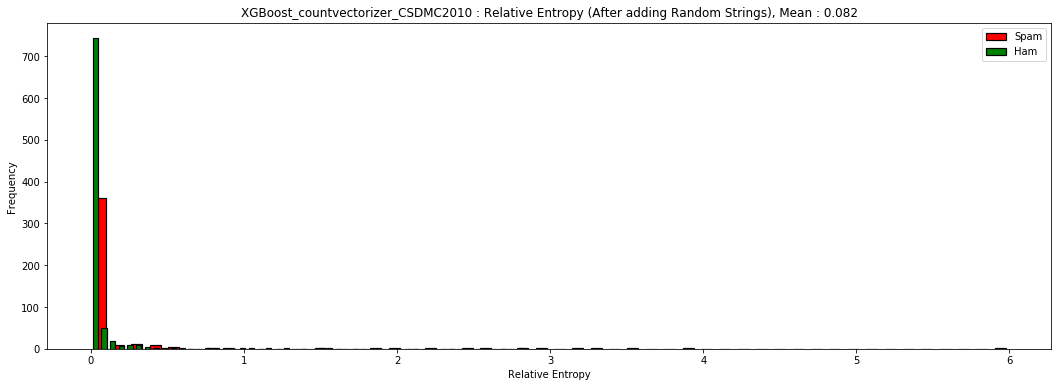

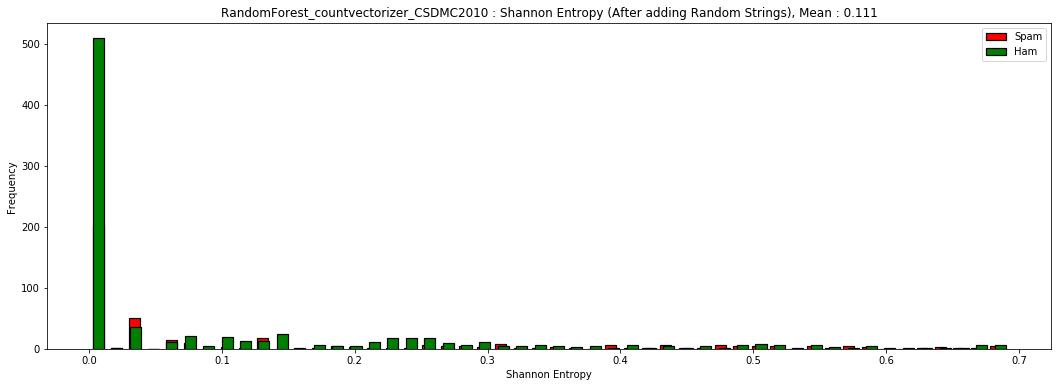

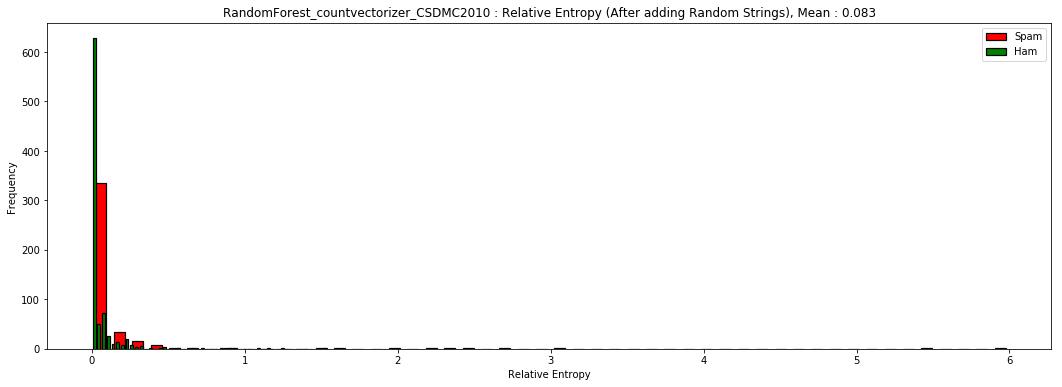

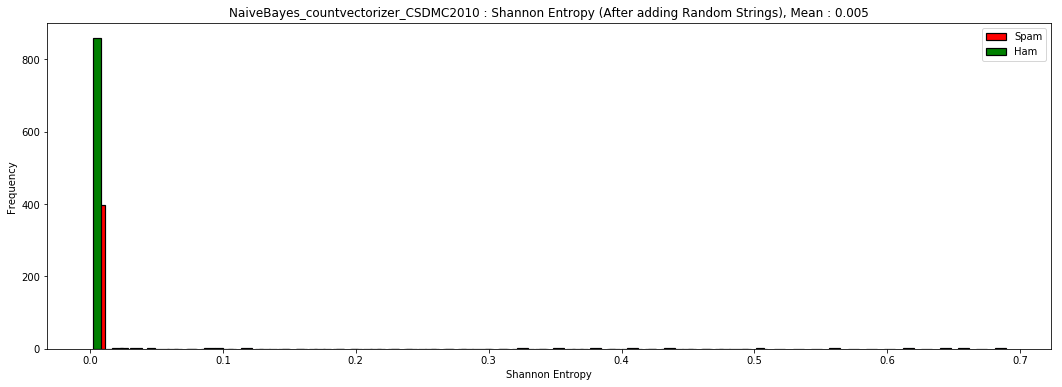

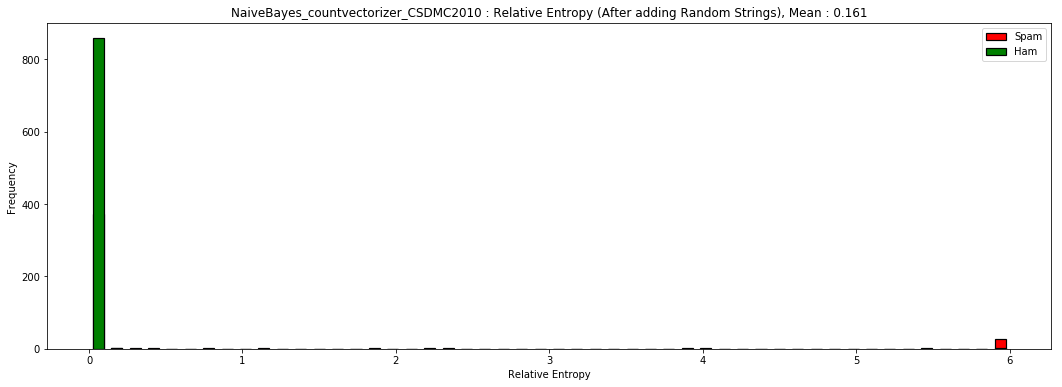

In [30]:
visualise_entropies(dataset, test_x_with_random_strings, y_test, 'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.5959669633510724
ROC AUC :  0.9960090674886656
Accuracy :  0.9827450980392157
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       863
         1.0       0.99      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.98      0.98      1275
weighted avg       0.98      0.98      0.98      1275



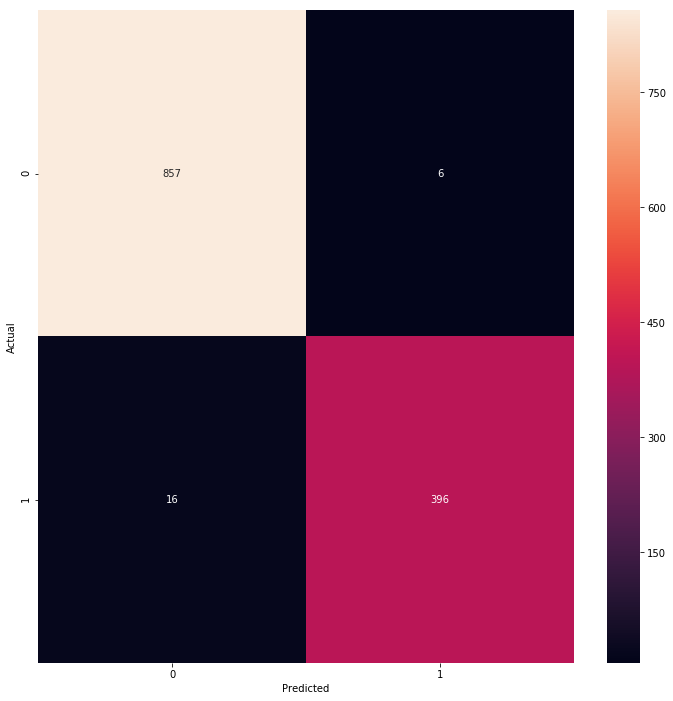

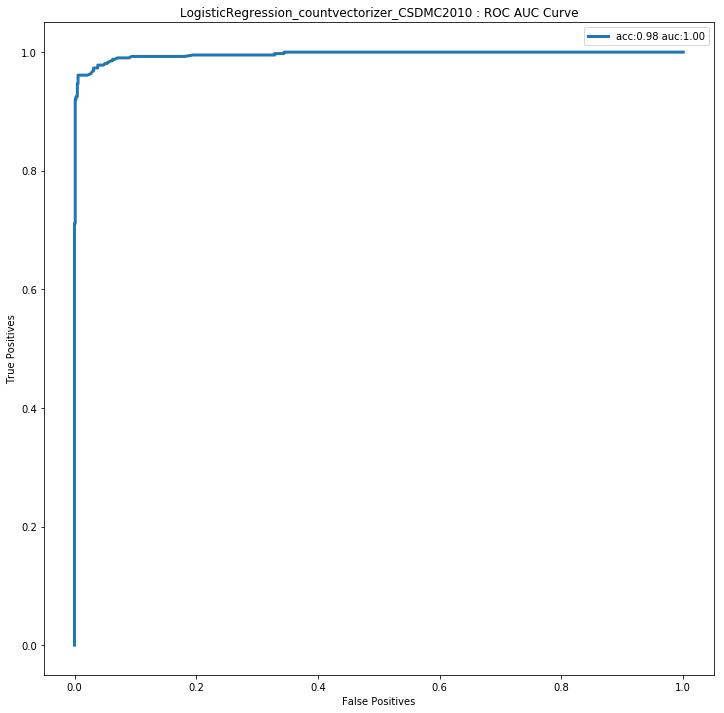

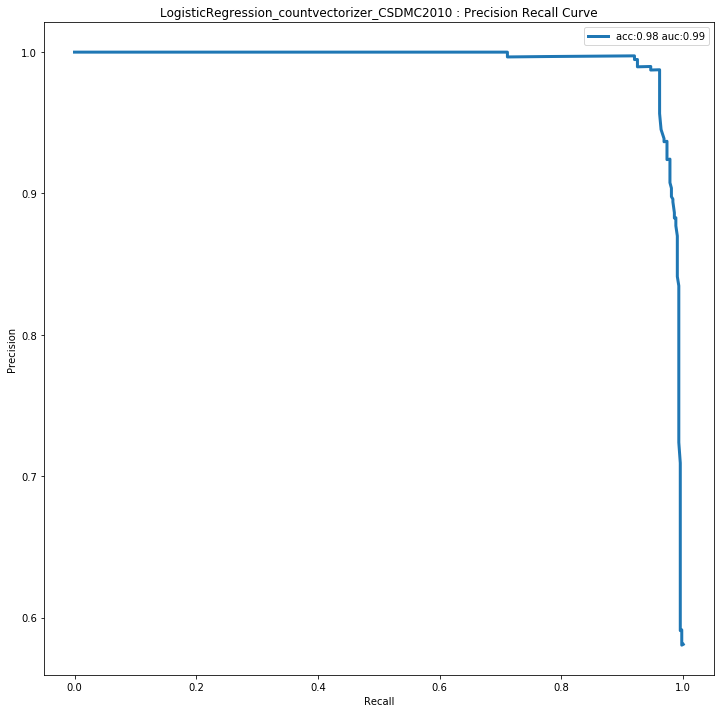

********************************************************************************
SVC_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.6230561997392378
ROC AUC :  0.9898384502019374
Accuracy :  0.9819607843137255
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       863
         1.0       0.99      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.98      0.98      1275
weighted avg       0.98      0.98      0.98      1275



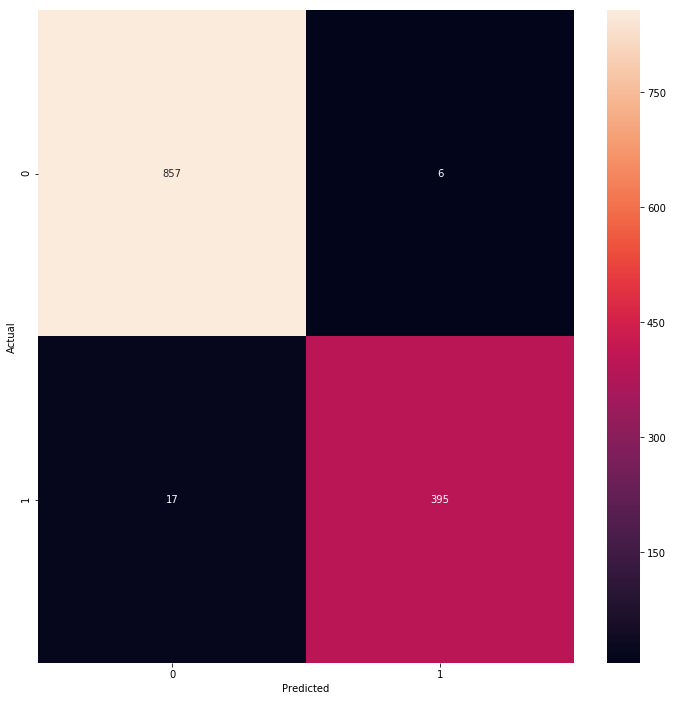

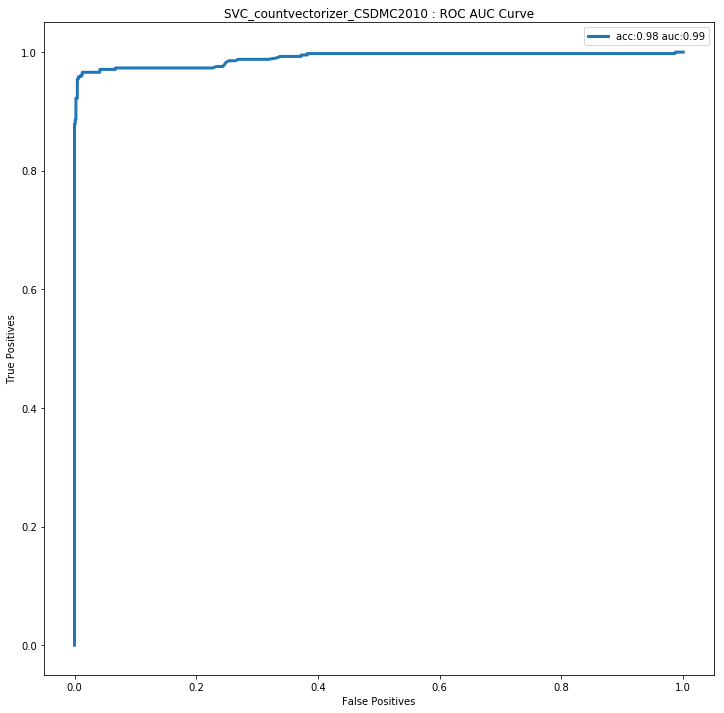

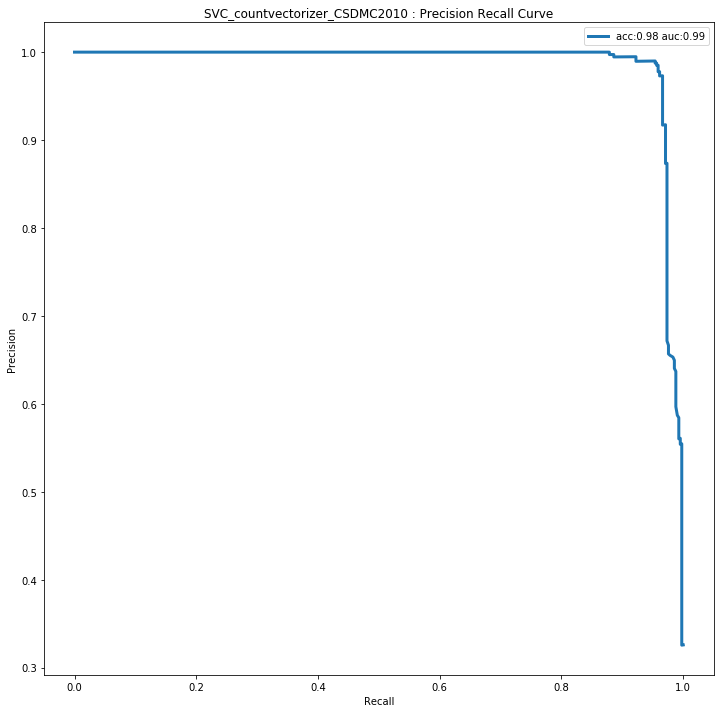

********************************************************************************
XGBoost_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.948132680614375
ROC AUC :  0.9939376638279203
Accuracy :  0.9725490196078431
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       863
         1.0       0.96      0.95      0.96       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.97      0.97      1275
weighted avg       0.97      0.97      0.97      1275



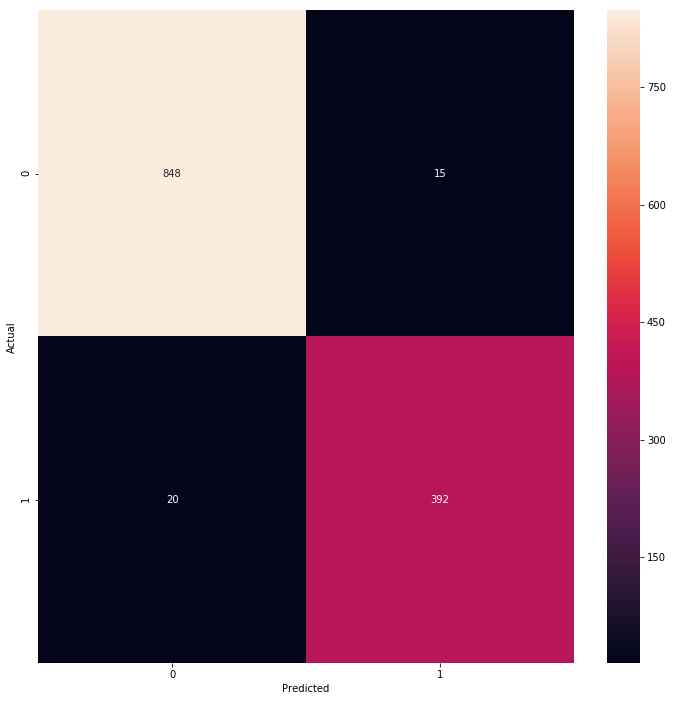

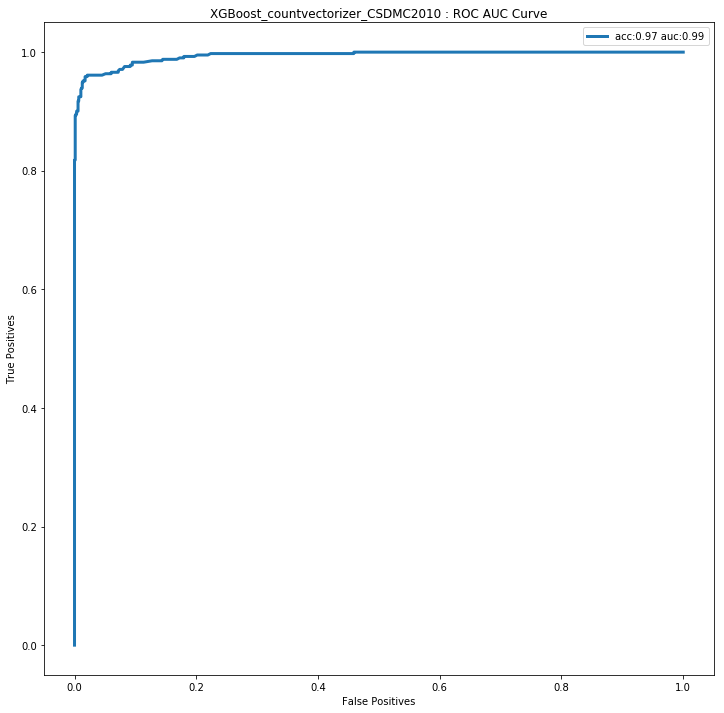

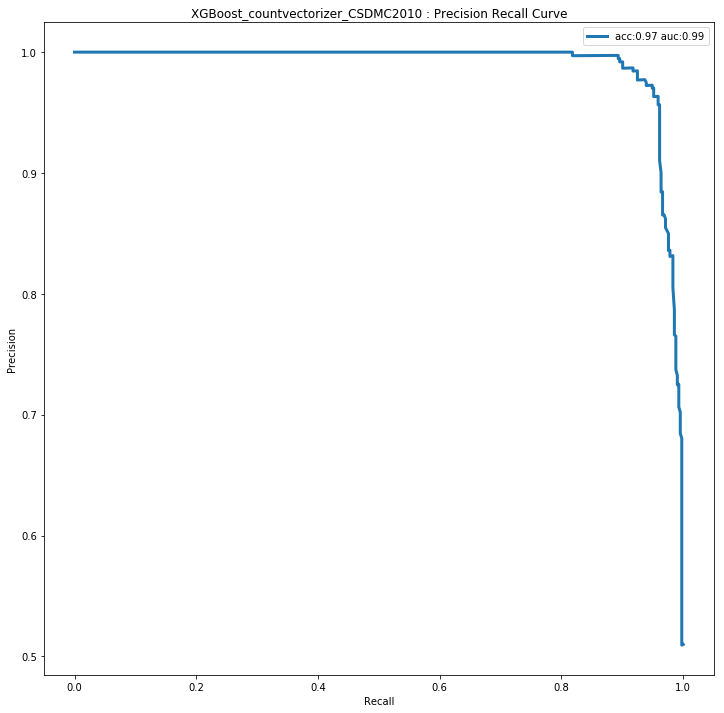

********************************************************************************
RandomForest_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.7314169081033348
ROC AUC :  0.9922445409443239
Accuracy :  0.9788235294117648
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       863
         1.0       0.97      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.97      0.98      1275
weighted avg       0.98      0.98      0.98      1275



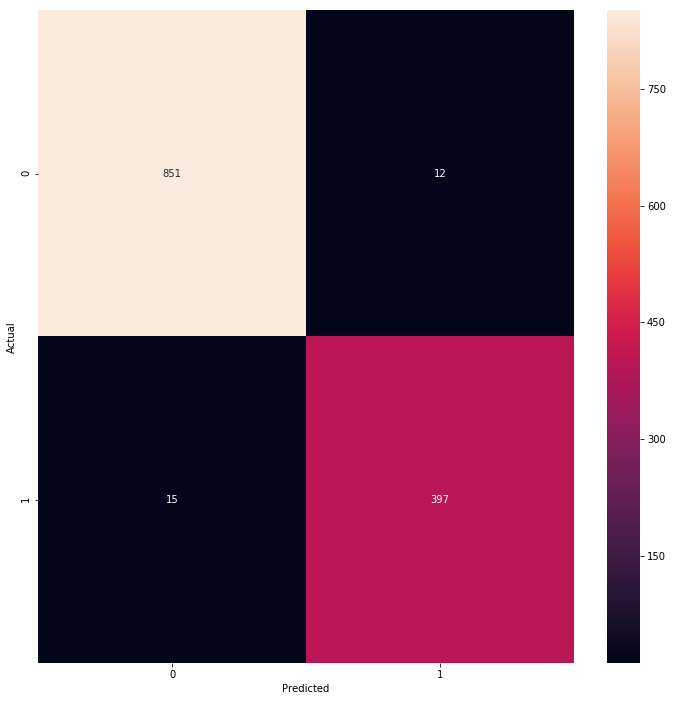

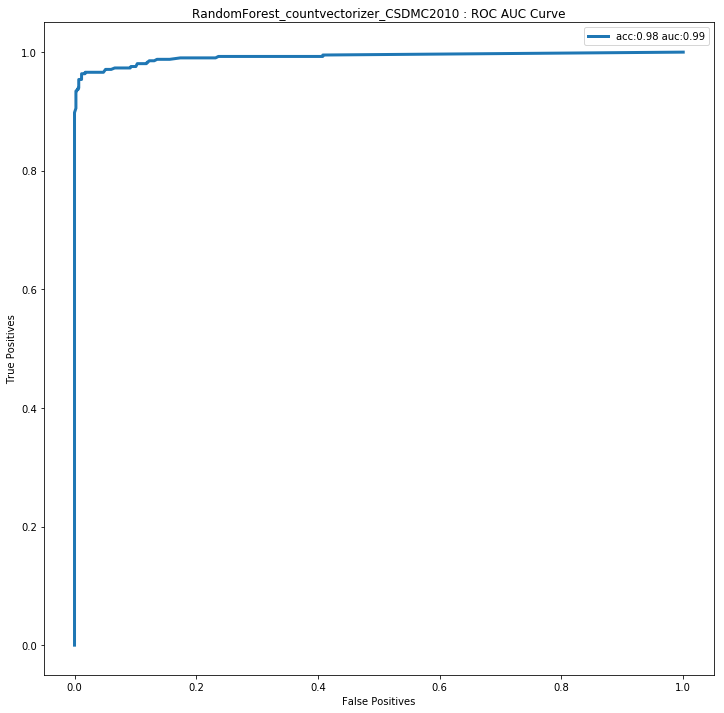

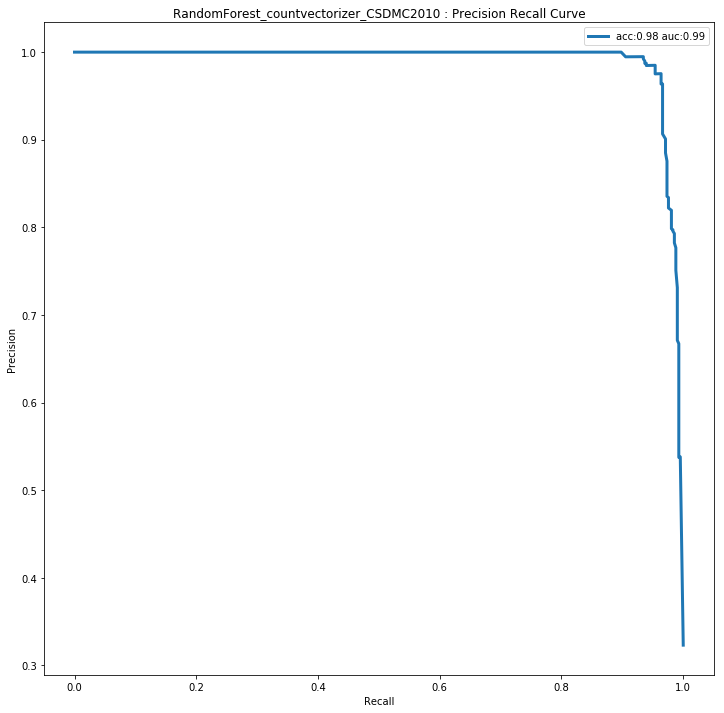

********************************************************************************
NaiveBayes_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  1.083571964067568
ROC AUC :  0.9825737717827854
Accuracy :  0.9686274509803922
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       863
         1.0       0.99      0.91      0.95       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.95      0.96      1275
weighted avg       0.97      0.97      0.97      1275



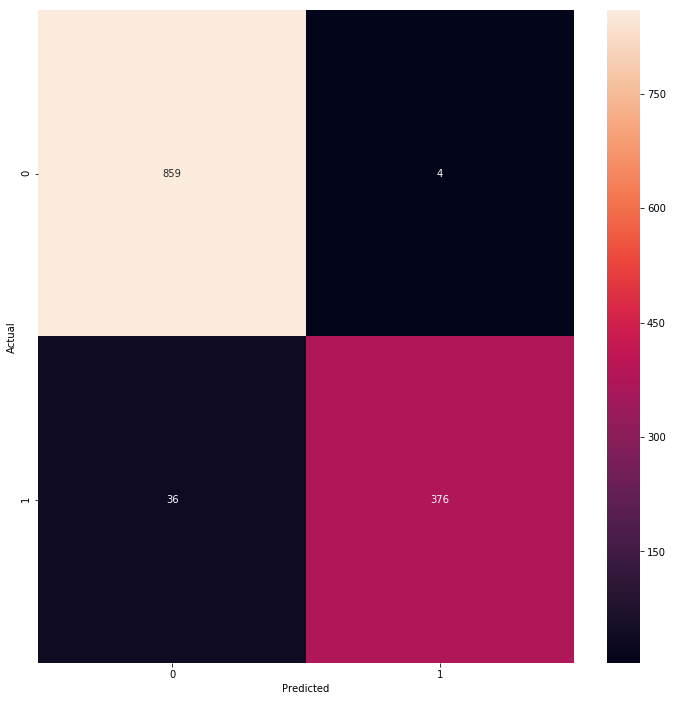

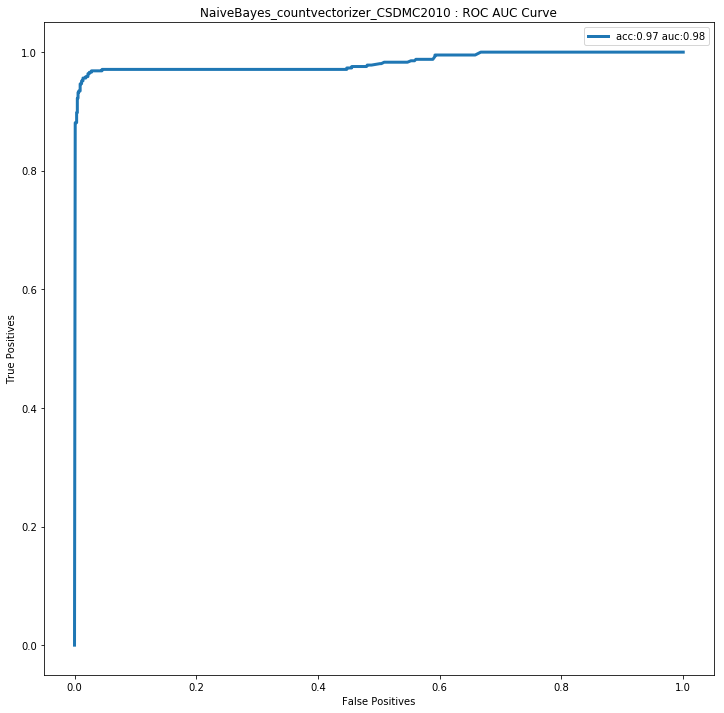

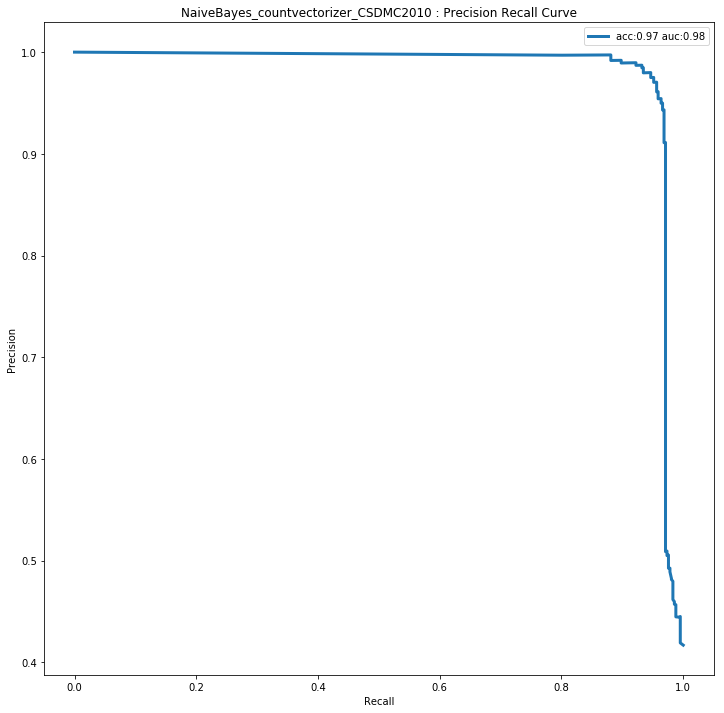

In [31]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [32]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_countvectorizer_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.6790151529262549
Mean Relative Entropy :  0.7673075603380007
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
412    0.679     0.877     0.0     1.0       0.416       0.584
413    0.679     0.877     0.0     1.0       0.416       0.584
414    0.679     0.877     0.0     1.0       0.416       0.584
415    0.679     0.877     0.0     1.0       0.416       0.584
416    0.679     0.877     0.0     1.0       0.416       0.584
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1270    0.679     0.877     0.0     1.0       0.416       0.584
1271    0.679     0.877     0.0     1.0       0.416       0.584
1272    0.679     0.877     0.0     1.0       0.416       0.584
1273    0.679     0.877     0.0     1.0       0.416 

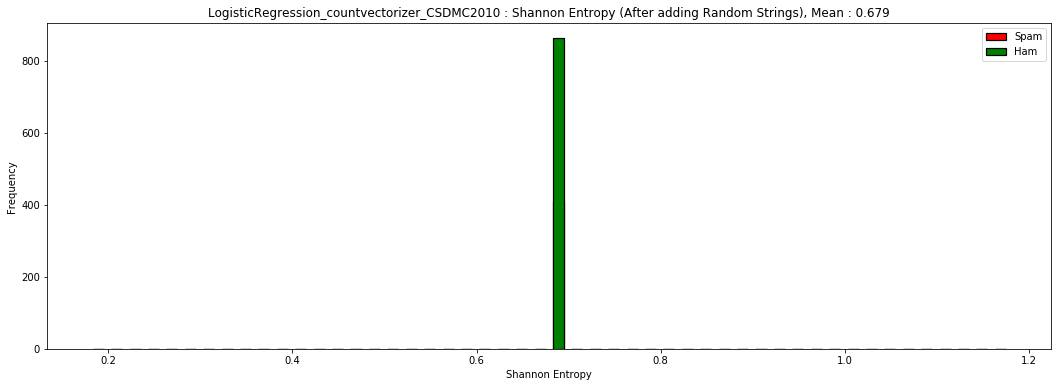

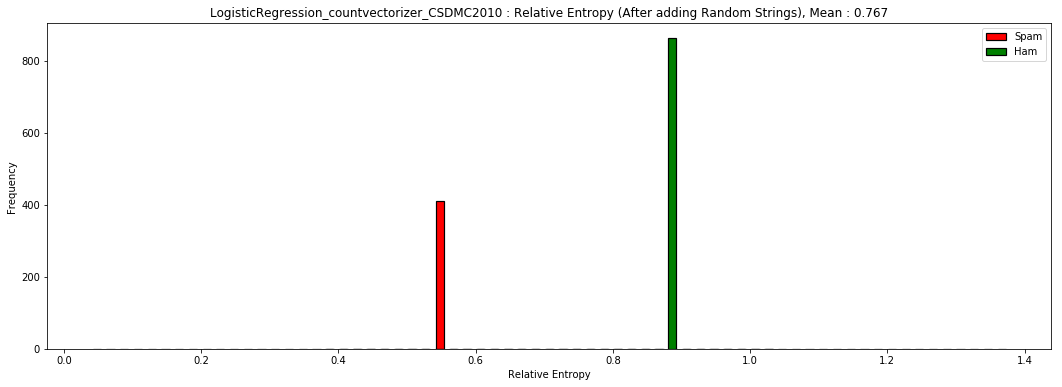

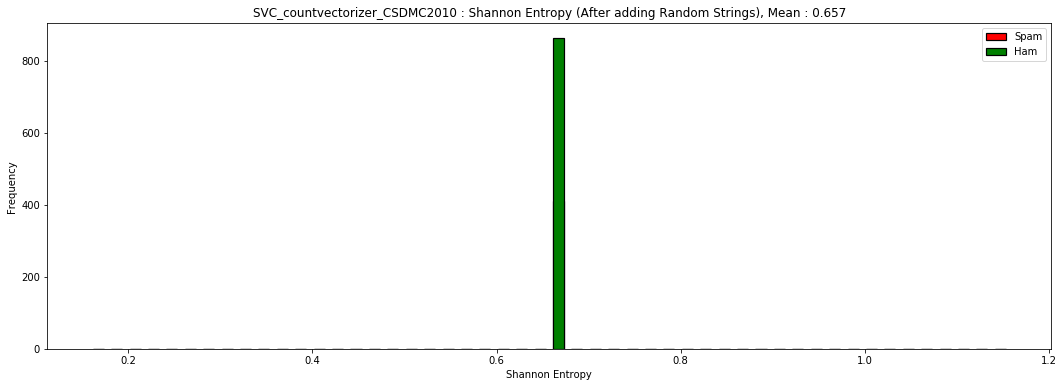

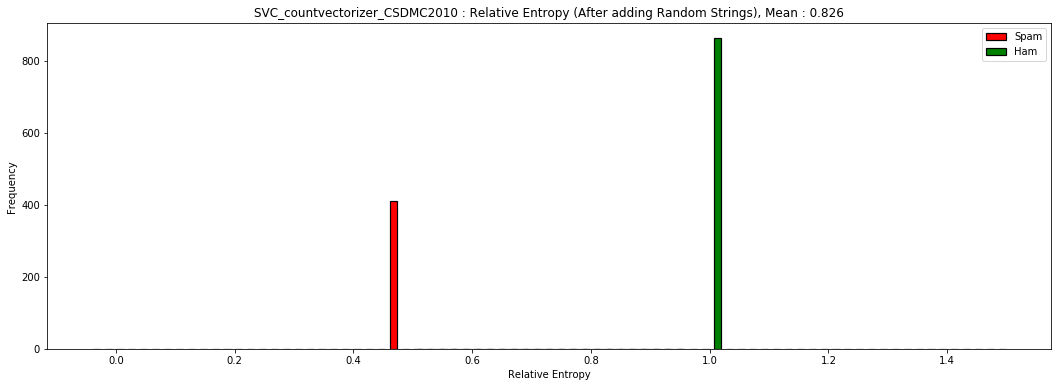

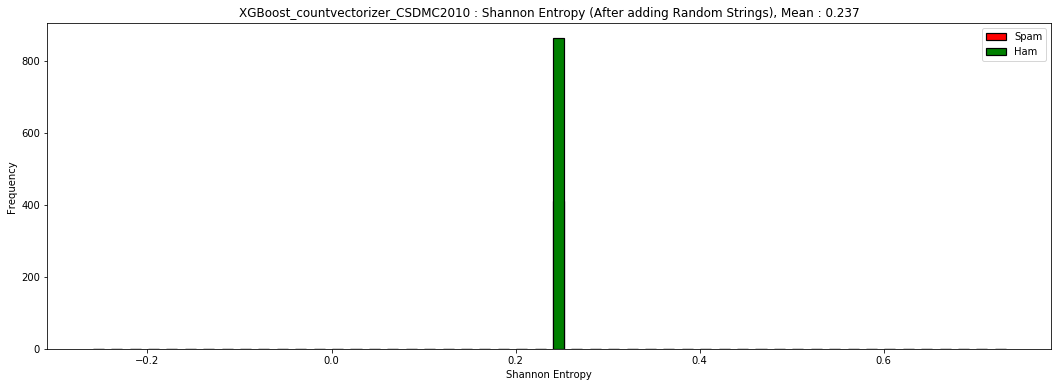

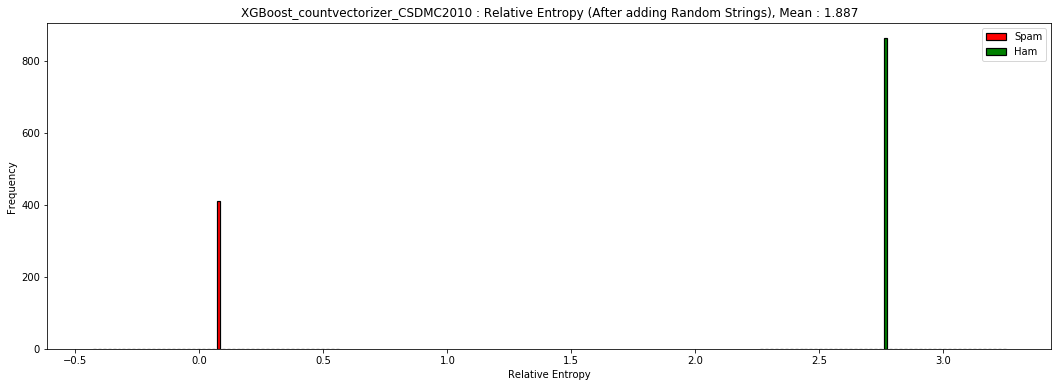

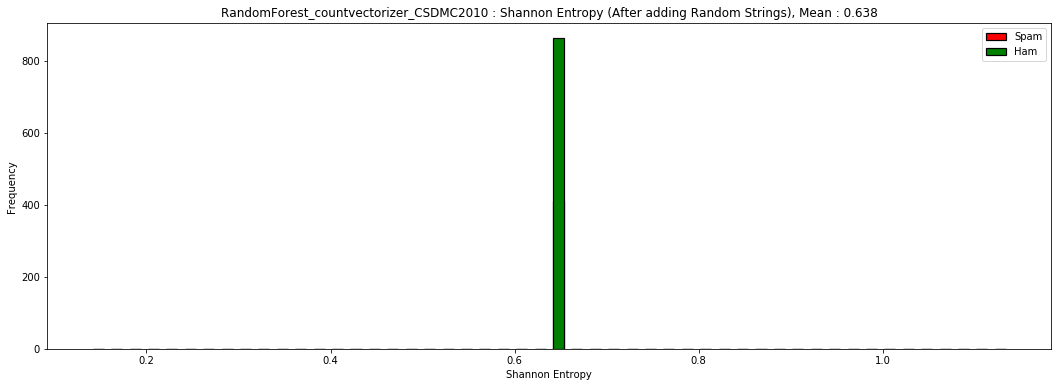

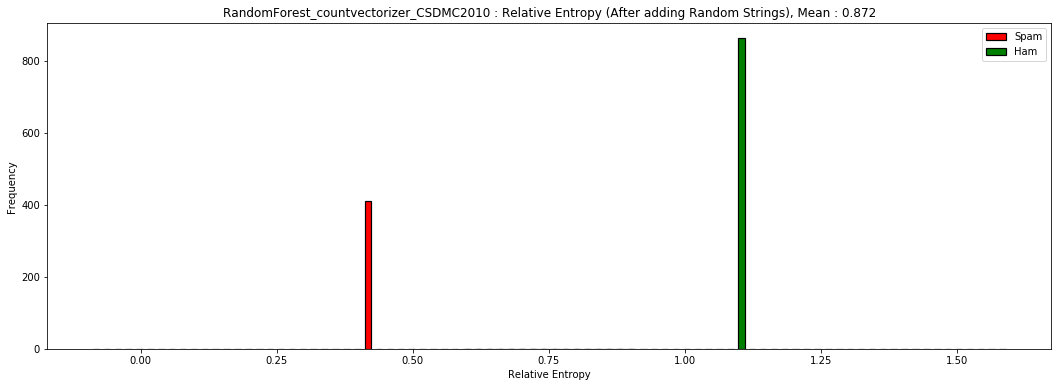

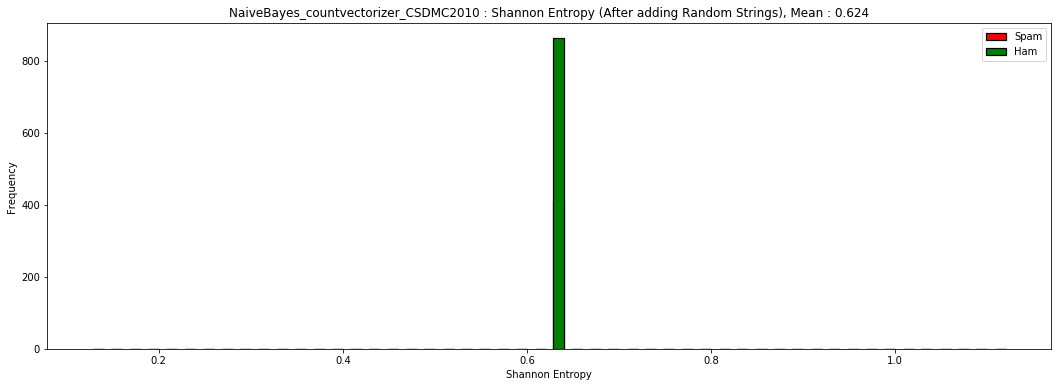

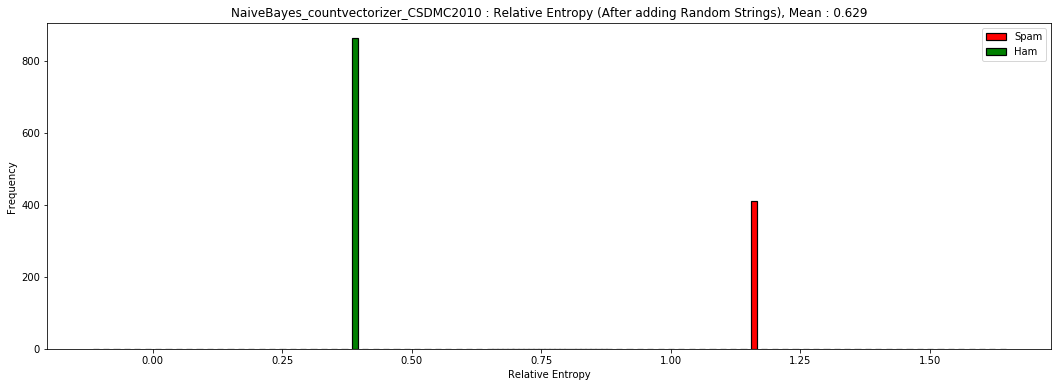

In [33]:
visualise_entropies(dataset, test_x_with_random_strings, y_test, 'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



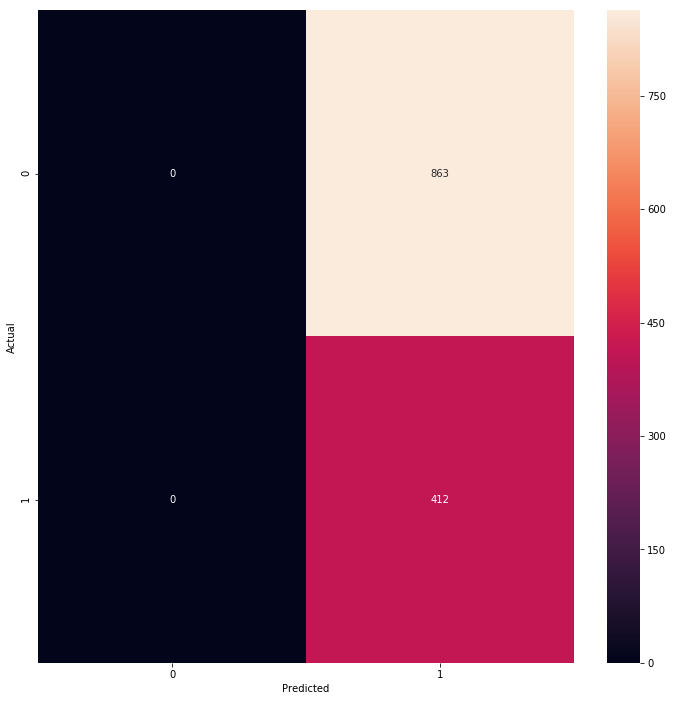

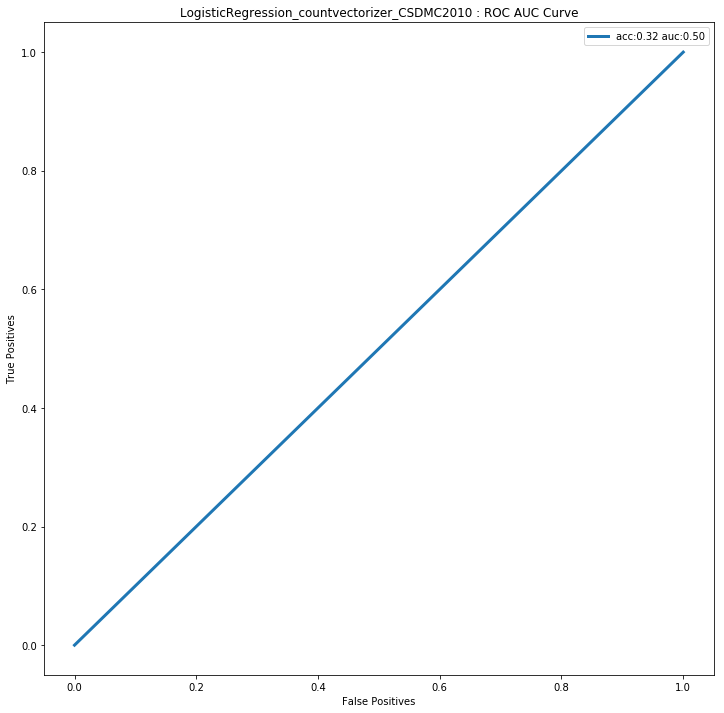

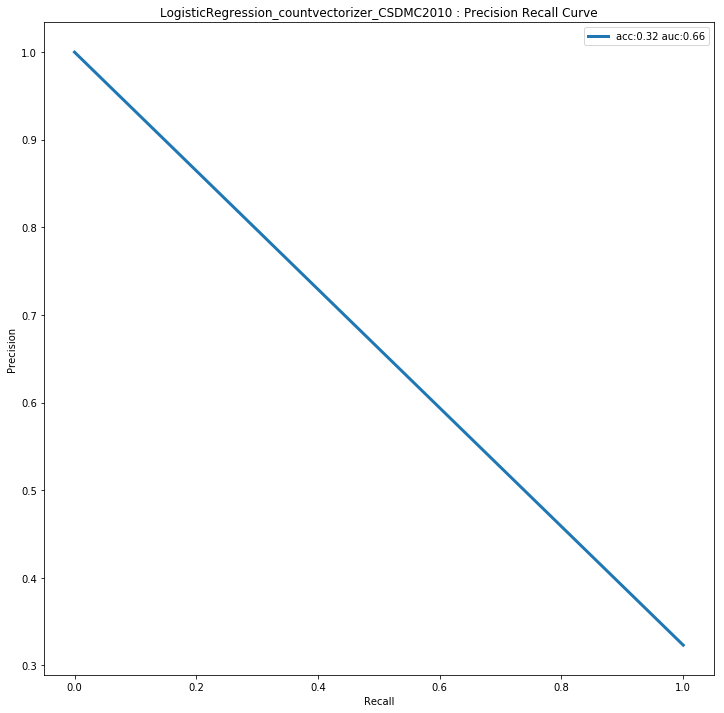

********************************************************************************
SVC_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



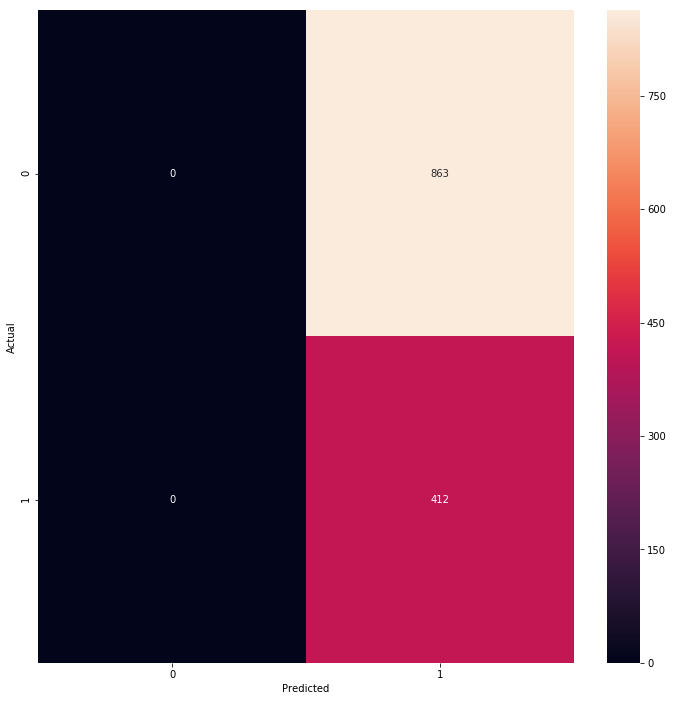

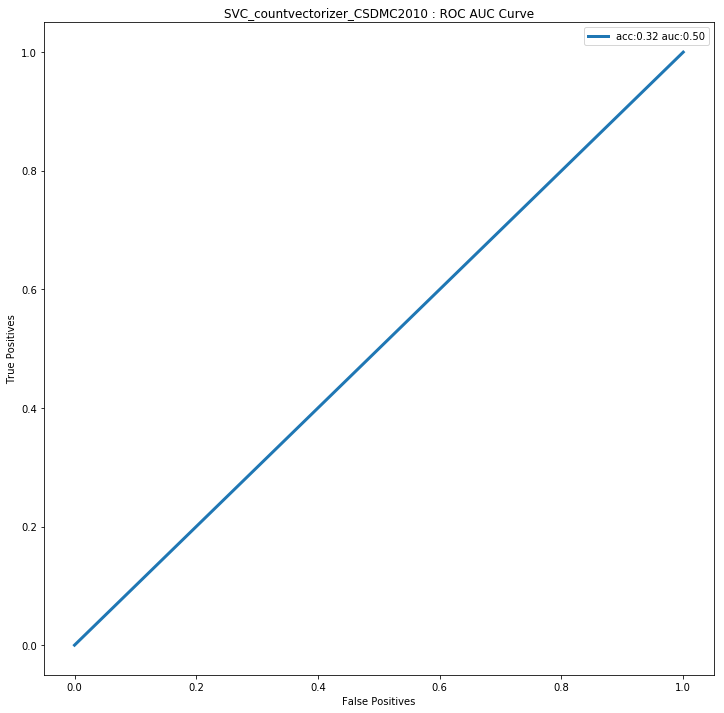

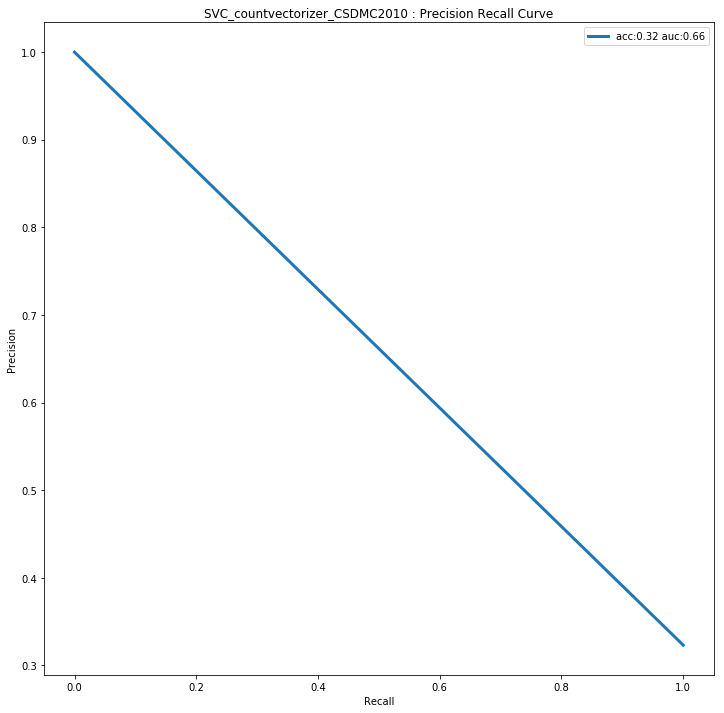

********************************************************************************
XGBoost_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



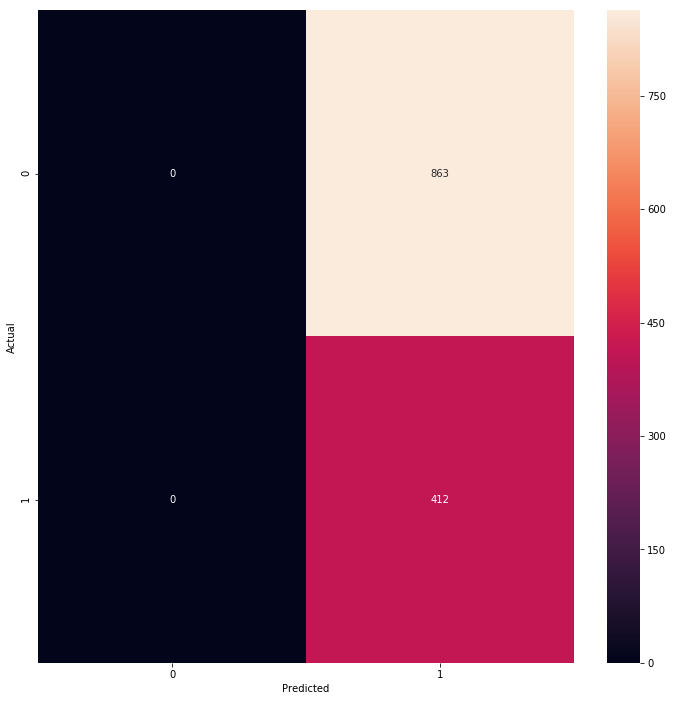

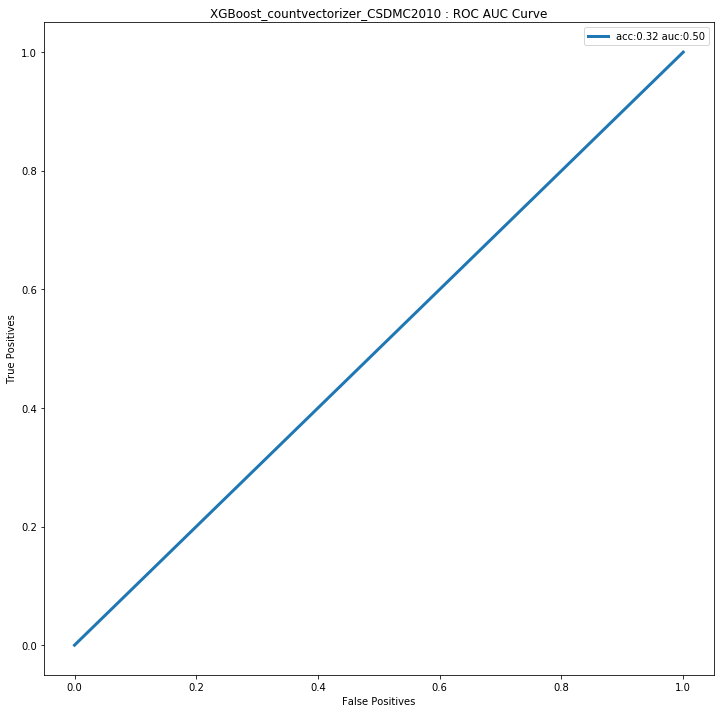

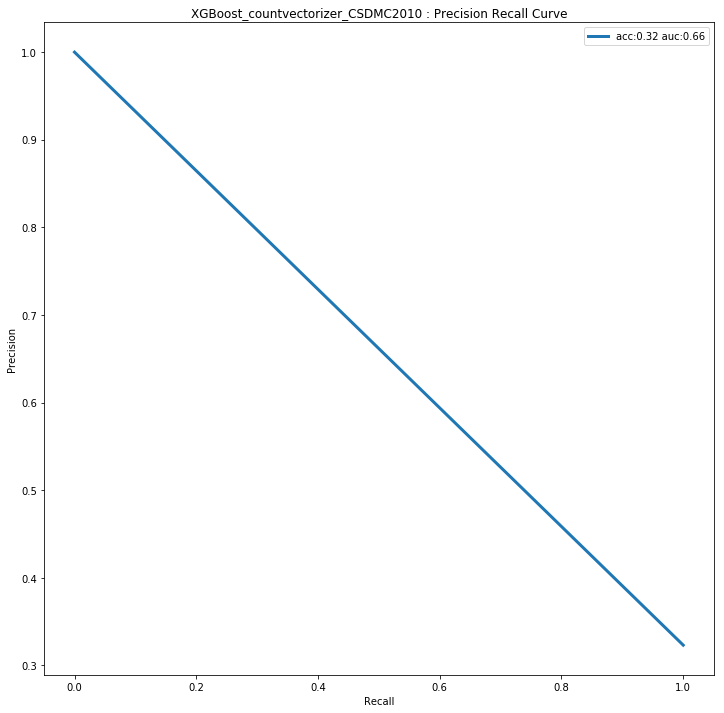

********************************************************************************
RandomForest_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



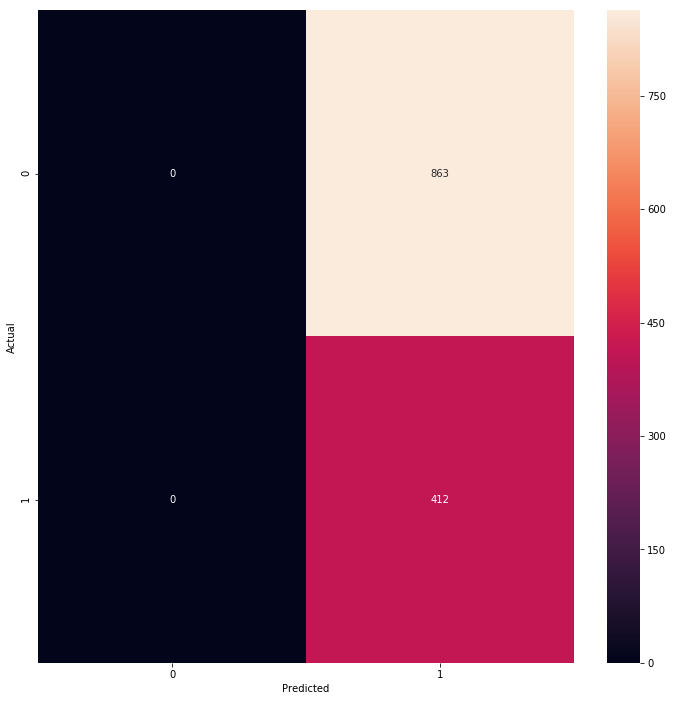

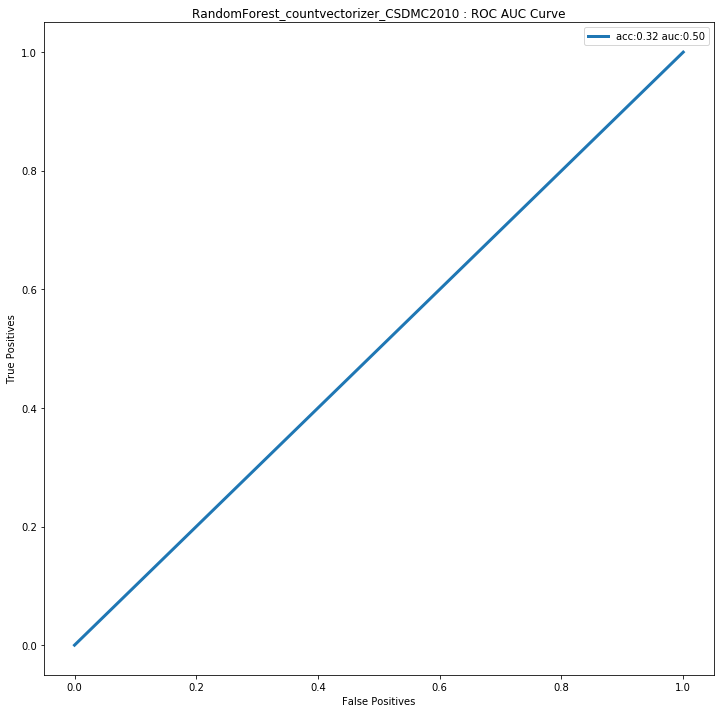

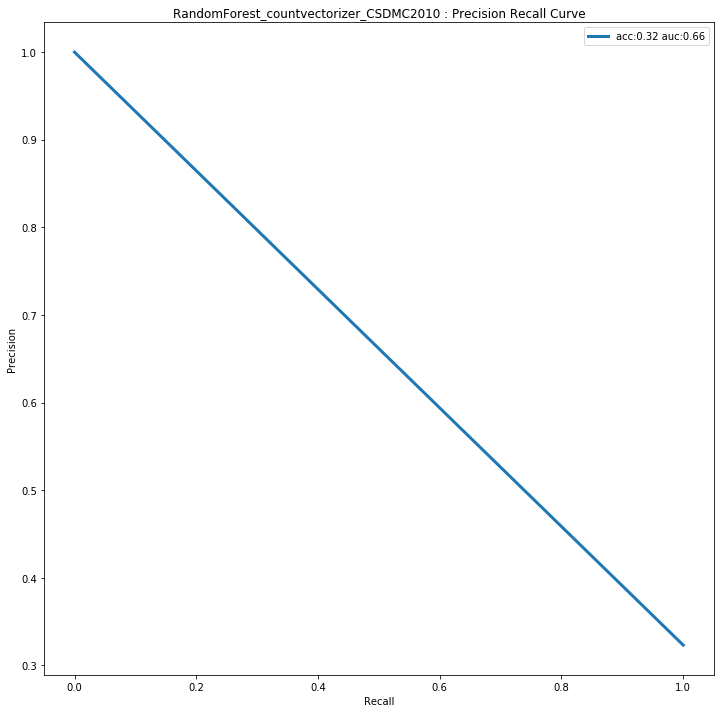

********************************************************************************
NaiveBayes_countvectorizer_CSDMC2010
********************************************************************************
Log Loss :  11.160765391924079
ROC AUC :  0.5
Accuracy :  0.6768627450980392
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81       863
         1.0       0.00      0.00      0.00       412

   micro avg       0.68      0.68      0.68      1275
   macro avg       0.34      0.50      0.40      1275
weighted avg       0.46      0.68      0.55      1275



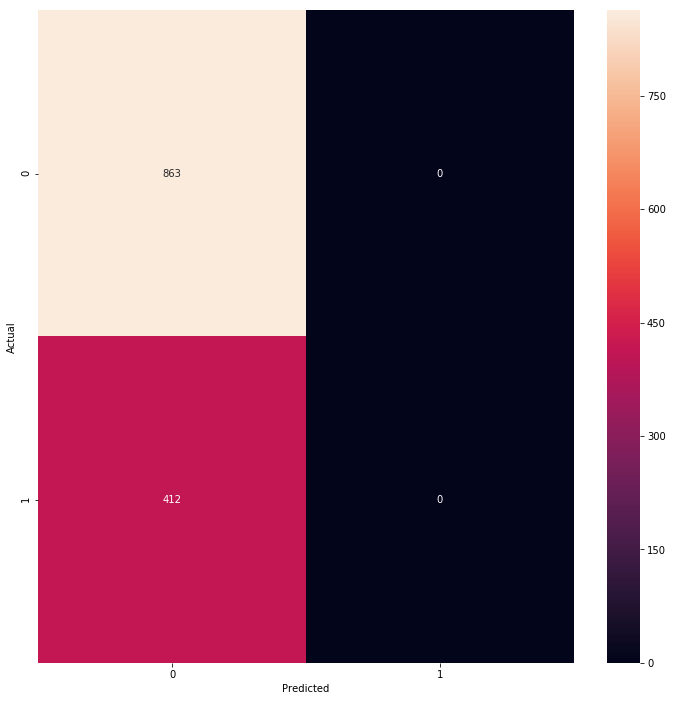

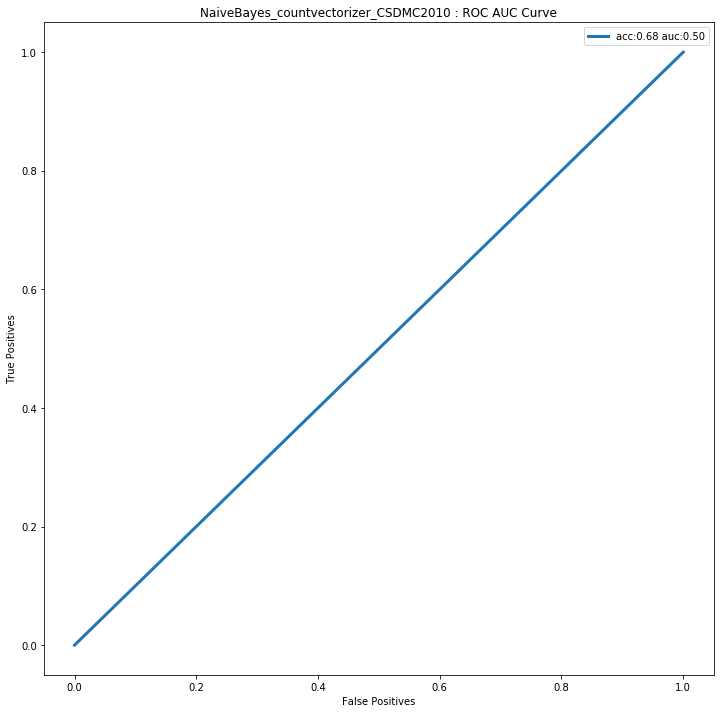

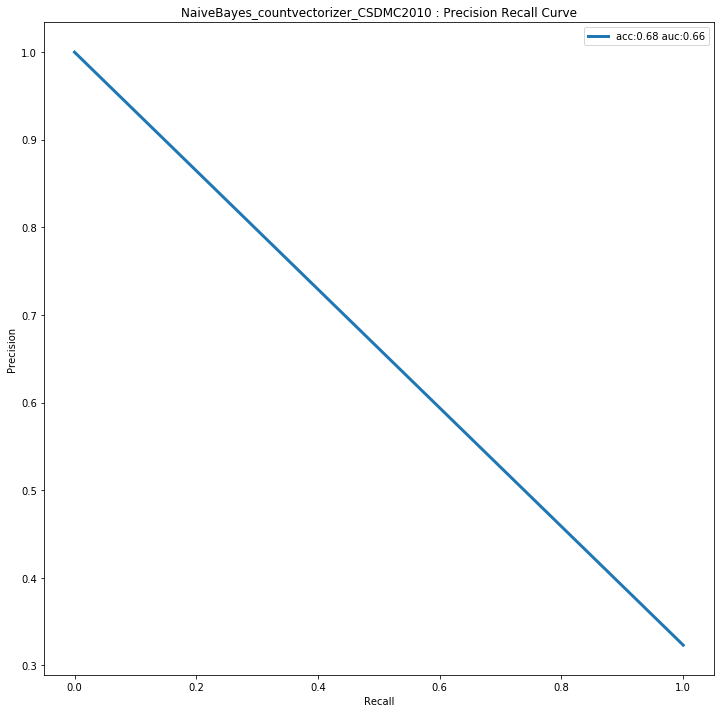

In [34]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

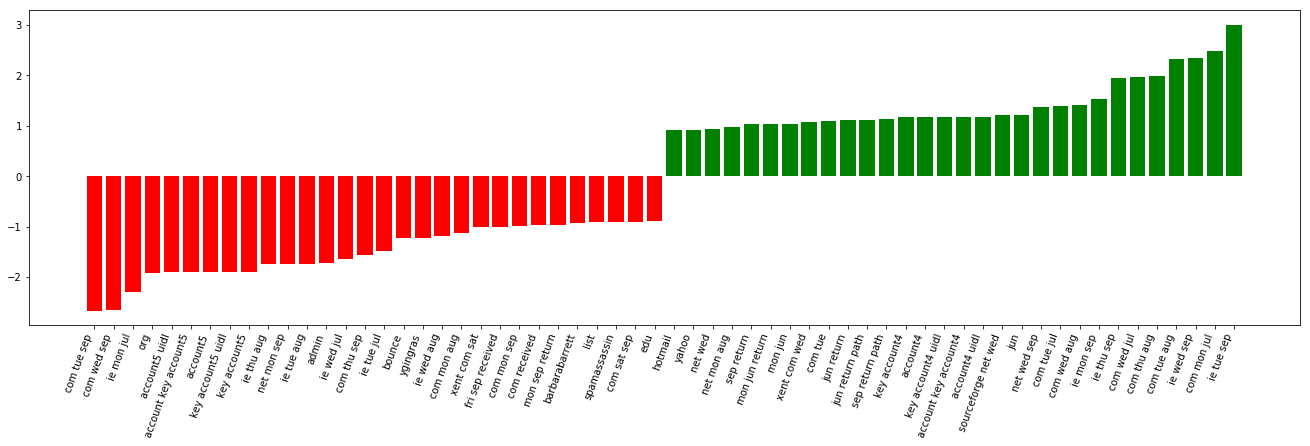

In [35]:
visualize_coefficients(grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_countvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## 2. TFIDF Approach

## Trying various models and keeping track of best performing params

In [36]:
%%time
grids = {}
entropies = {}
try_various_models_on_data(dataset, train_x_cleaned,y_train, test_x_cleaned, y_test, preprocessing='tfidfvectorizer')
gc.enable(); gc.collect();

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score :  0.97870249017038
Test Accuracy :  0.9803921568627451
Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 3)}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.7min finished


Best Score :  0.977391874180865
Test Accuracy :  0.9764705882352941
Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 3)}

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 10.4min finished


Best Score :  0.7778505897771952
Test Accuracy :  0.7568627450980392
Best Params :  {'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 1000}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.3min finished


Best Score :  0.9456094364351245
Test Accuracy :  0.9427450980392157
Best Params :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200, 'tfidfvectorizer__ngram_range': (1, 3)}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.8s finished


Best Score :  0.9698558322411533
Test Accuracy :  0.9623529411764706
Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
CPU times: user 17.4 s, sys: 476 ms, total: 17.9 s
Wall time: 15min 2s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_tfidfvectorizer_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.04984701290916474
Mean Relative Entropy :  0.06360923250556501
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2      0.684     0.836     1.0     0.0       0.566       0.434
74     0.528     1.509     1.0     0.0       0.779       0.221
97     0.460     1.755     1.0     0.0       0.827       0.173
101    0.692     0.735     1.0     0.0       0.520       0.480
137    0.148     3.381     1.0     0.0       0.966       0.034
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
516     0.464     1.743     0.0     1.0   1.750e-01       0.825
613     0.004     6.000     0.0     1.0   4.331e-04       1.000
1063    0.636     1.099     0.0     1.0   3.333e-01       0.667
1078    0.464     1.743     0.0     1.0   1.750e-0

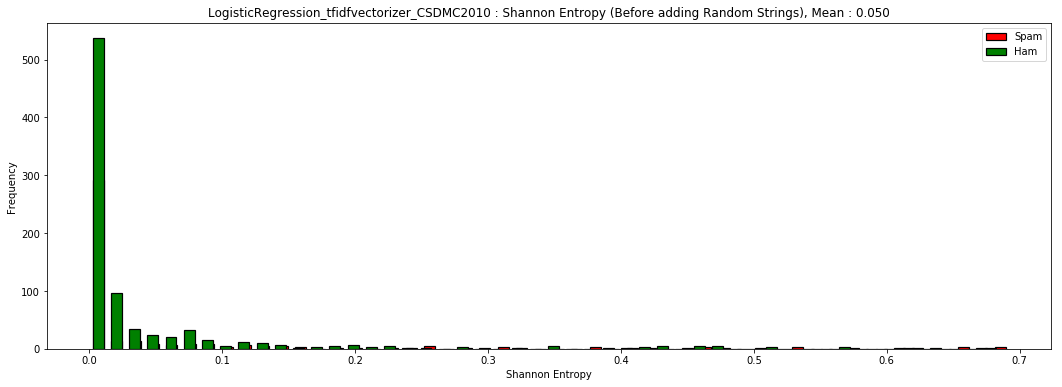

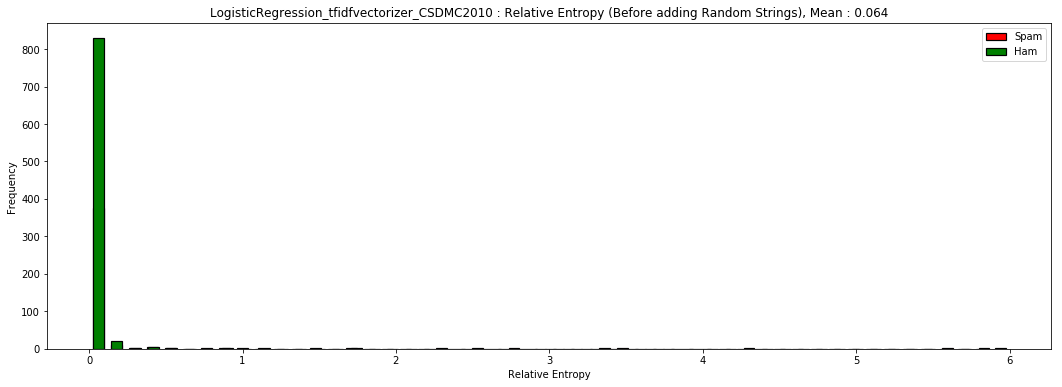

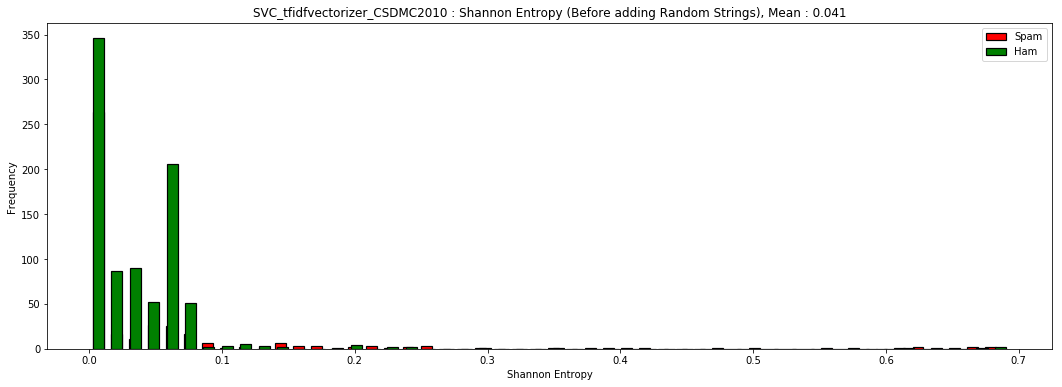

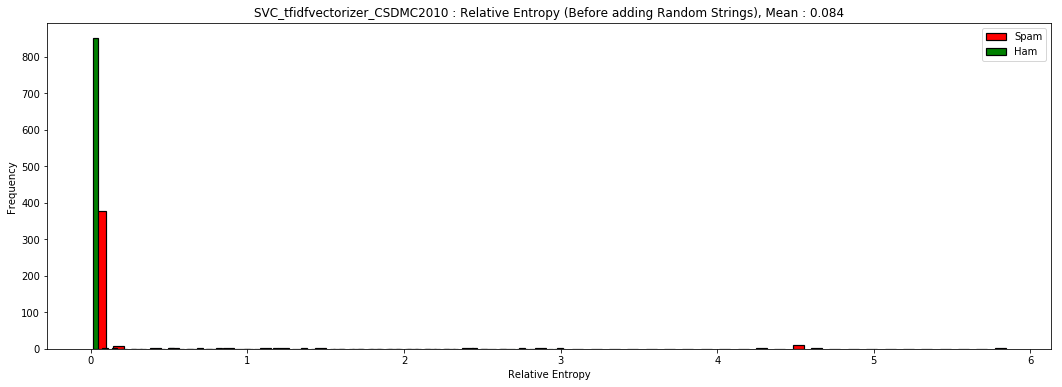

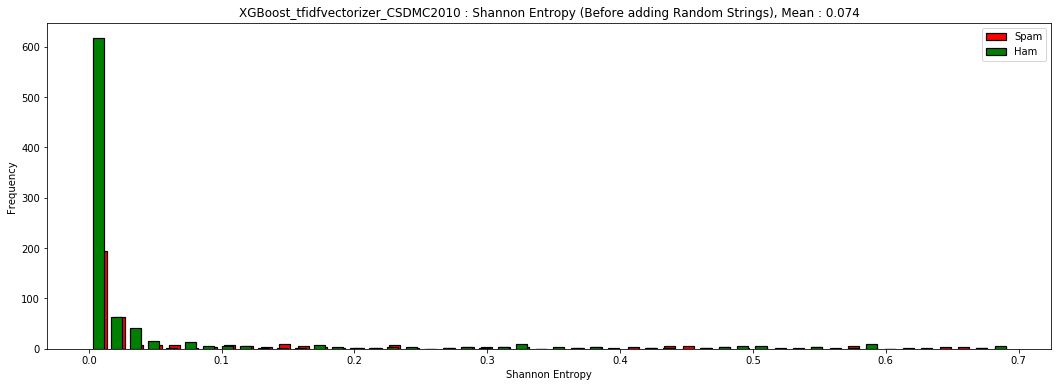

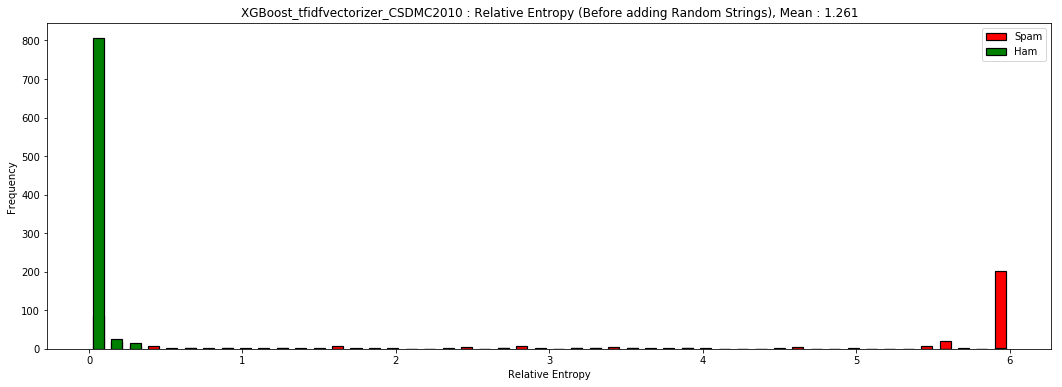

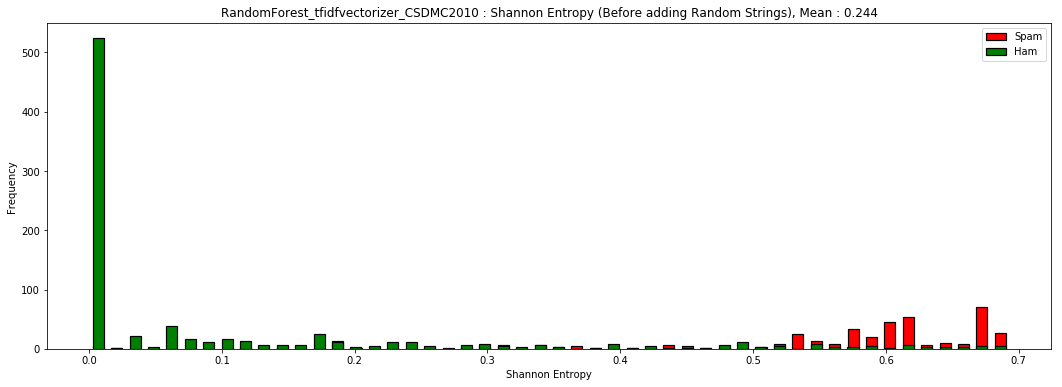

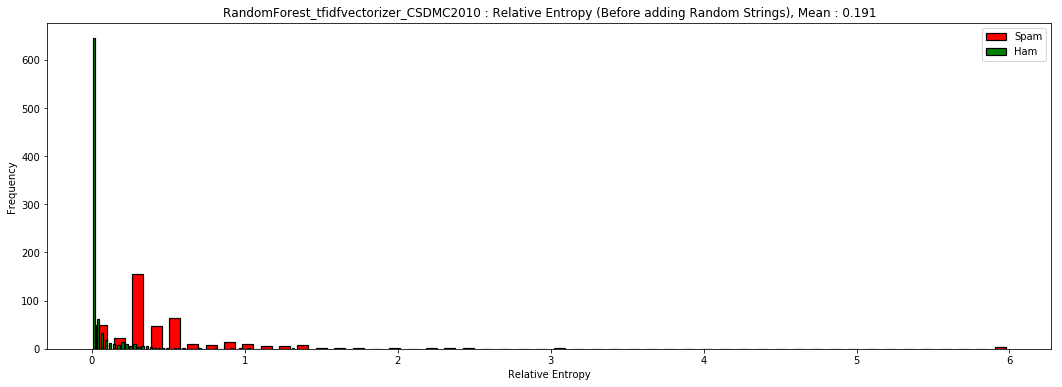

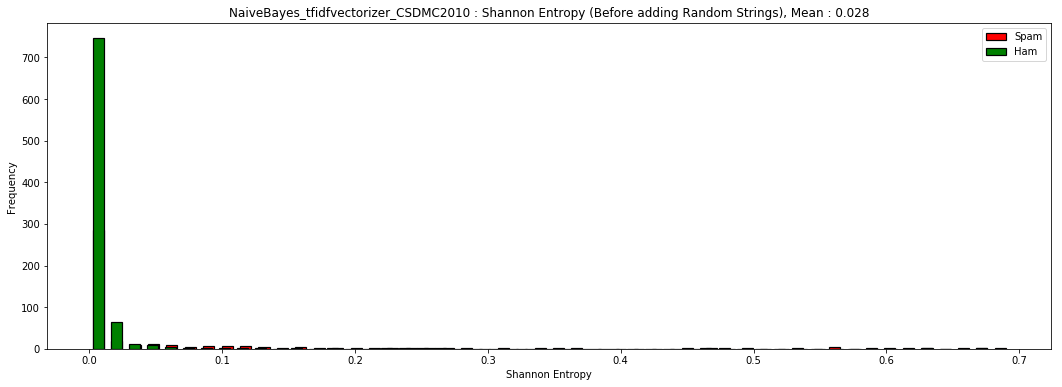

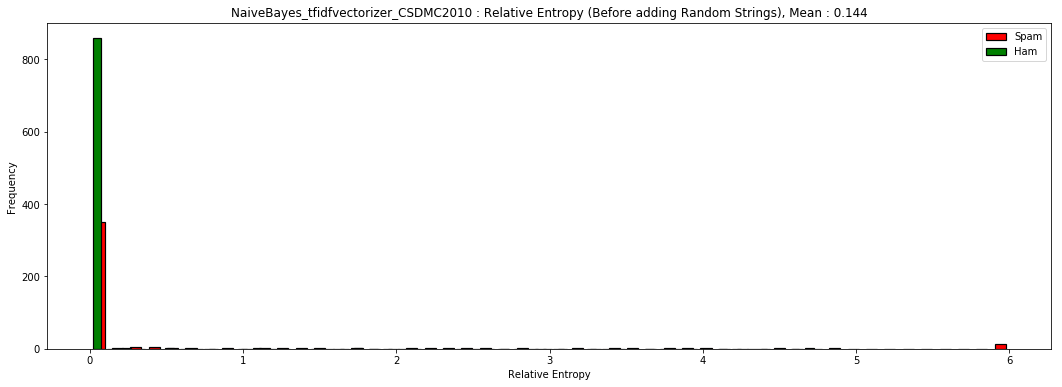

In [37]:
visualise_entropies(dataset, test_x_cleaned, y_test, 'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.6772340453803287
ROC AUC :  0.9959050051187437
Accuracy :  0.9803921568627451
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       863
         1.0       0.99      0.95      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.97      0.98      1275
weighted avg       0.98      0.98      0.98      1275



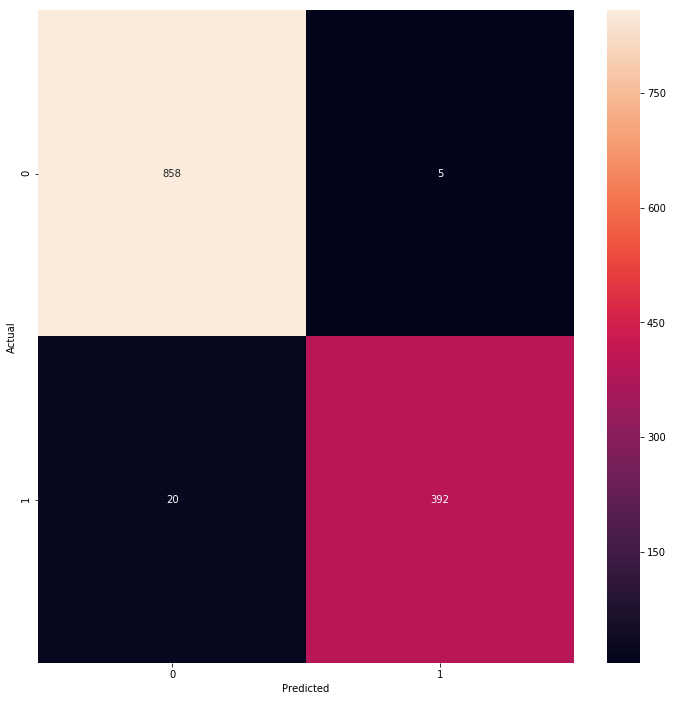

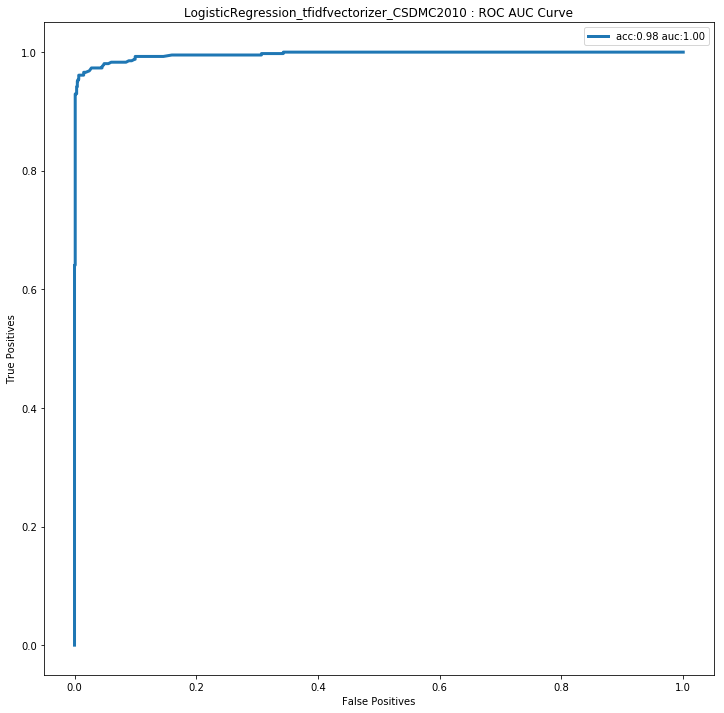

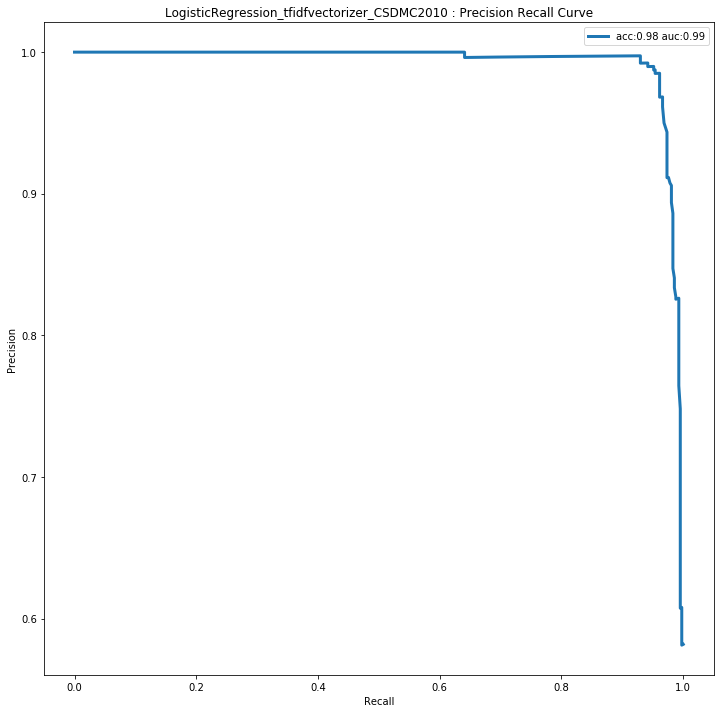

********************************************************************************
SVC_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.8126814815916338
ROC AUC :  0.9916862603921746
Accuracy :  0.9764705882352941
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       863
         1.0       0.98      0.94      0.96       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.97      0.97      1275
weighted avg       0.98      0.98      0.98      1275



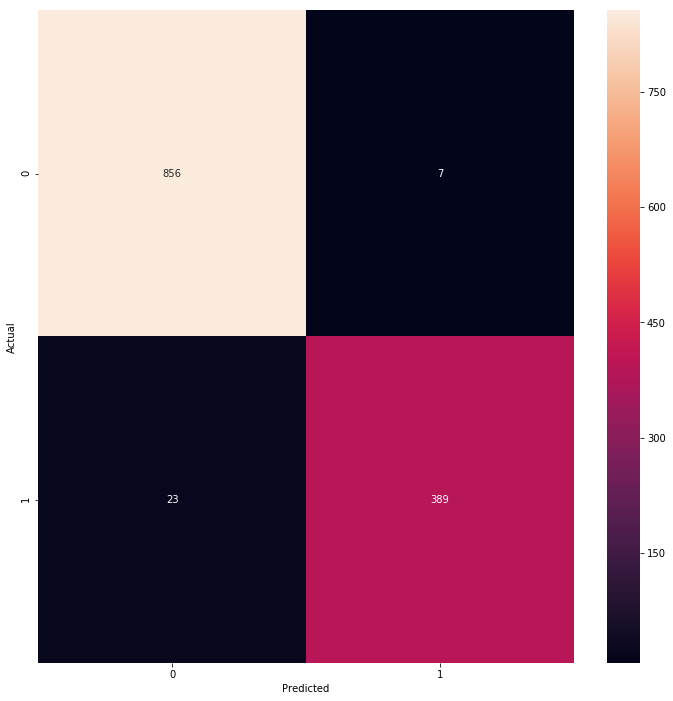

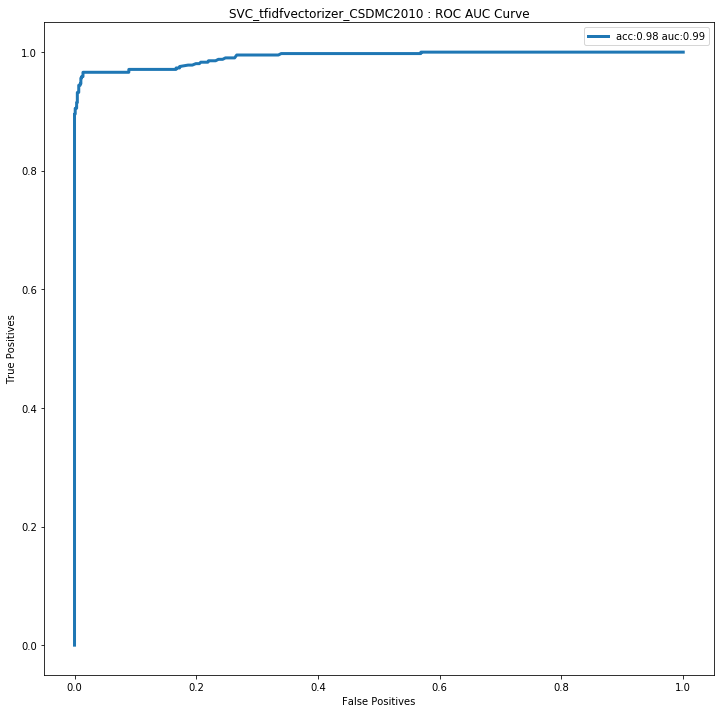

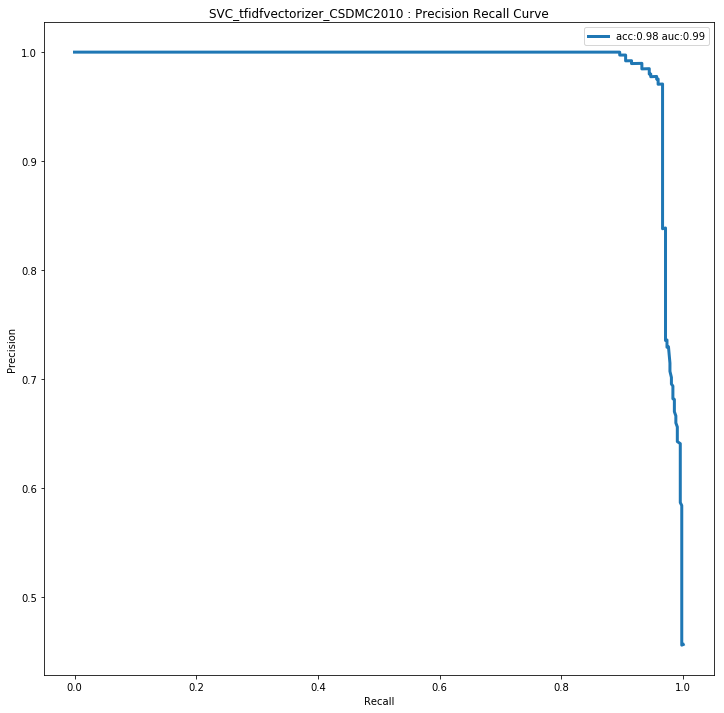

********************************************************************************
XGBoost_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  8.397672687359815
ROC AUC :  0.7602248309689612
Accuracy :  0.7568627450980392
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.74      0.98      0.85       863
         1.0       0.89      0.28      0.43       412

   micro avg       0.76      0.76      0.76      1275
   macro avg       0.81      0.63      0.64      1275
weighted avg       0.79      0.76      0.71      1275



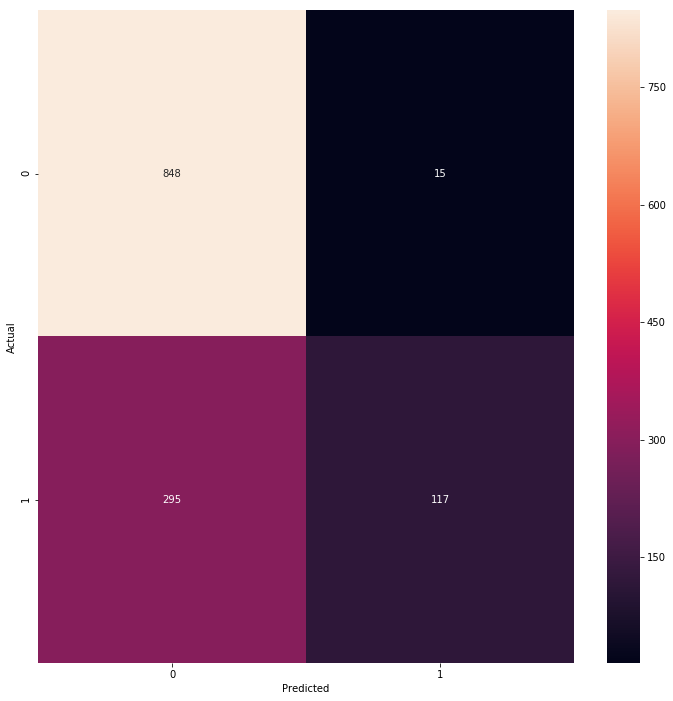

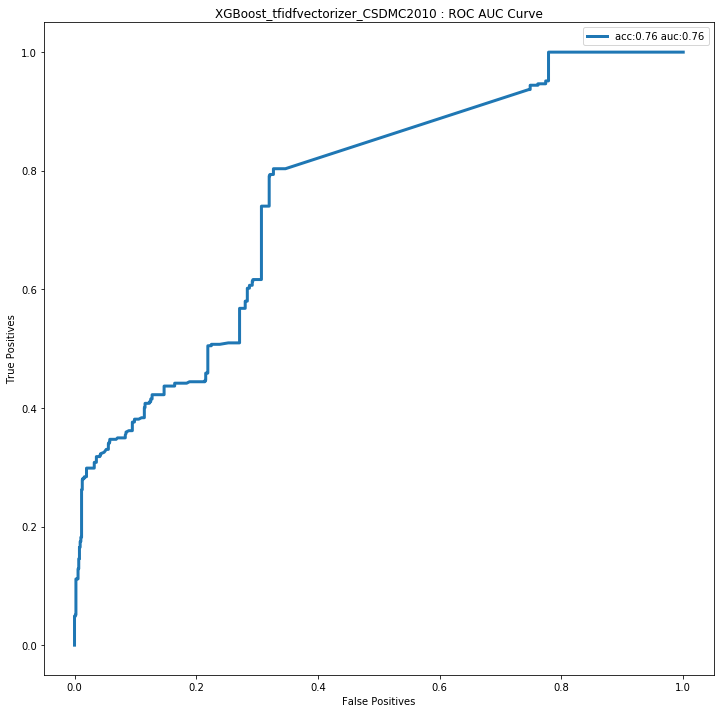

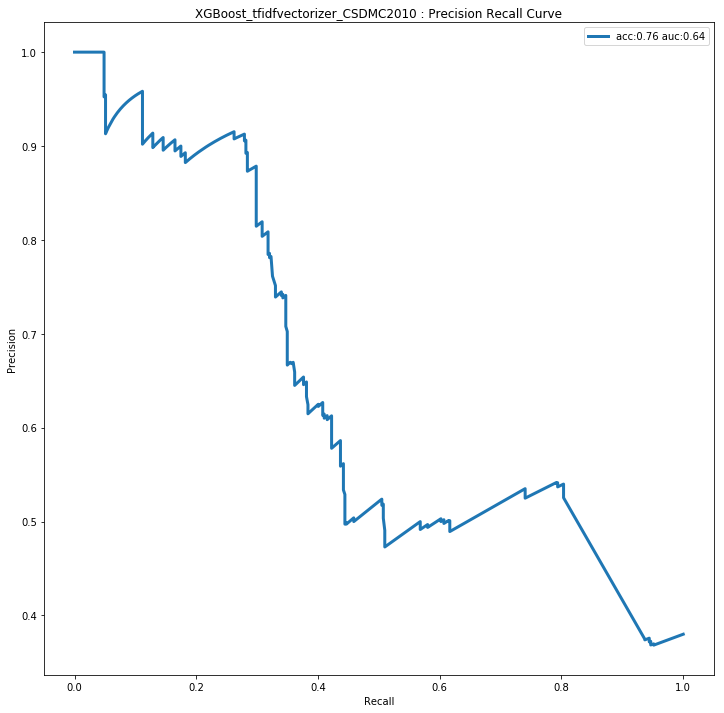

********************************************************************************
RandomForest_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  1.9775192734179783
ROC AUC :  0.988643139196076
Accuracy :  0.9427450980392157
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       863
         1.0       0.98      0.84      0.90       412

   micro avg       0.94      0.94      0.94      1275
   macro avg       0.95      0.92      0.93      1275
weighted avg       0.94      0.94      0.94      1275



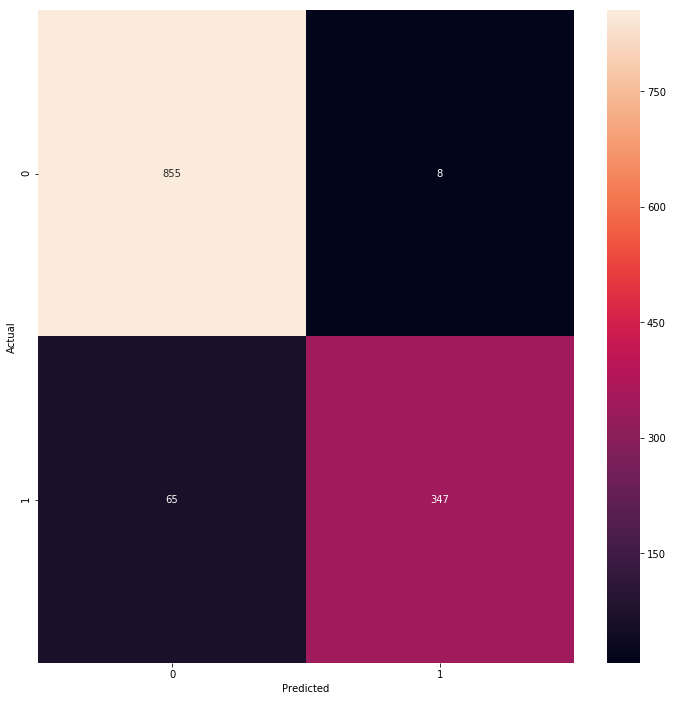

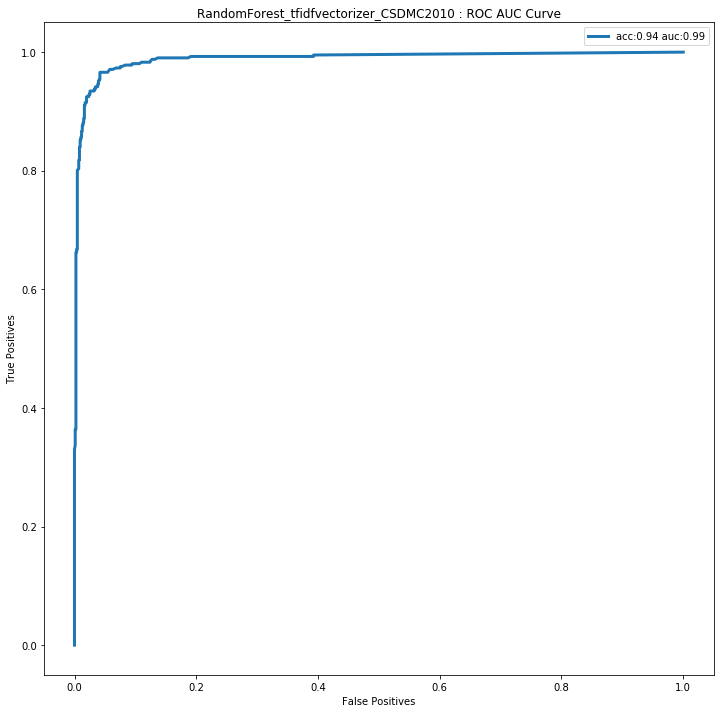

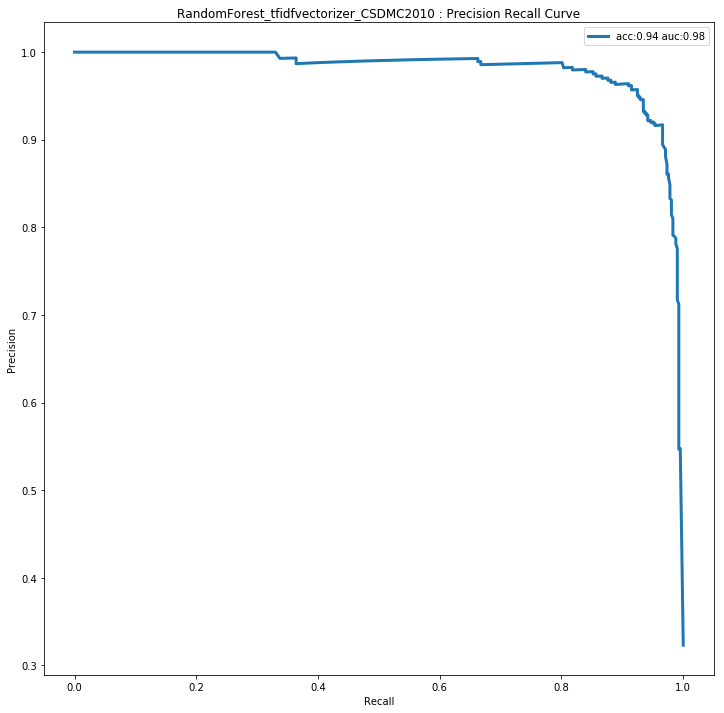

********************************************************************************
NaiveBayes_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  1.3002852280376505
ROC AUC :  0.9918606351742061
Accuracy :  0.9623529411764706
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       863
         1.0       0.99      0.89      0.94       412

   micro avg       0.96      0.96      0.96      1275
   macro avg       0.97      0.94      0.96      1275
weighted avg       0.96      0.96      0.96      1275



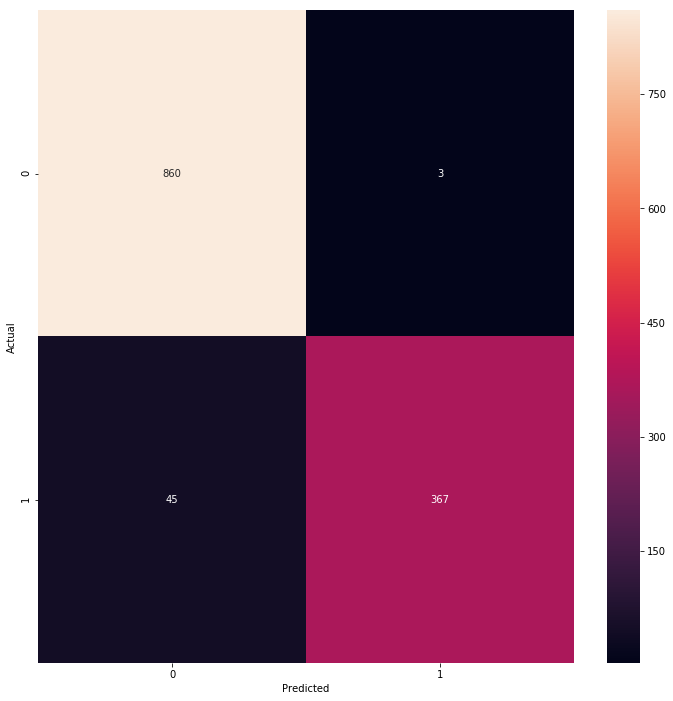

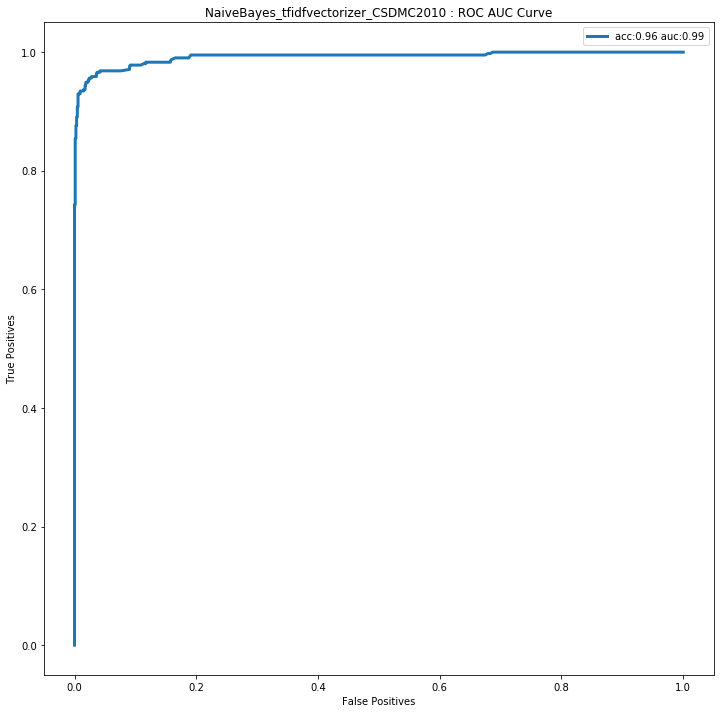

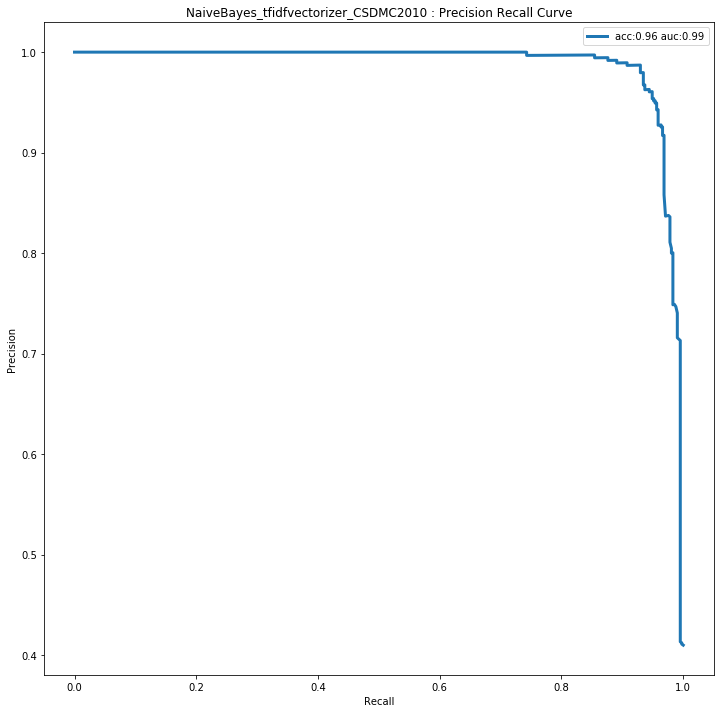

In [38]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cleaned, y_test)

## Adding Meaningful Strings to Test Data

In [39]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.05604999781143931
Mean Relative Entropy :  0.06224550539832819
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
74     0.555     1.411     1.0     0.0       0.756       0.244
97     0.516     1.555     1.0     0.0       0.789       0.211
137    0.192     3.044     1.0     0.0       0.952       0.048
144    0.278     2.531     1.0     0.0       0.920       0.080
151    0.521     1.536     1.0     0.0       0.785       0.215
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
585     0.692     0.731     0.0     1.0   4.814e-01       0.519
613     0.007     6.000     0.0     1.0   9.247e-04       0.999
1063    0.611     1.205     0.0     1.0   2.997e-01       0.700
1078    0.445     1.812     0.0     1.0   1.634e-0

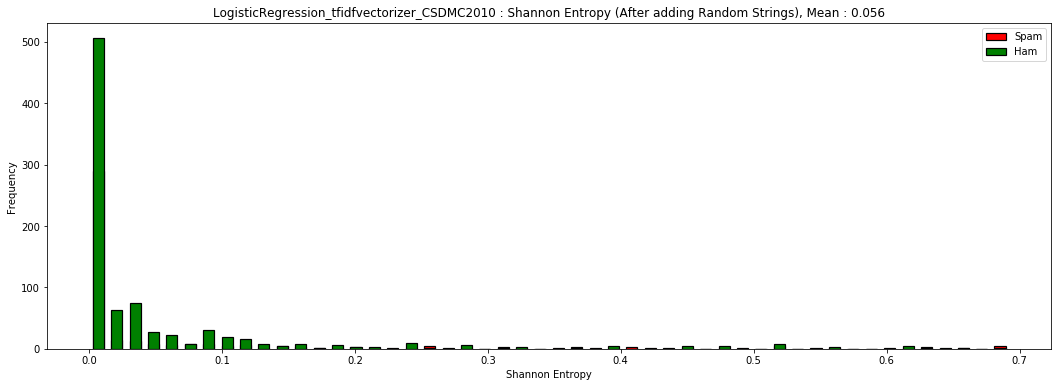

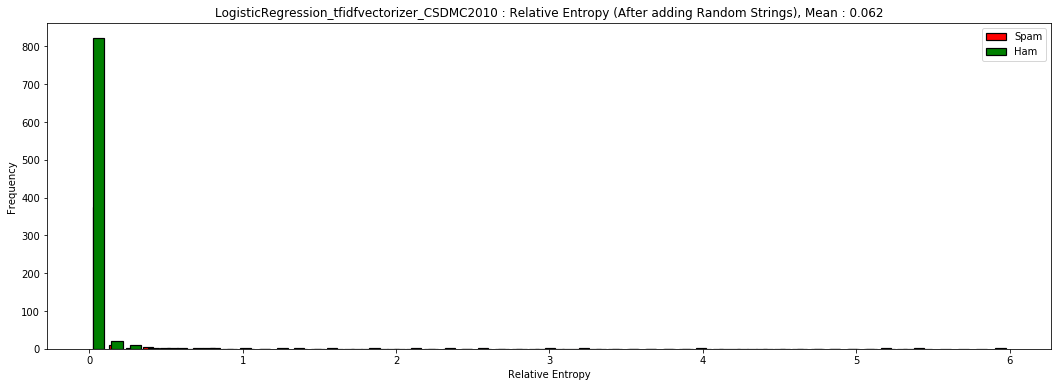

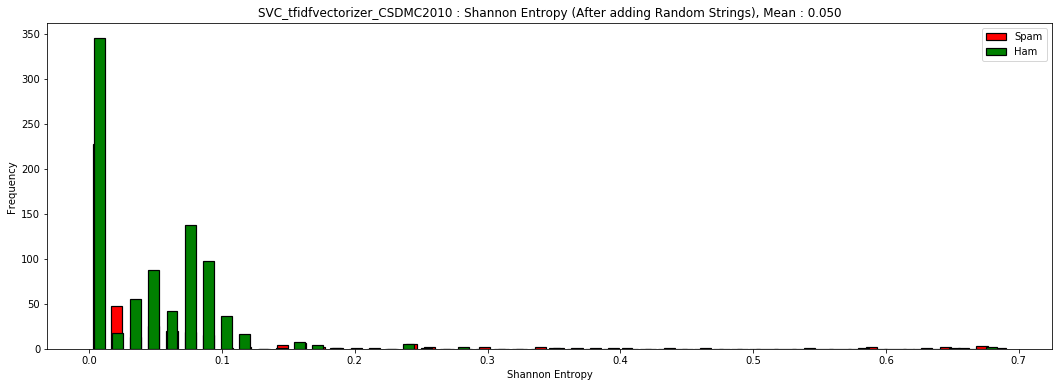

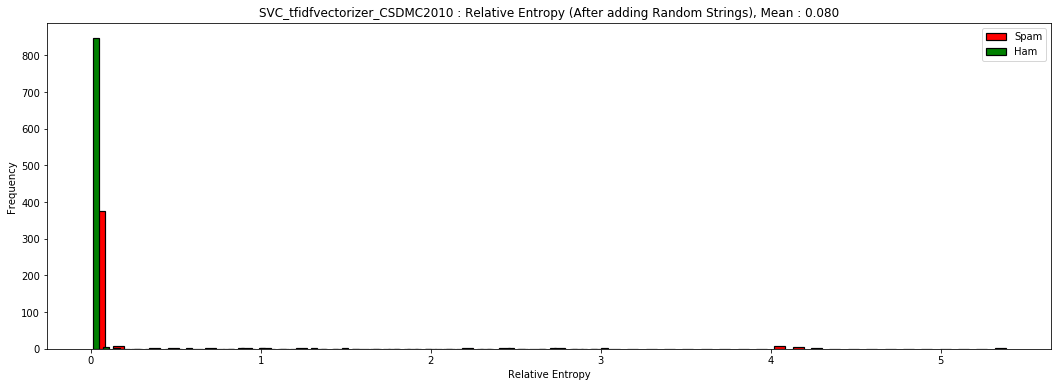

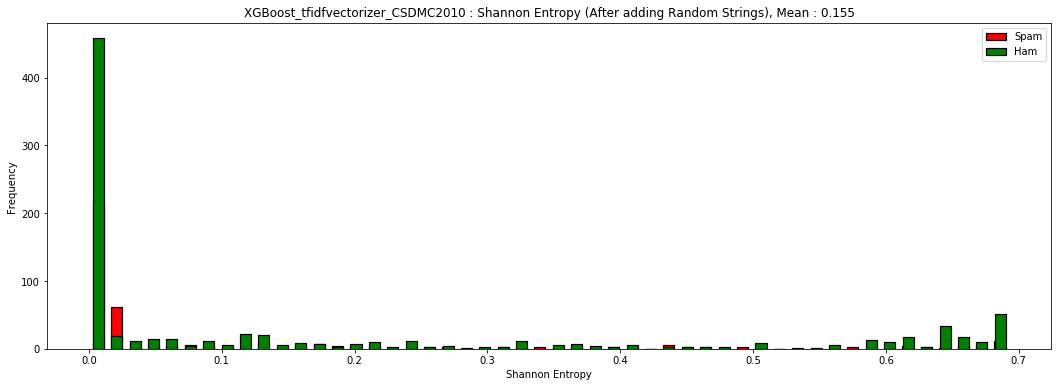

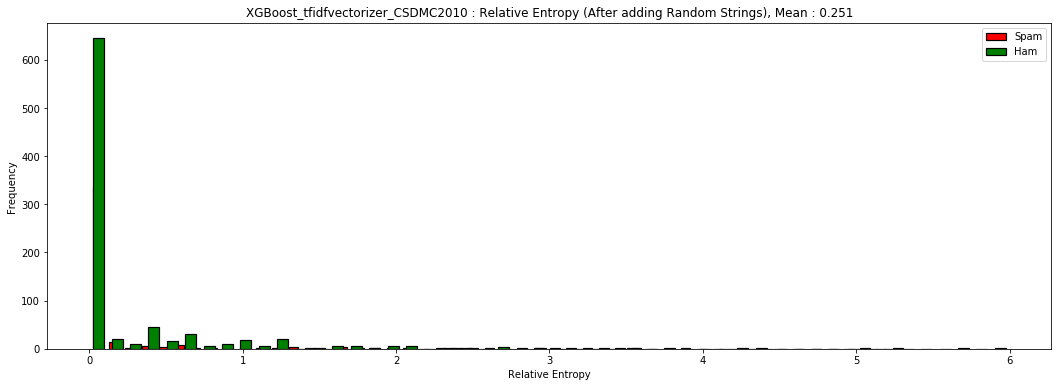

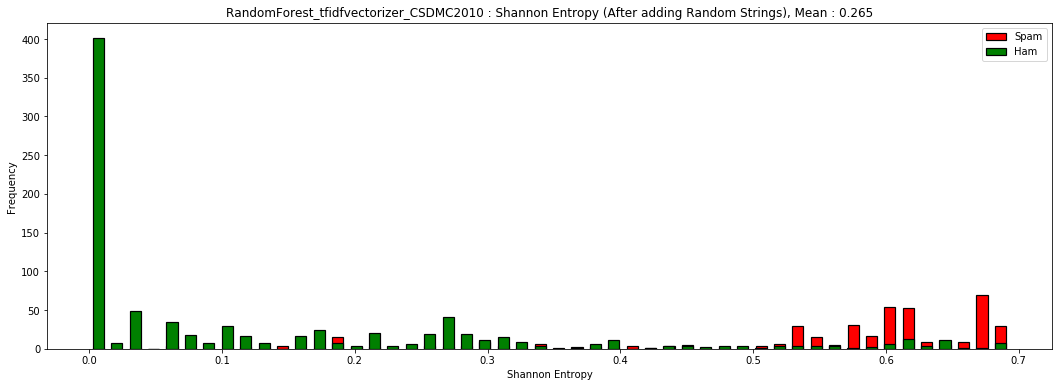

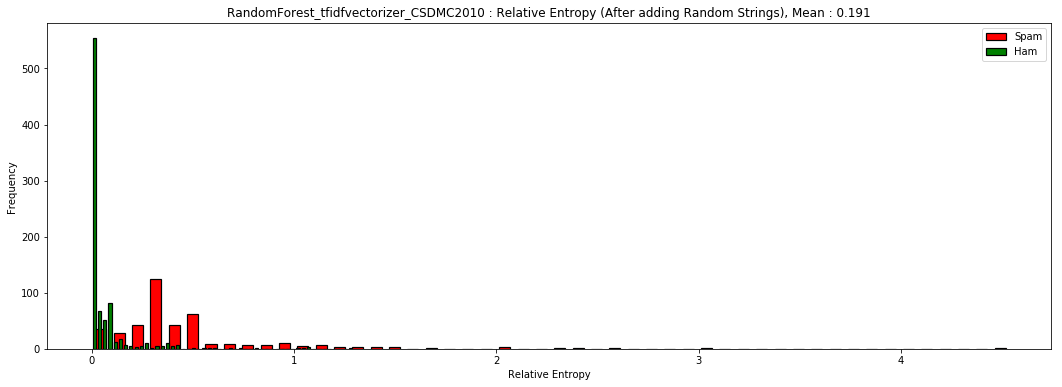

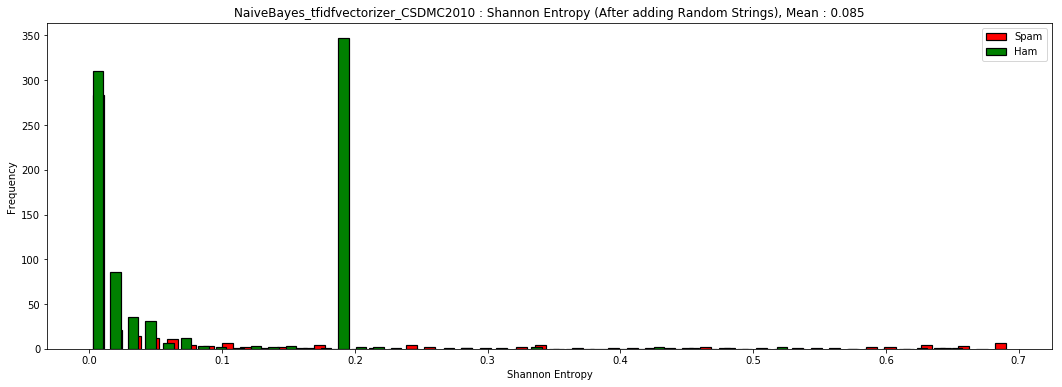

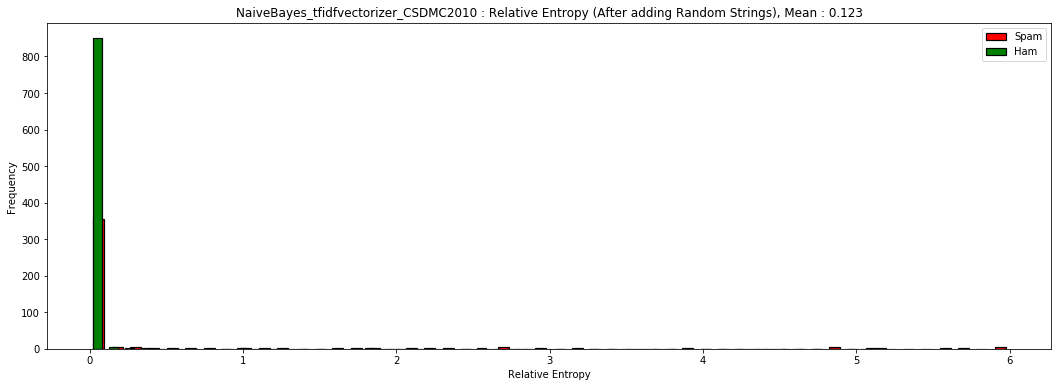

In [40]:
visualise_entropies(dataset, test_x_with_random_strings, y_test, 'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.6501454361274028
ROC AUC :  0.9959809425238219
Accuracy :  0.9811764705882353
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       863
         1.0       0.98      0.96      0.97       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.97      0.98      1275
weighted avg       0.98      0.98      0.98      1275



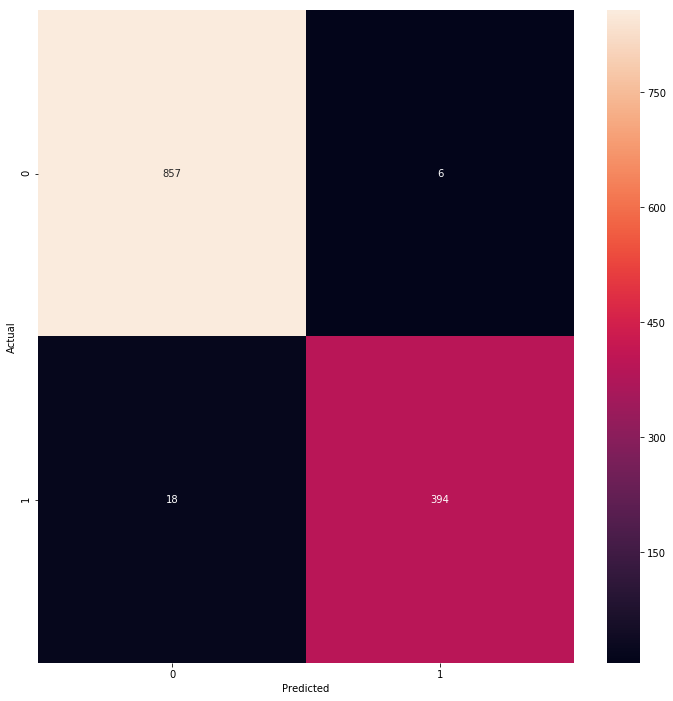

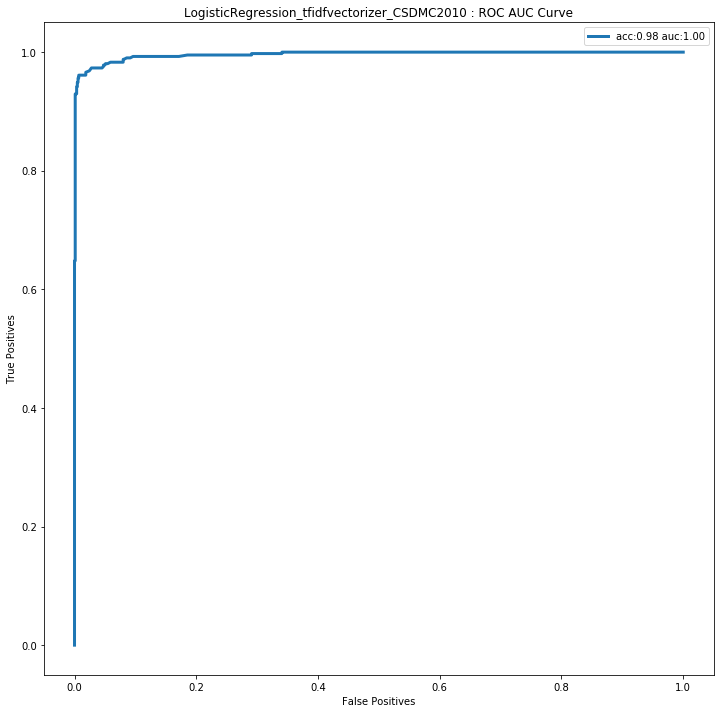

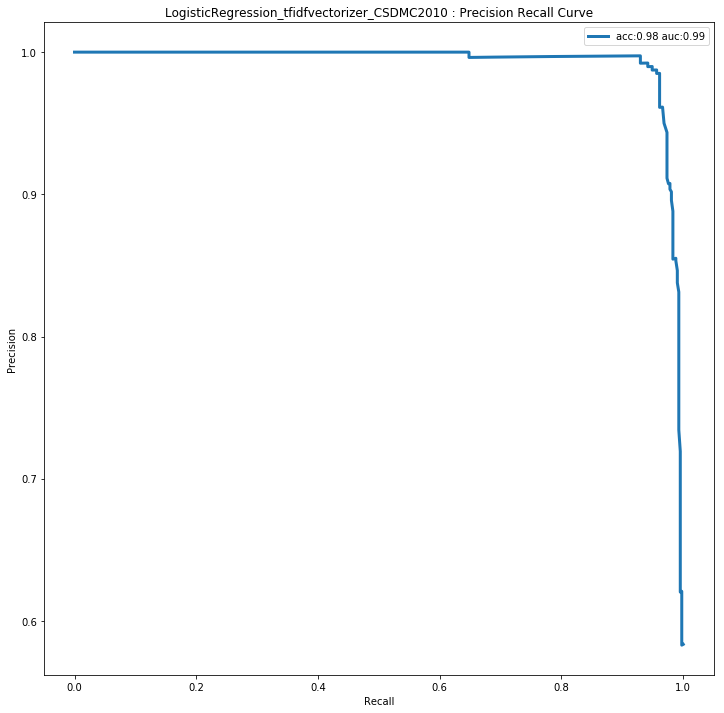

********************************************************************************
SVC_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  0.8397713451150384
ROC AUC :  0.9916412604484245
Accuracy :  0.9756862745098039
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       863
         1.0       0.98      0.94      0.96       412

   micro avg       0.98      0.98      0.98      1275
   macro avg       0.98      0.97      0.97      1275
weighted avg       0.98      0.98      0.98      1275



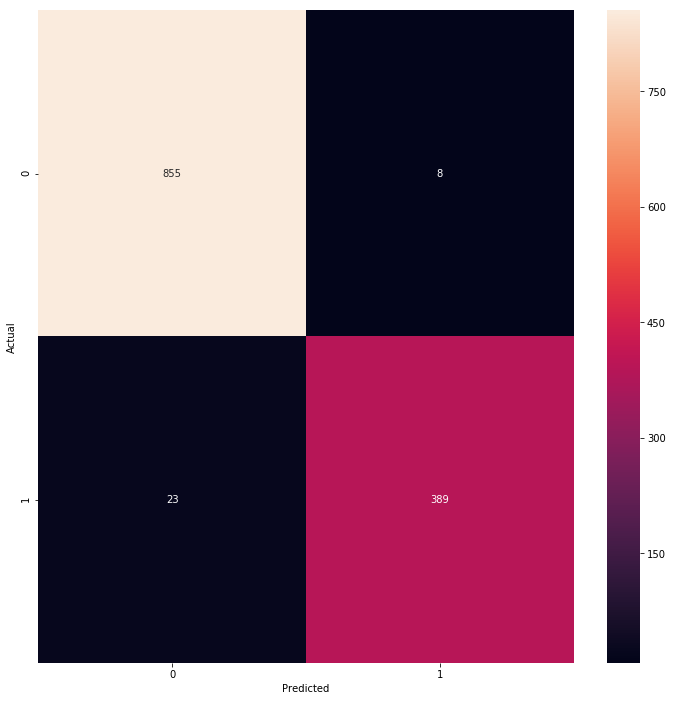

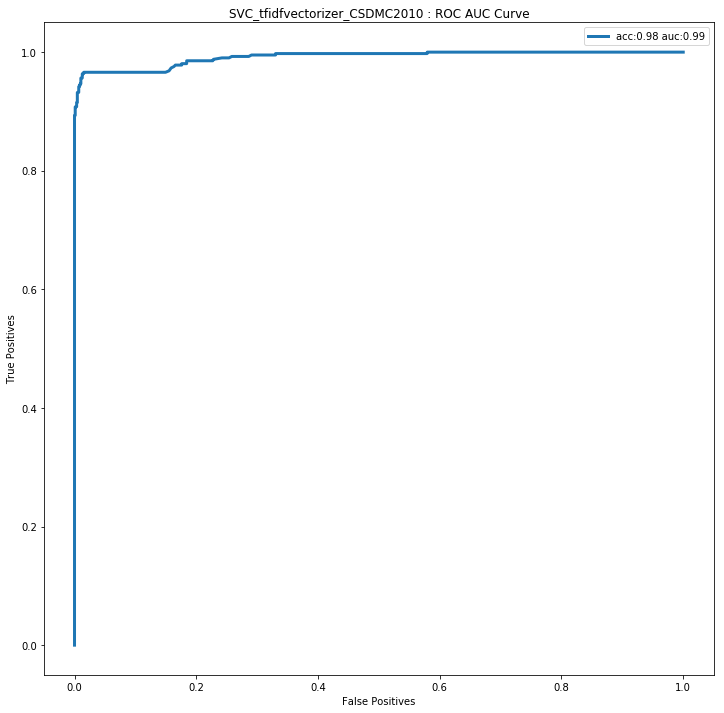

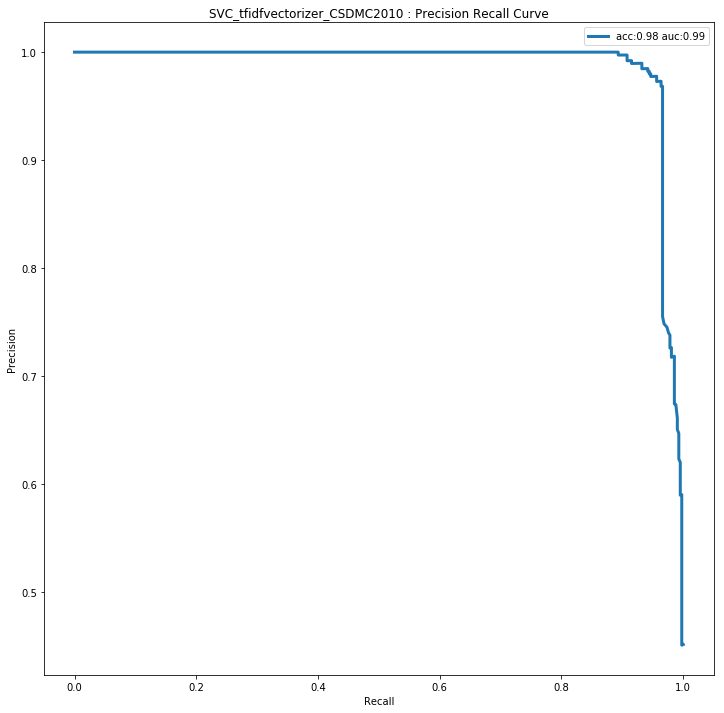

********************************************************************************
XGBoost_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  3.76546343580271
ROC AUC :  0.9674369157038554
Accuracy :  0.8909803921568628
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       863
         1.0       0.79      0.89      0.84       412

   micro avg       0.89      0.89      0.89      1275
   macro avg       0.87      0.89      0.88      1275
weighted avg       0.90      0.89      0.89      1275



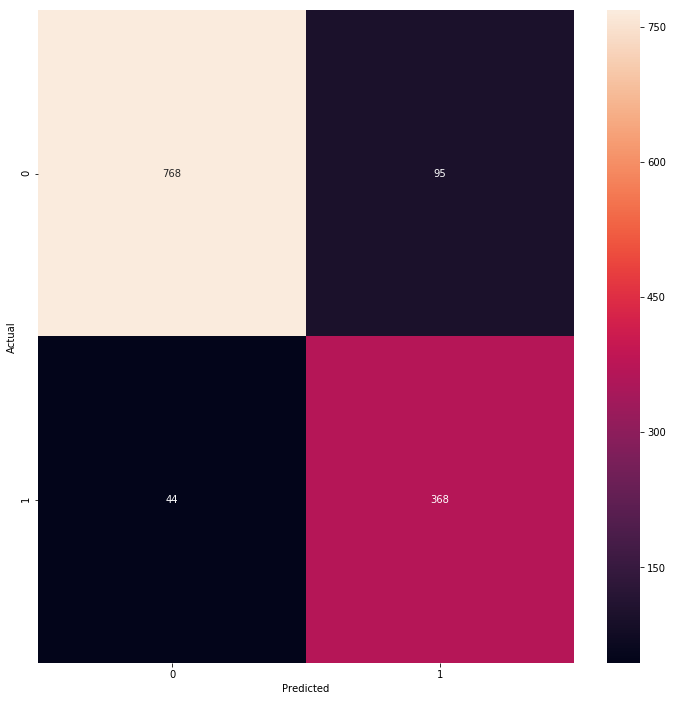

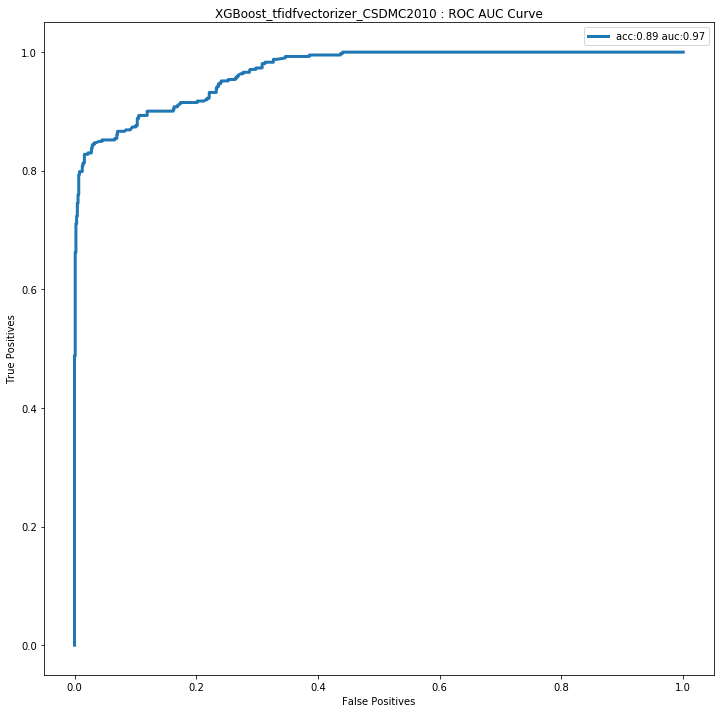

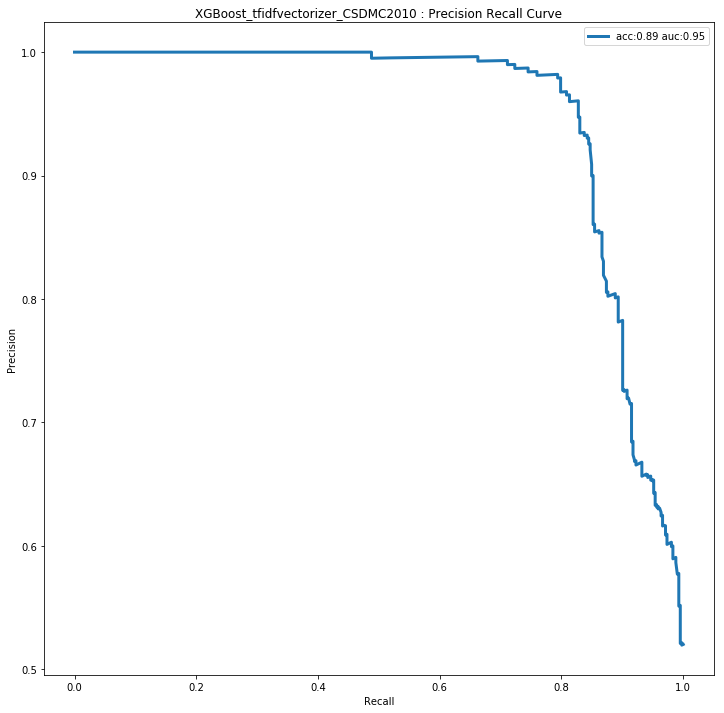

********************************************************************************
RandomForest_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  1.9775192734179783
ROC AUC :  0.9900198562251799
Accuracy :  0.9427450980392157
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       863
         1.0       0.98      0.84      0.90       412

   micro avg       0.94      0.94      0.94      1275
   macro avg       0.95      0.92      0.93      1275
weighted avg       0.94      0.94      0.94      1275



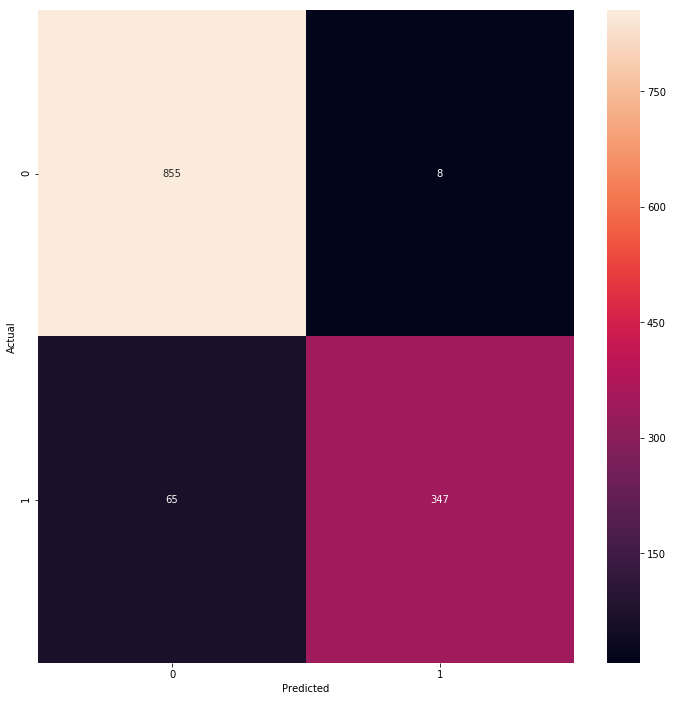

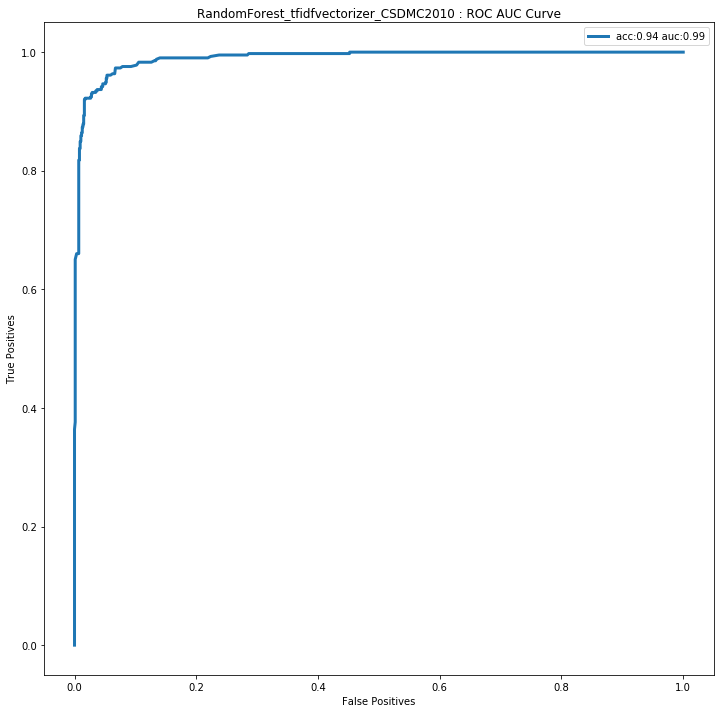

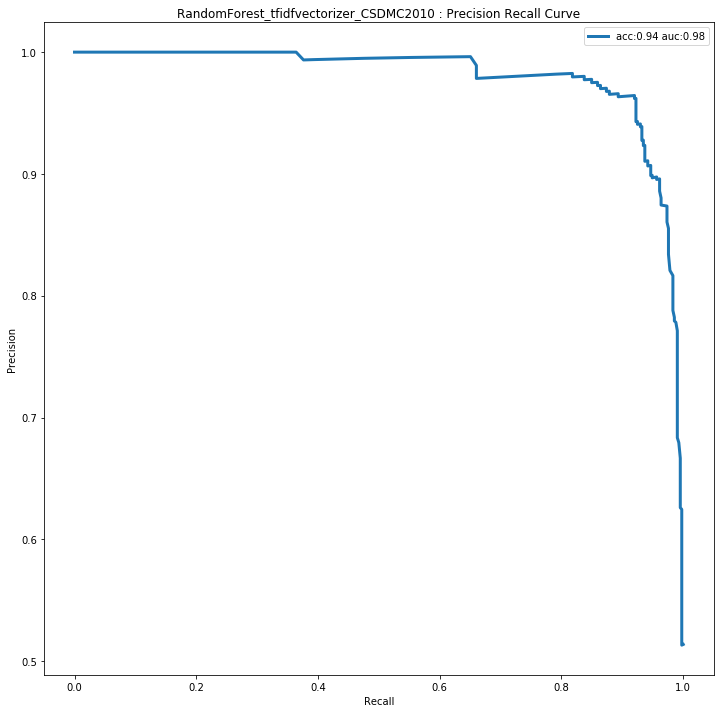

********************************************************************************
NaiveBayes_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  1.1648396732320638
ROC AUC :  0.9794462756921554
Accuracy :  0.9662745098039216
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       863
         1.0       0.99      0.91      0.95       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.95      0.96      1275
weighted avg       0.97      0.97      0.97      1275



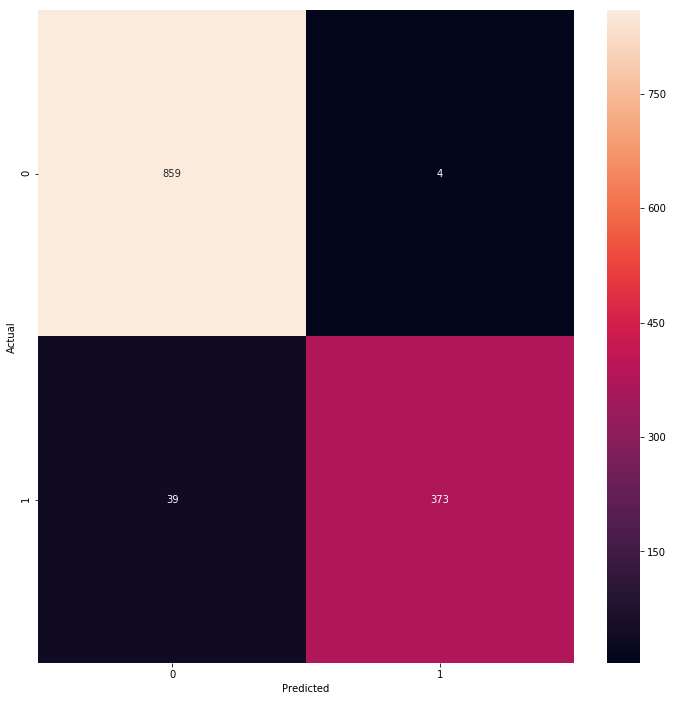

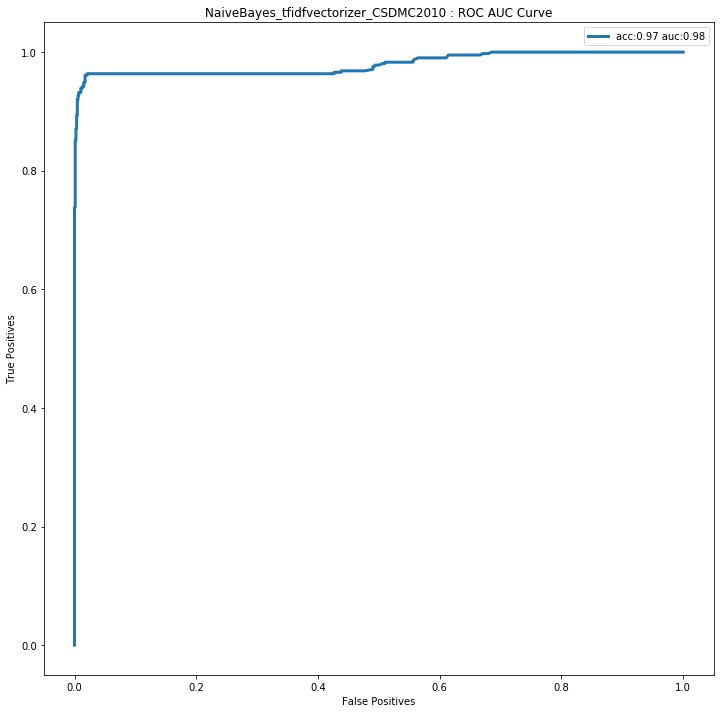

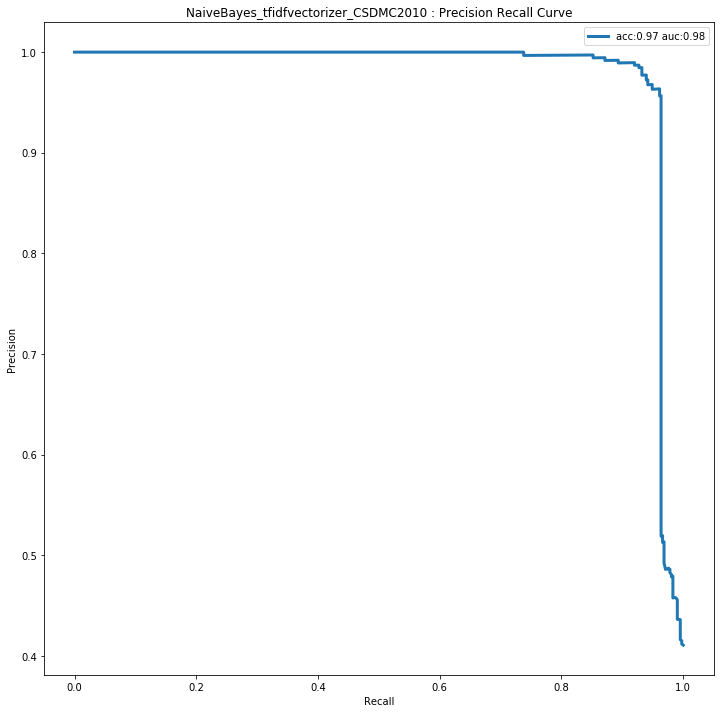

In [41]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [42]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.589392863239366
Mean Relative Entropy :  0.9751888763552298
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
412    0.589     1.286     0.0     1.0       0.276       0.724
413    0.589     1.286     0.0     1.0       0.276       0.724
414    0.589     1.286     0.0     1.0       0.276       0.724
415    0.589     1.286     0.0     1.0       0.276       0.724
416    0.589     1.286     0.0     1.0       0.276       0.724
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1270    0.589     1.286     0.0     1.0       0.276       0.724
1271    0.589     1.286     0.0     1.0       0.276       0.724
1272    0.589     1.286     0.0     1.0       0.276       0.724
1273    0.589     1.286     0.0     1.0       0.276  

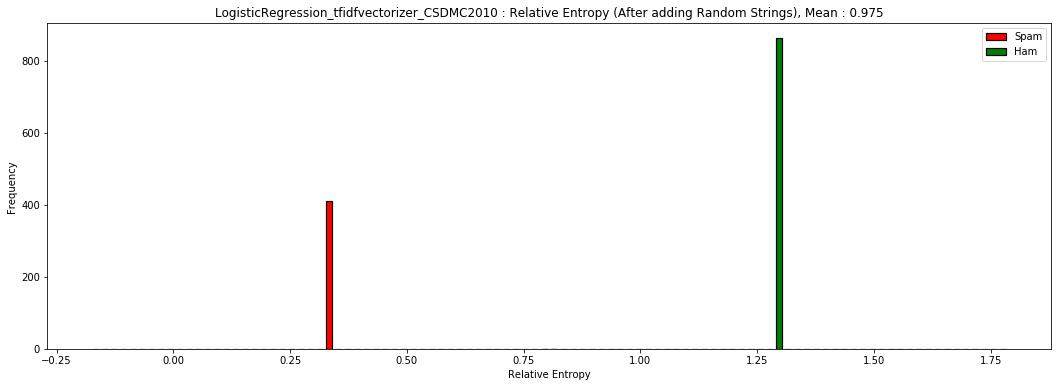

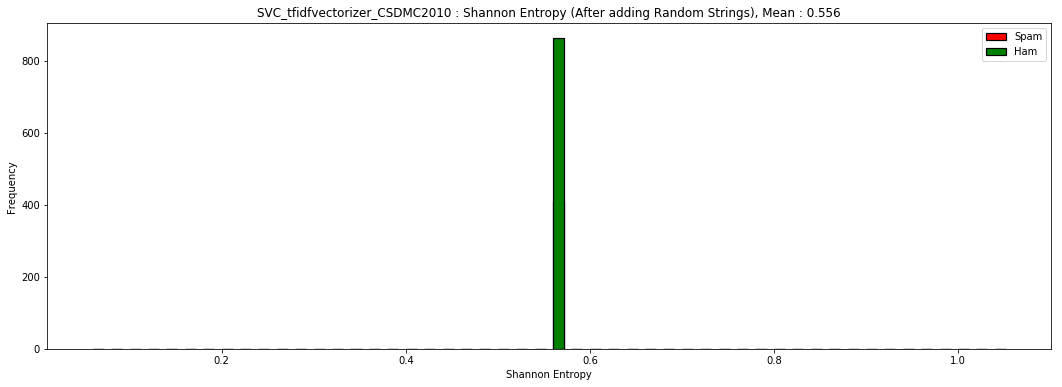

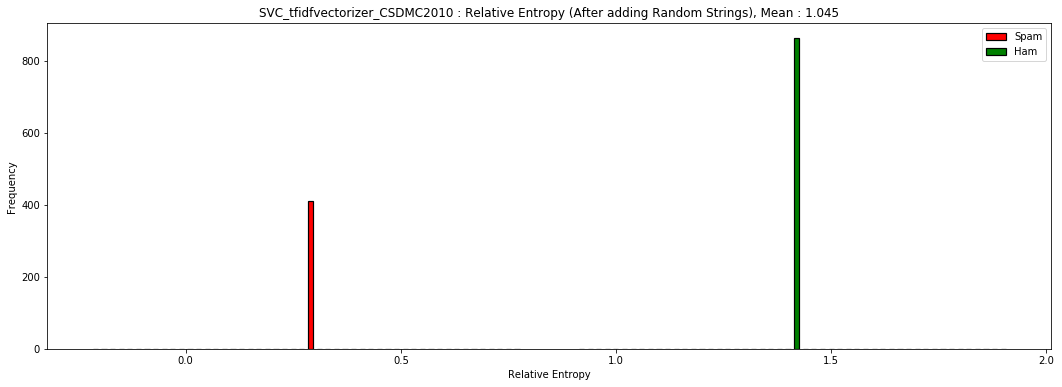

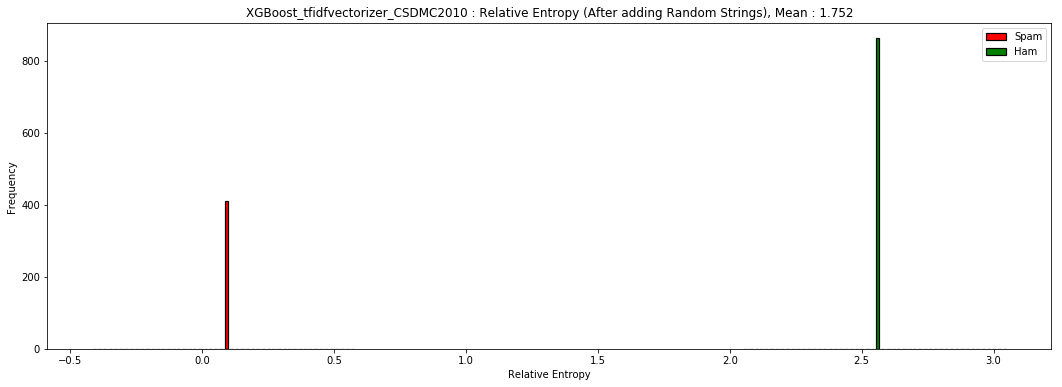

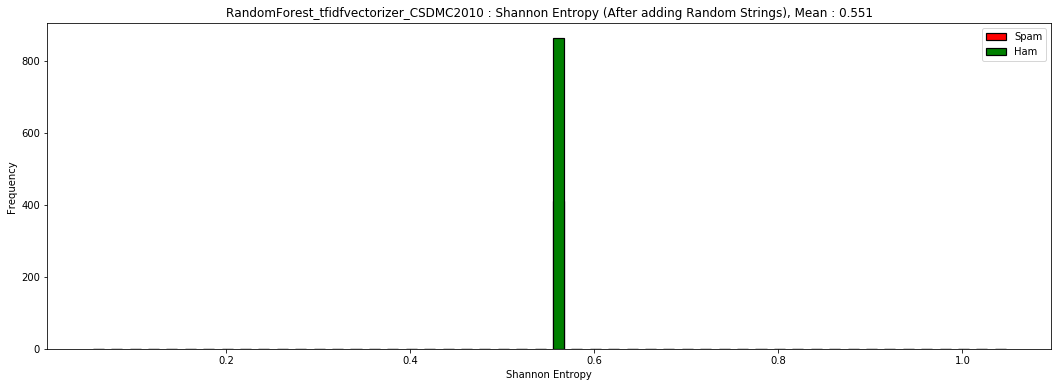

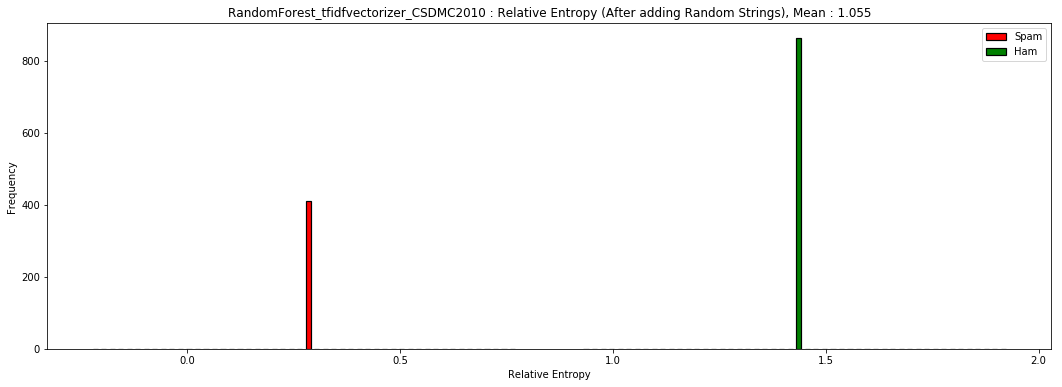

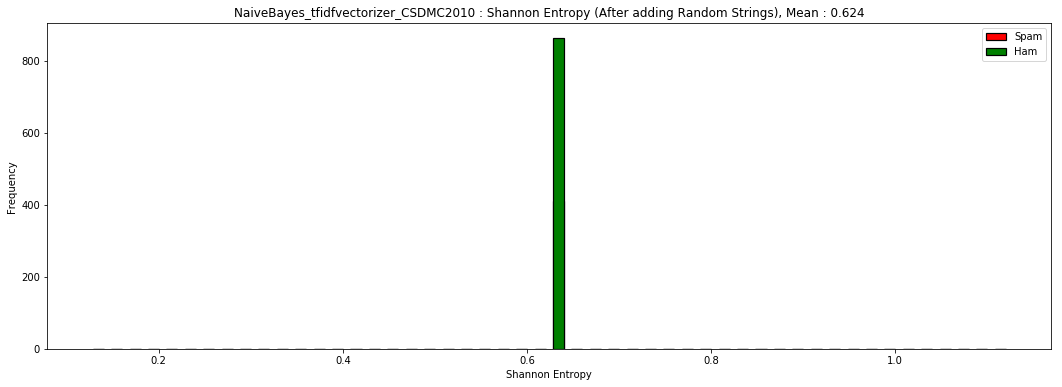

In [43]:
visualise_entropies(dataset, test_x_with_random_strings, y_test, 'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



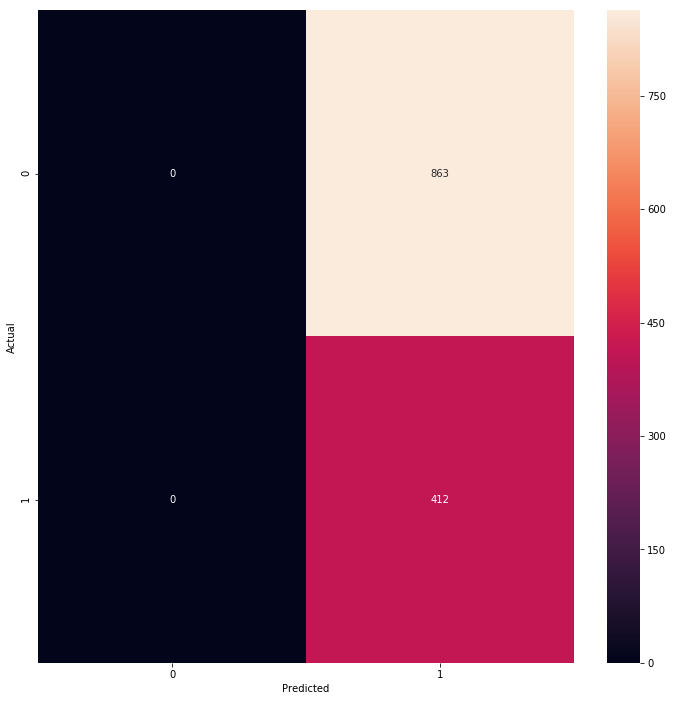

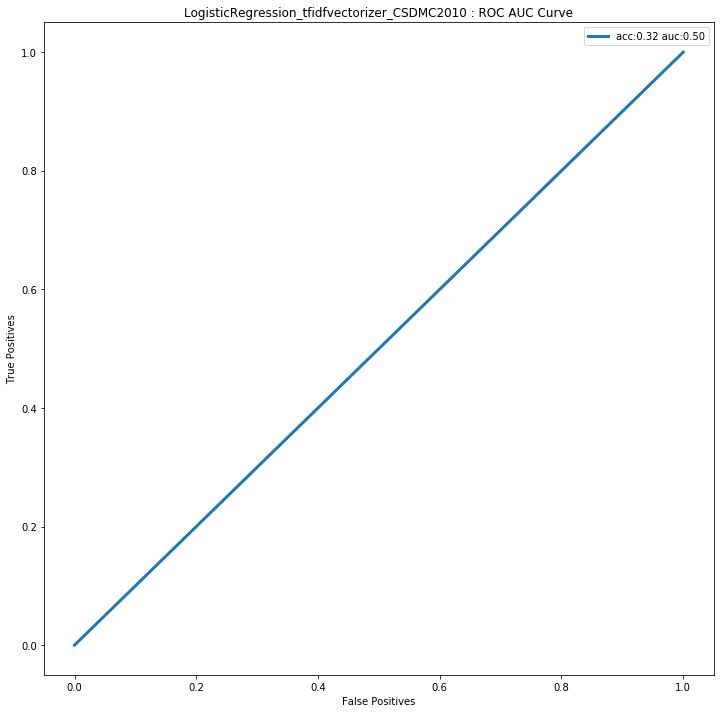

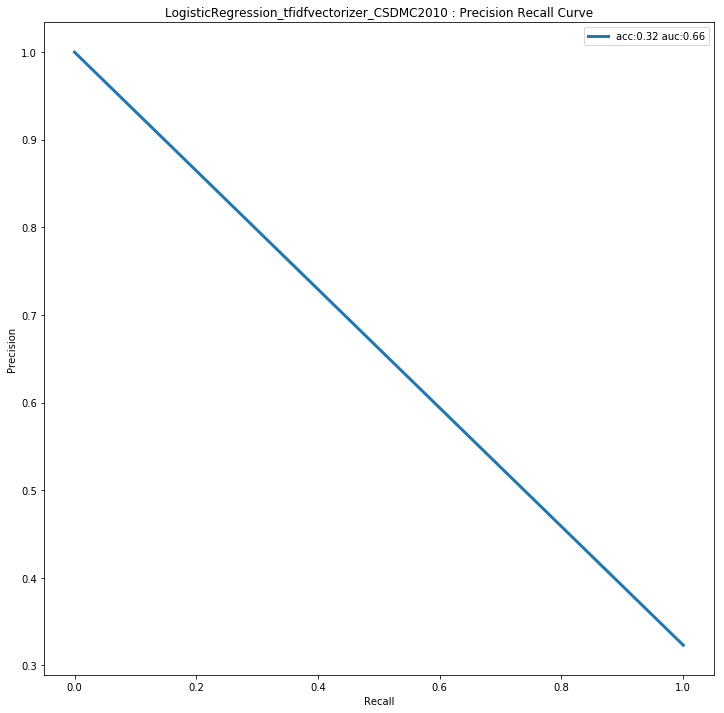

********************************************************************************
SVC_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



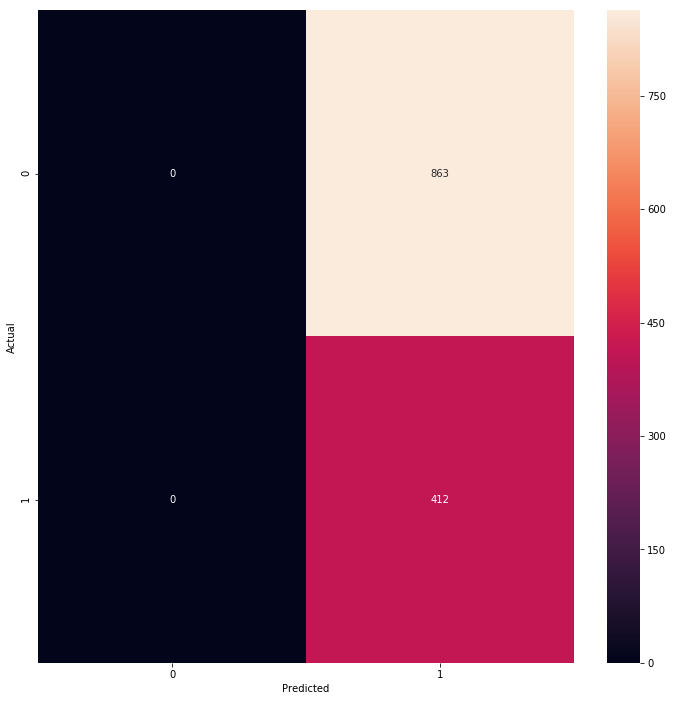

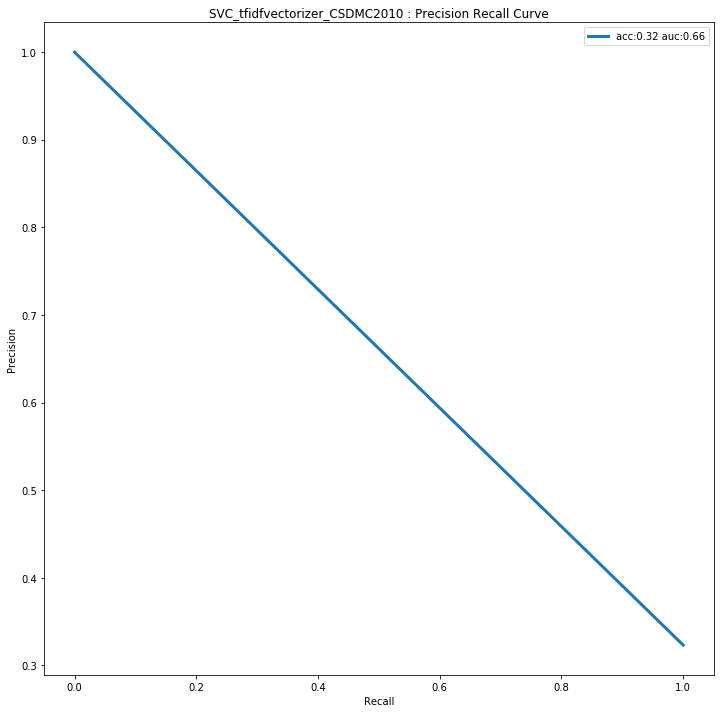

********************************************************************************
XGBoost_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



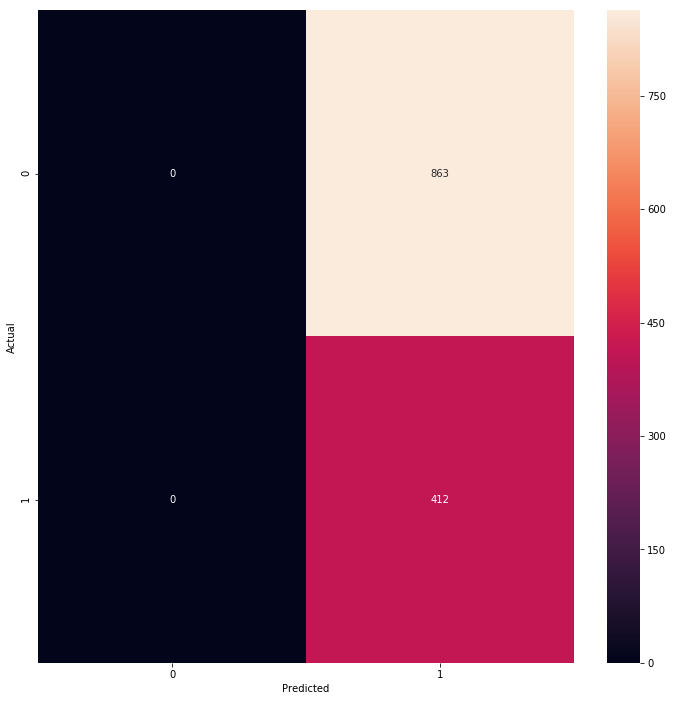

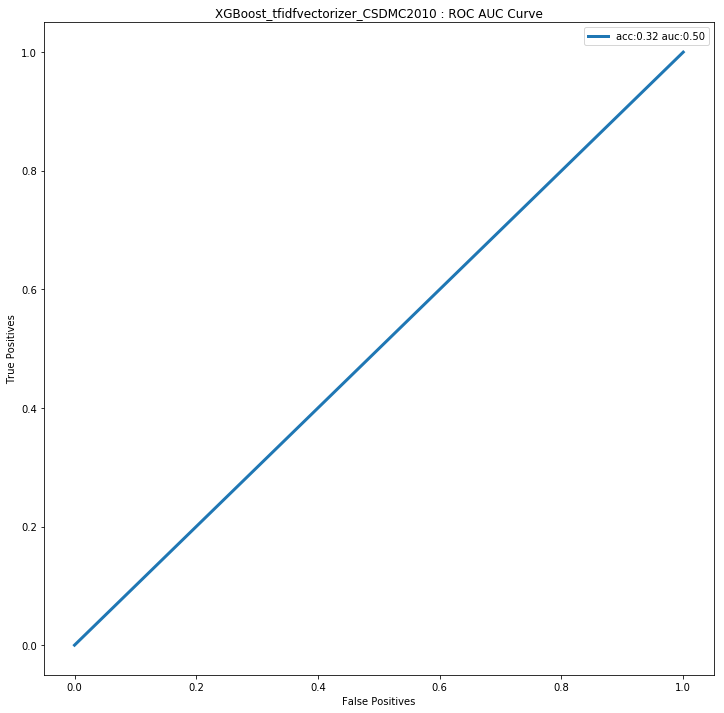

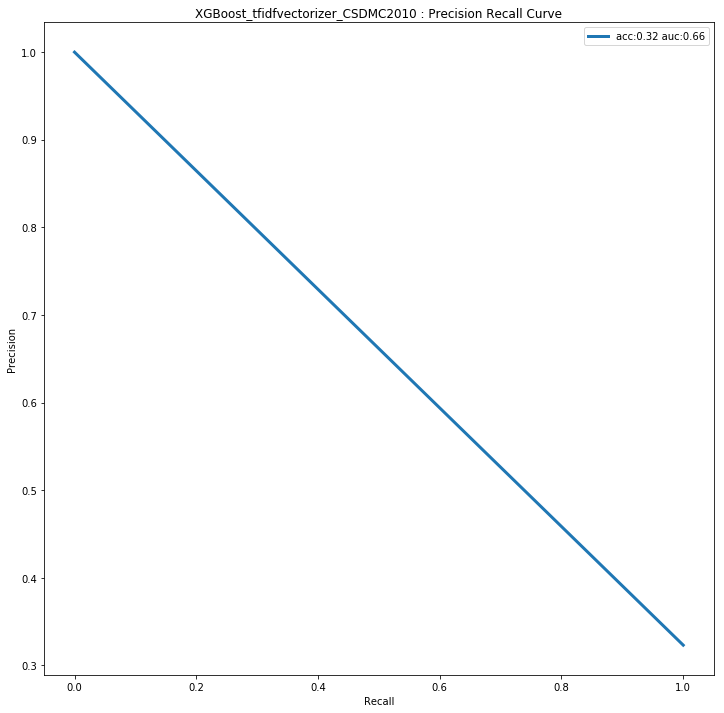

********************************************************************************
RandomForest_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  23.378552220698175
ROC AUC :  0.5
Accuracy :  0.32313725490196077
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.32      1.00      0.49       412

   micro avg       0.32      0.32      0.32      1275
   macro avg       0.16      0.50      0.24      1275
weighted avg       0.10      0.32      0.16      1275



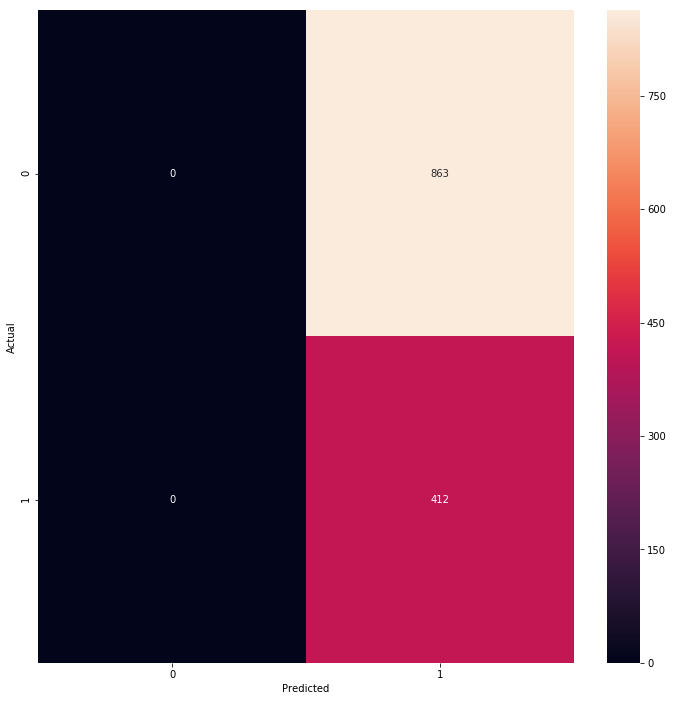

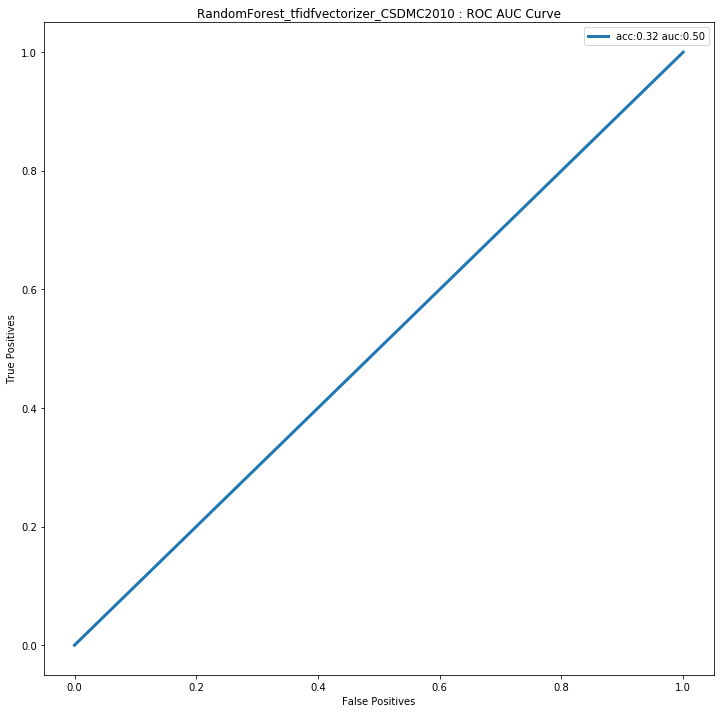

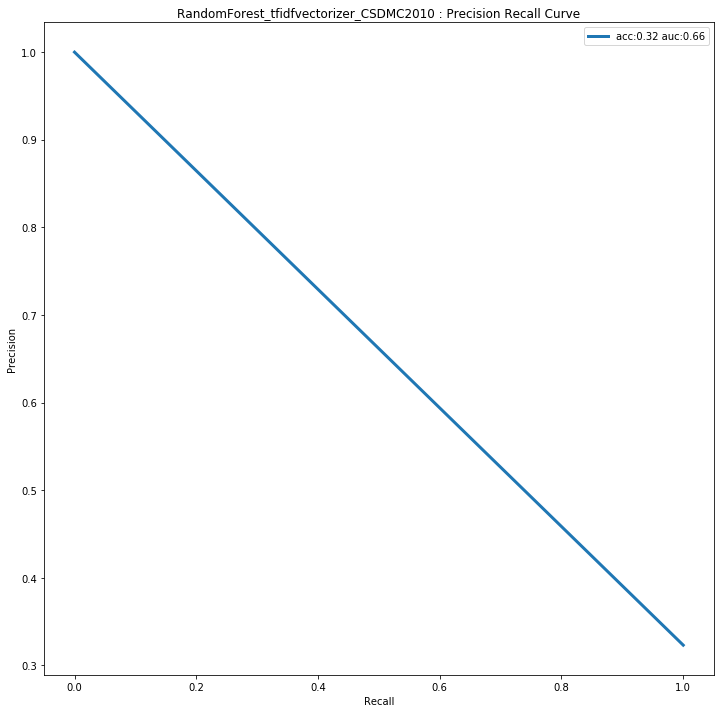

********************************************************************************
NaiveBayes_tfidfvectorizer_CSDMC2010
********************************************************************************
Log Loss :  11.160765391924079
ROC AUC :  0.5
Accuracy :  0.6768627450980392
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81       863
         1.0       0.00      0.00      0.00       412

   micro avg       0.68      0.68      0.68      1275
   macro avg       0.34      0.50      0.40      1275
weighted avg       0.46      0.68      0.55      1275



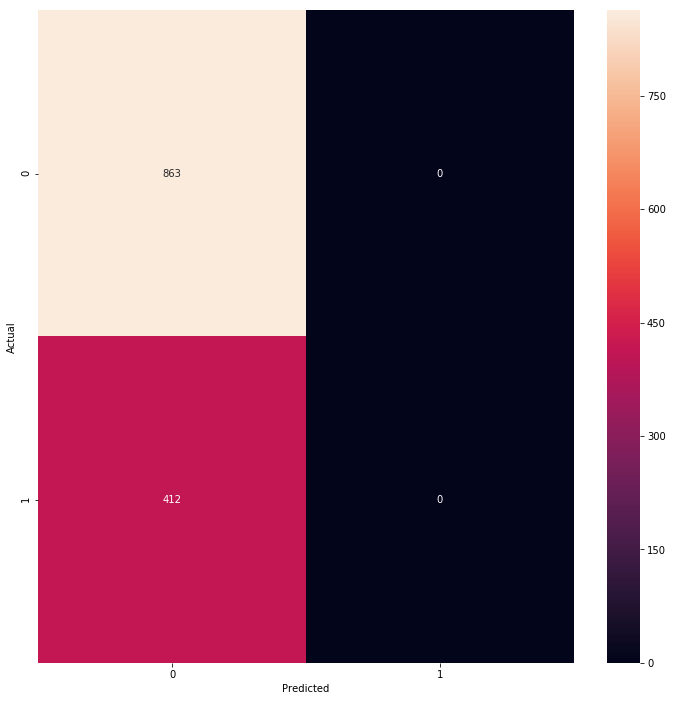

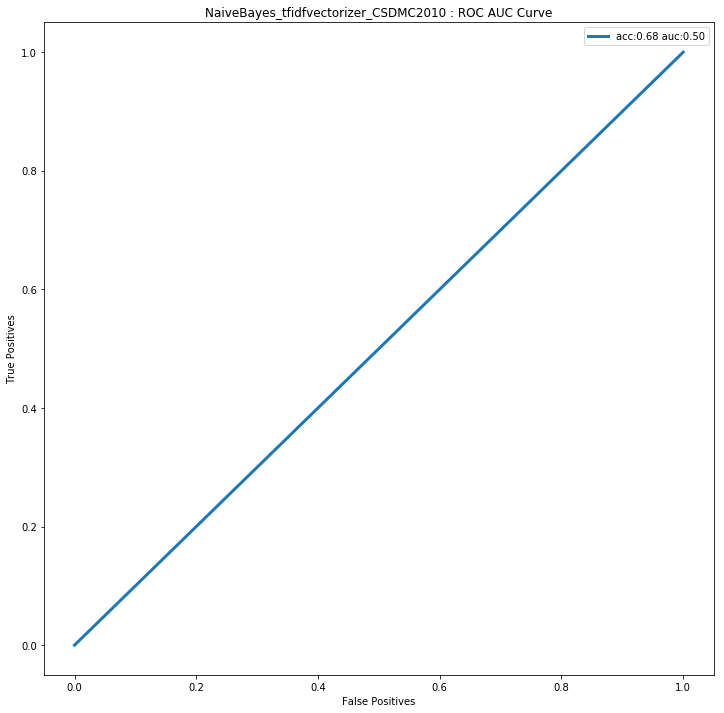

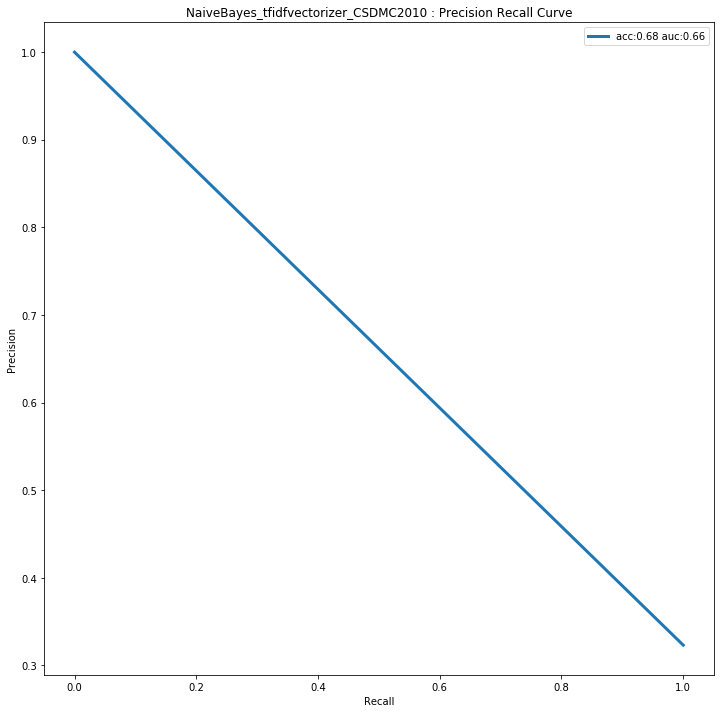

In [44]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings, y_test)

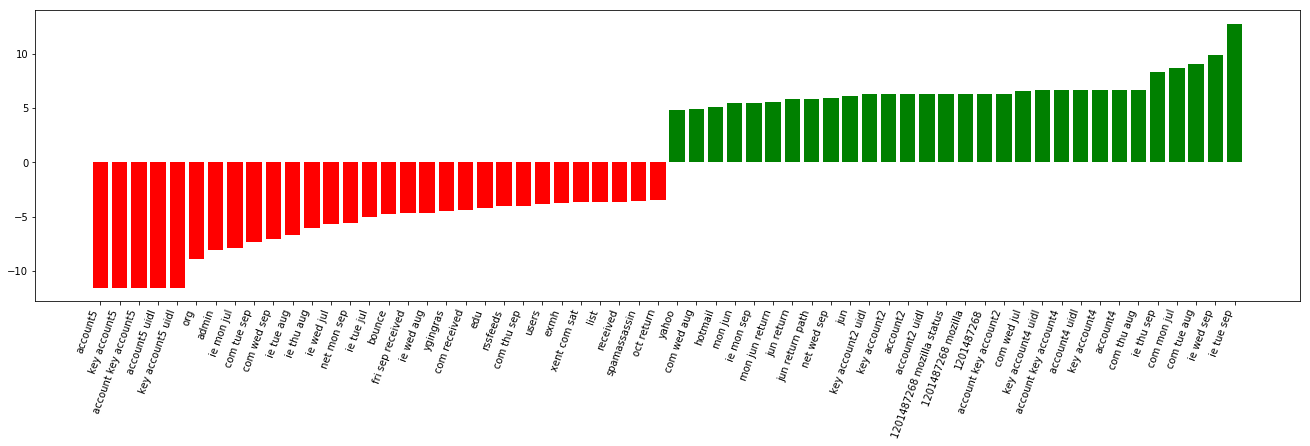

In [45]:
visualize_coefficients(grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[1][1], grids['LogisticRegression_tfidfvectorizer_'+dataset].best_estimator_.steps[0][1].get_feature_names())

## 3. Word Embeddings Approach

## Trying various models and keeping track of best performing params

In [46]:
%%time
grids = {}
entropies = {}
train_x_glove = np.array([text2vec(x,embedding_size) for x in train_x_cleaned])
test_x_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

try_various_models_on_data(dataset, train_x_glove,y_train, test_x_glove, y_test, preprocessing='Embedding')
gc.enable(); gc.collect();

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.3s finished


Best Score :  0.8433813892529489
Test Accuracy :  0.8415686274509804
Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.5min finished


Best Score :  0.8466579292267365
Test Accuracy :  0.8525490196078431
Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.4min finished


Best Score :  0.8482961992136304
Test Accuracy :  0.84
Best Params :  {'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 200}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   33.1s finished


Best Score :  0.8450196592398427
Test Accuracy :  0.8337254901960784
Best Params :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 500}

CPU times: user 19.8 s, sys: 248 ms, total: 20.1 s
Wall time: 6min 56s


## Visualise Shannon and Relative entropies for various models

********************************************************************************
LogisticRegression_Embedding_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.3938196062603986
Mean Relative Entropy :  0.40085313713624665
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1     0.389     2.031     1.0     0.0       0.869       0.131
2     0.512     1.569     1.0     0.0       0.792       0.208
10    0.389     2.031     1.0     0.0       0.869       0.131
12    0.381     2.061     1.0     0.0       0.873       0.127
15    0.389     2.031     1.0     0.0       0.869       0.131
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
884     0.677     0.893     0.0     1.0       0.409       0.591
956     0.693     0.709     0.0     1.0       0.492       0.508
1032    0.258     2.638     0.0     1.0       0.072       0.928
1187    0.642     1.074     0.0     1.0       0.342       0.658

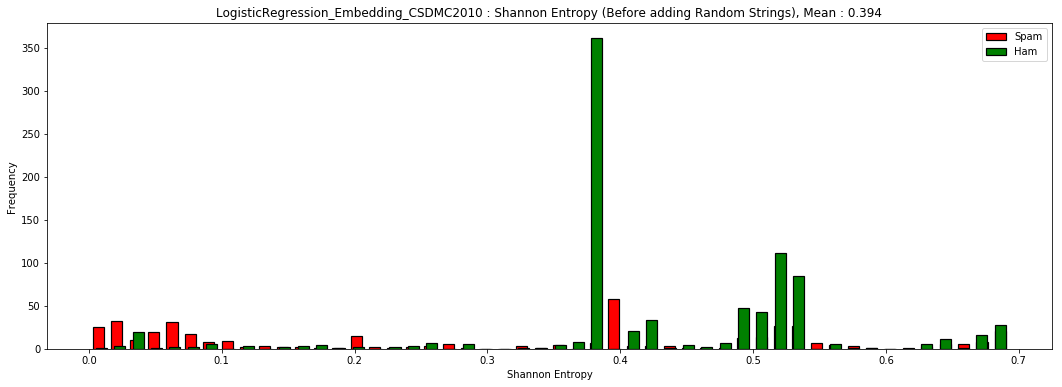

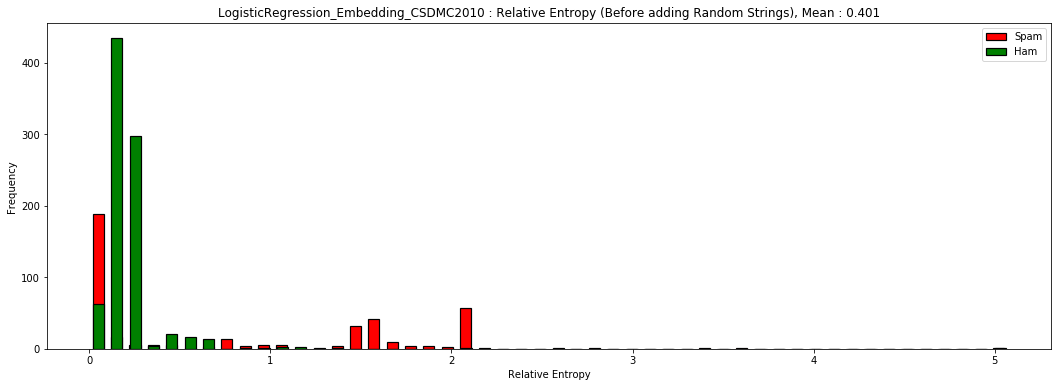

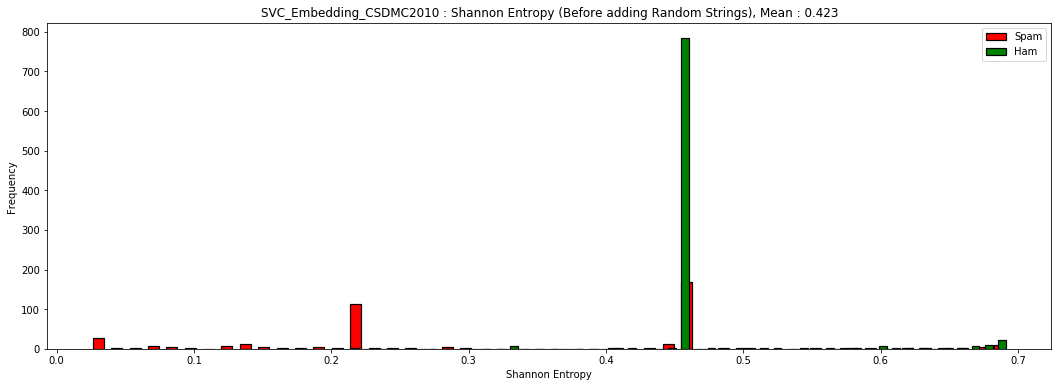

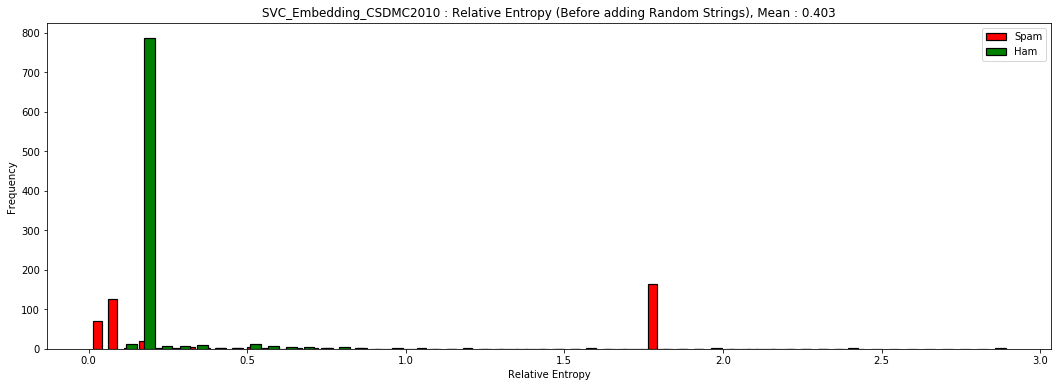

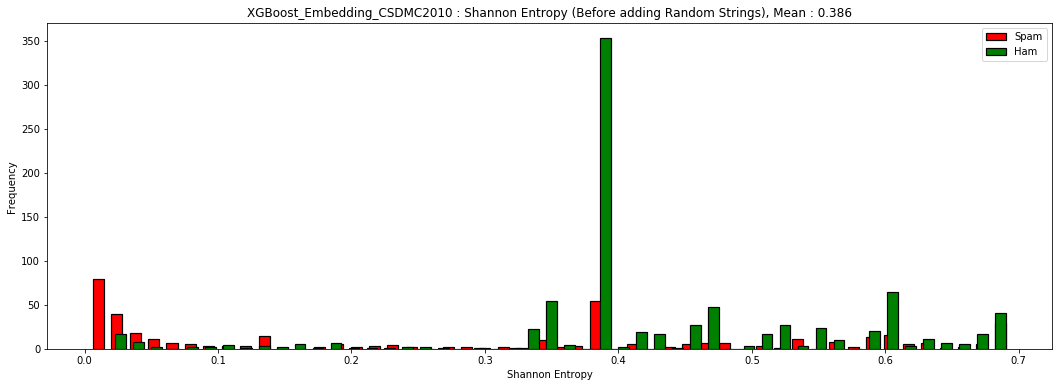

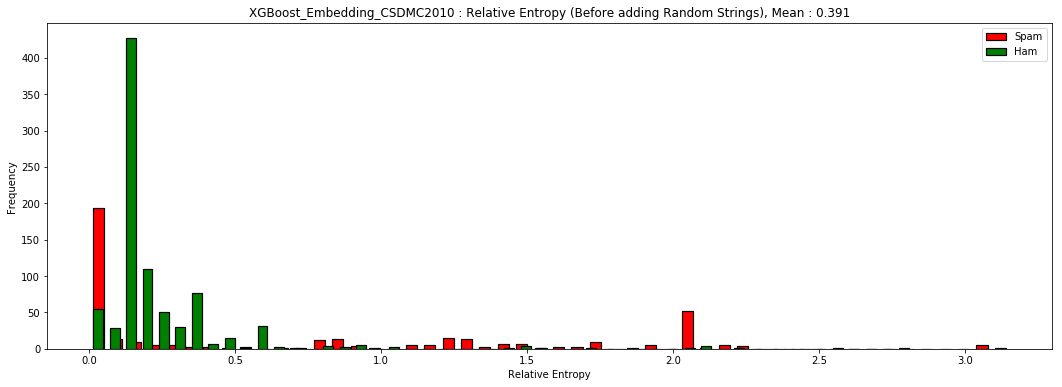

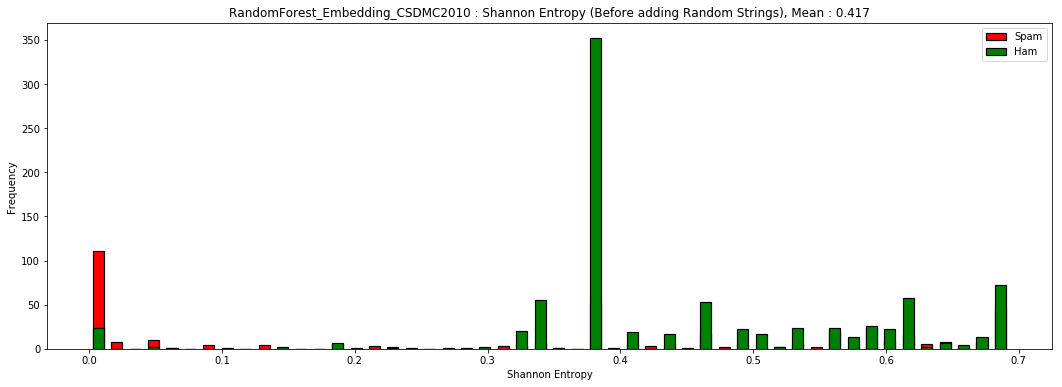

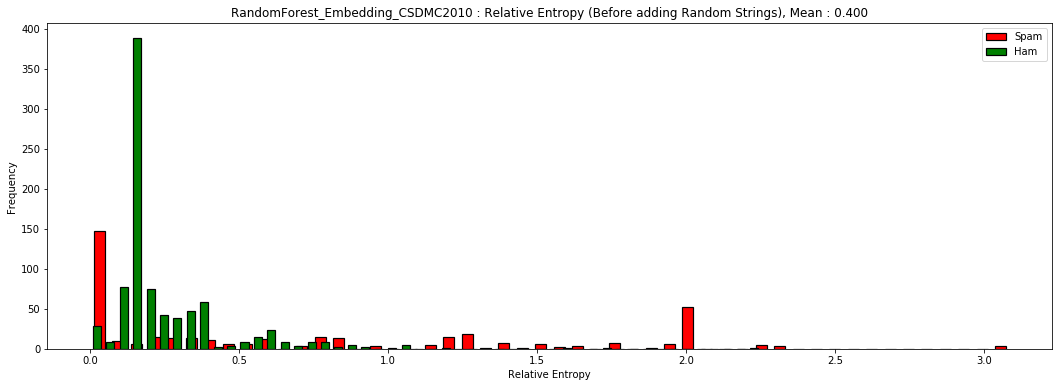

In [47]:
visualise_entropies(dataset, test_x_glove, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
LogisticRegression_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.472033903167492
ROC AUC :  0.824612719234101
Accuracy :  0.8415686274509804
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       863
         1.0       0.94      0.54      0.69       412

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.88      0.76      0.79      1275
weighted avg       0.86      0.84      0.83      1275



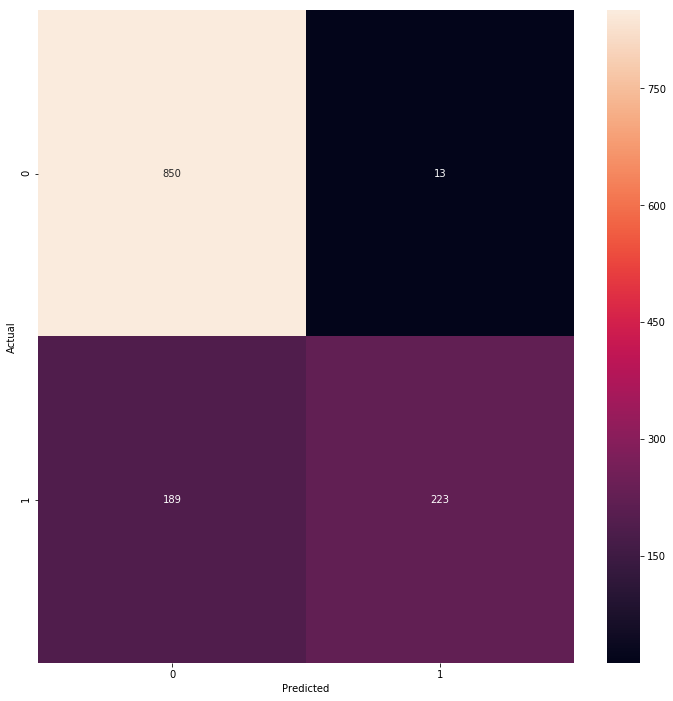

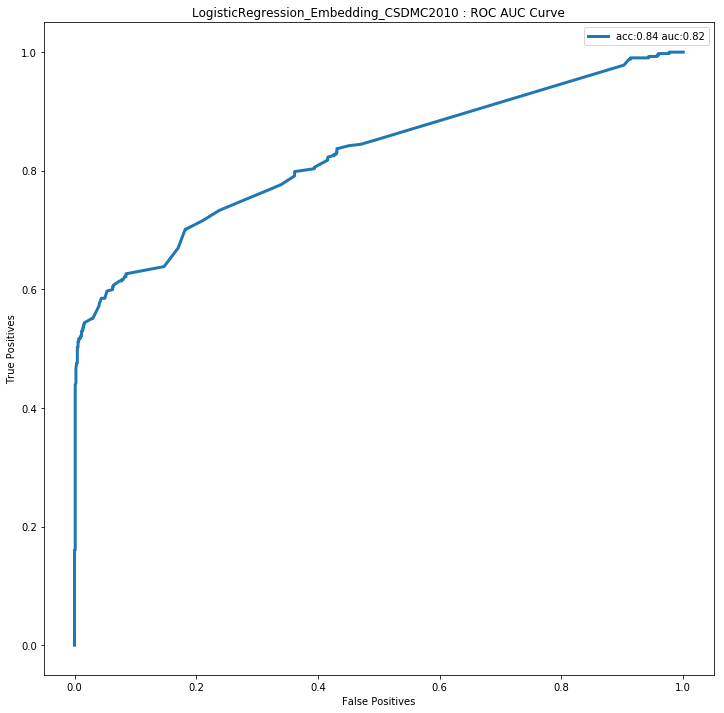

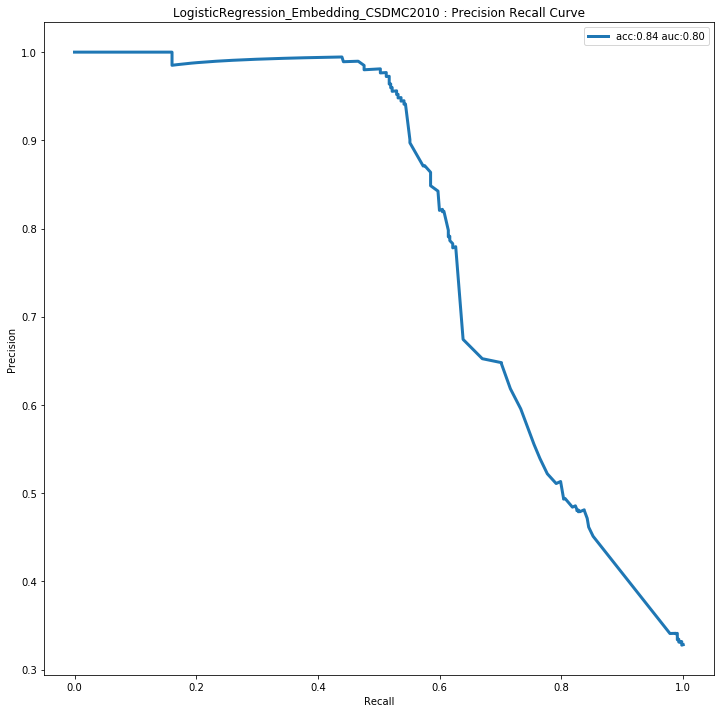

********************************************************************************
SVC_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.092778949516023
ROC AUC :  0.7730188774764032
Accuracy :  0.8525490196078431
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       863
         1.0       0.98      0.55      0.71       412

   micro avg       0.85      0.85      0.85      1275
   macro avg       0.90      0.77      0.80      1275
weighted avg       0.88      0.85      0.84      1275



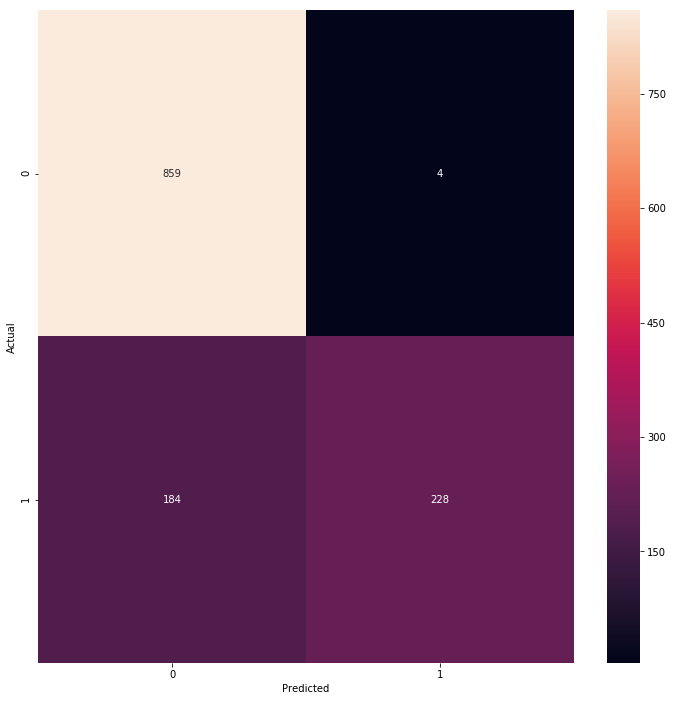

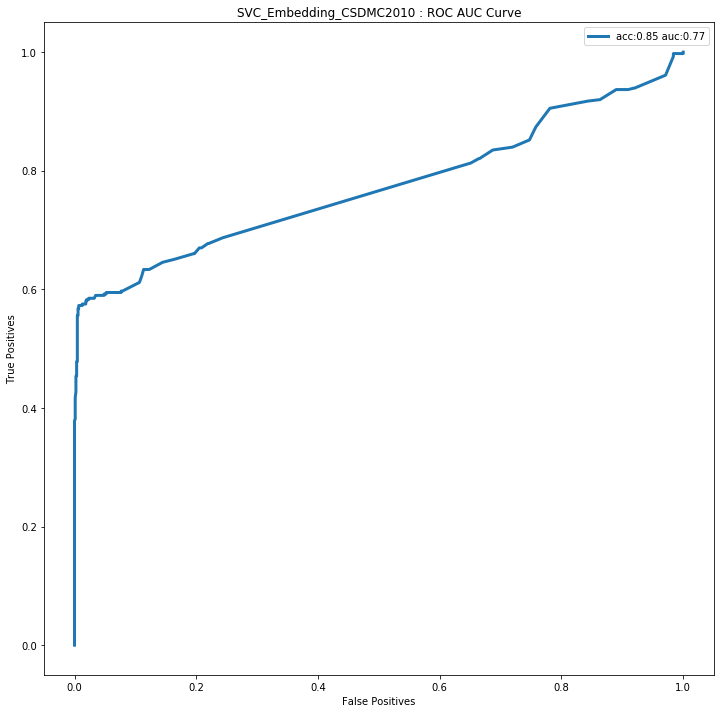

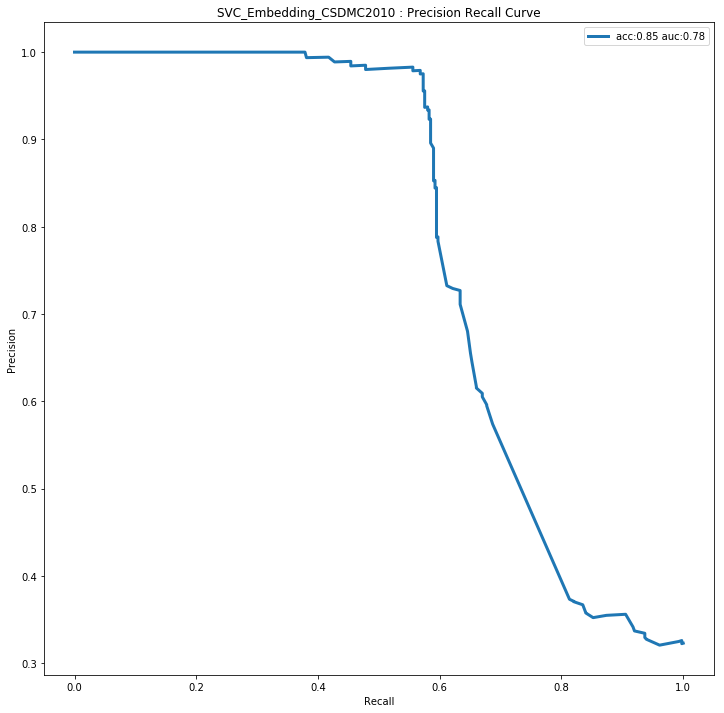

********************************************************************************
XGBoost_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.526222410107652
ROC AUC :  0.836125673592908
Accuracy :  0.84
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       863
         1.0       0.89      0.58      0.70       412

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.86      0.77      0.80      1275
weighted avg       0.85      0.84      0.83      1275



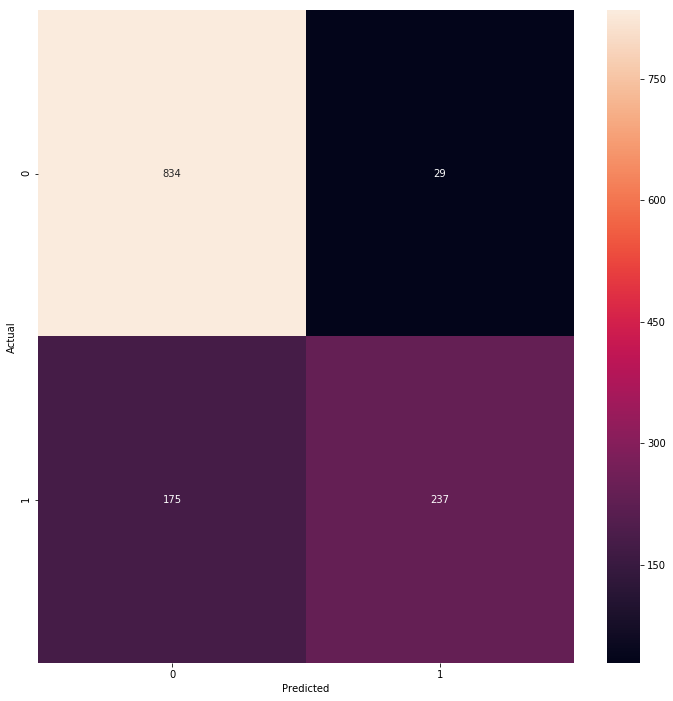

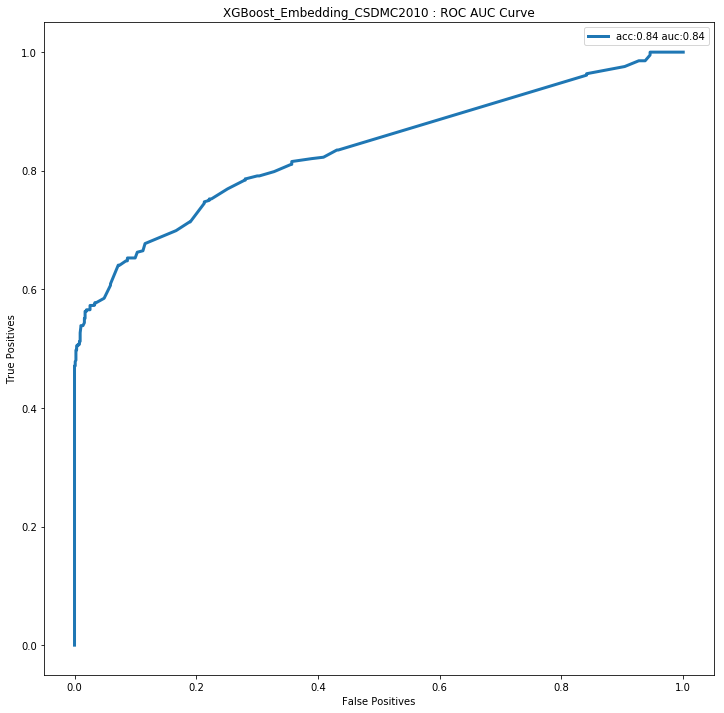

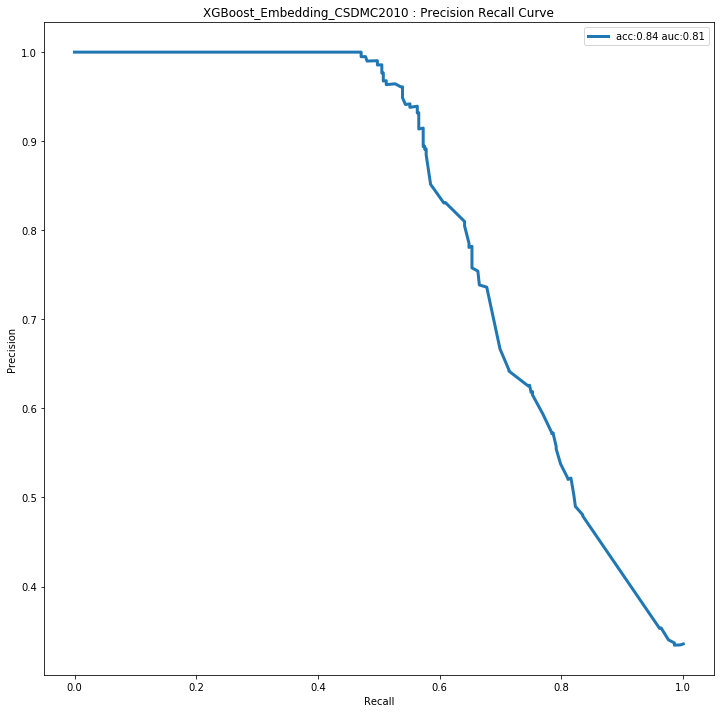

********************************************************************************
RandomForest_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.742943199700607
ROC AUC :  0.8327478653151684
Accuracy :  0.8337254901960784
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       863
         1.0       0.86      0.58      0.69       412

   micro avg       0.83      0.83      0.83      1275
   macro avg       0.84      0.77      0.79      1275
weighted avg       0.84      0.83      0.82      1275



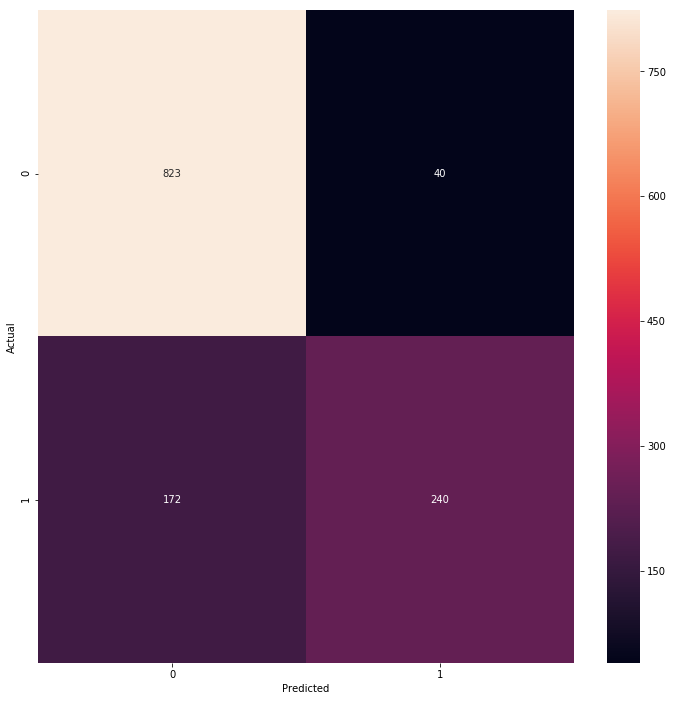

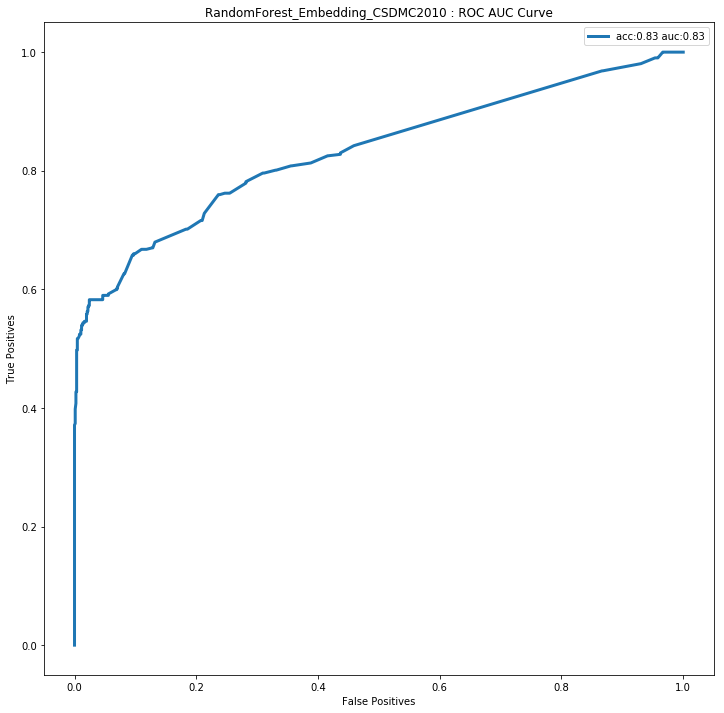

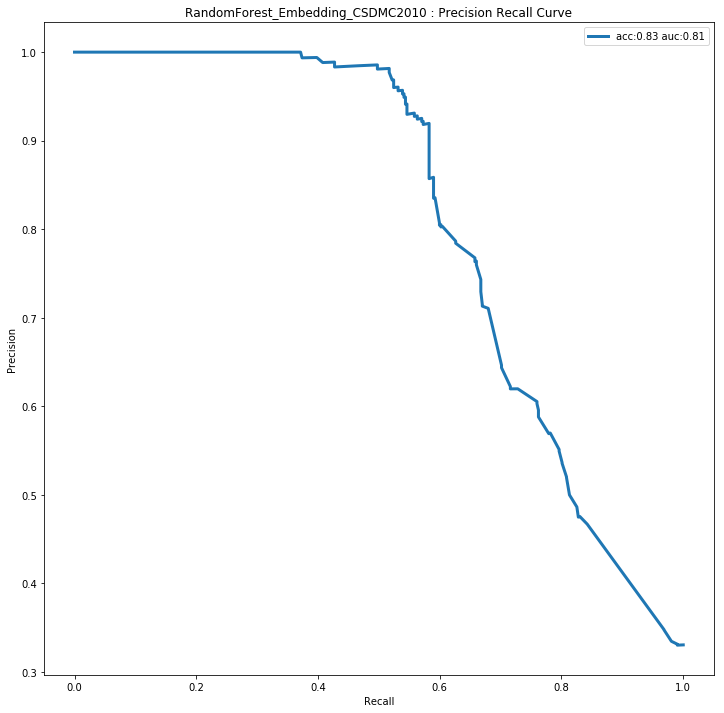

In [48]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_glove, y_test)

## Adding Meaningful Strings to Test Data

In [49]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.3938196062603986
Mean Relative Entropy :  0.40085313713624665
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1     0.389     2.031     1.0     0.0       0.869       0.131
2     0.512     1.569     1.0     0.0       0.792       0.208
10    0.389     2.031     1.0     0.0       0.869       0.131
12    0.381     2.061     1.0     0.0       0.873       0.127
15    0.389     2.031     1.0     0.0       0.869       0.131
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
884     0.677     0.893     0.0     1.0       0.409       0.591
956     0.693     0.709     0.0     1.0       0.492       0.508
1032    0.258     2.638     0.0     1.0       0.072       0.928
1187    0.642     1.074     0.0     1.0       0.342       0.658

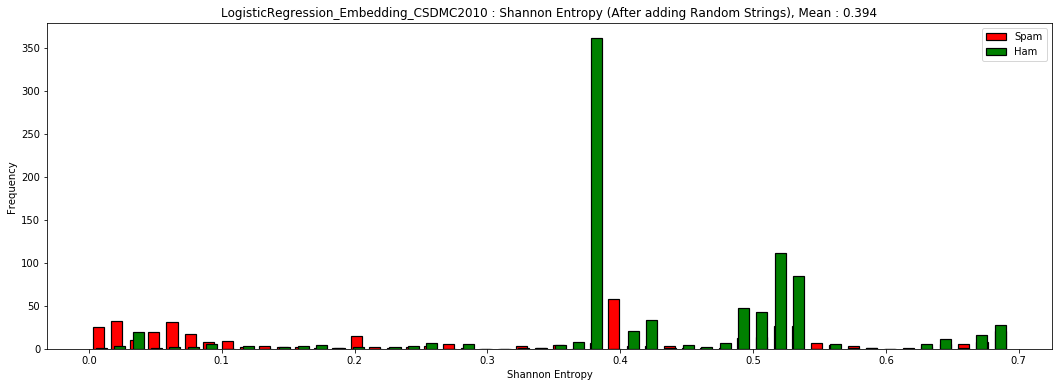

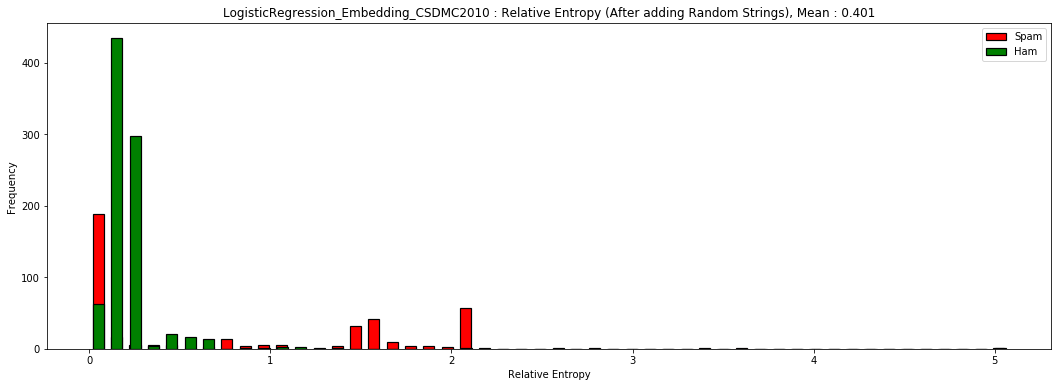

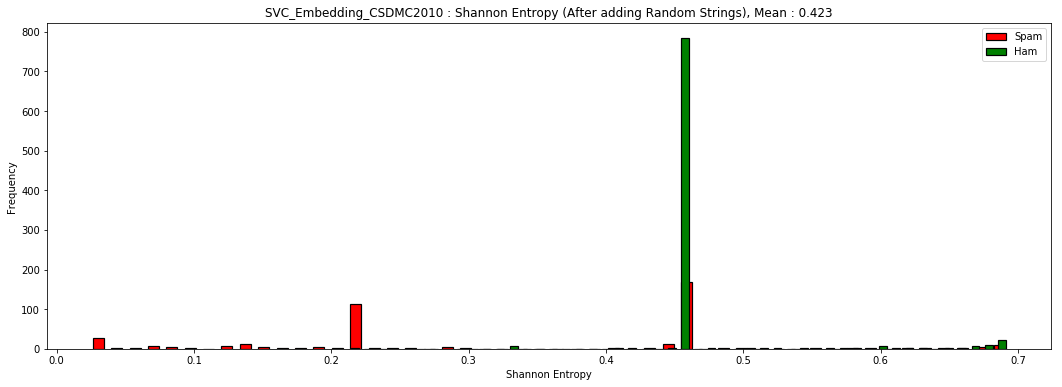

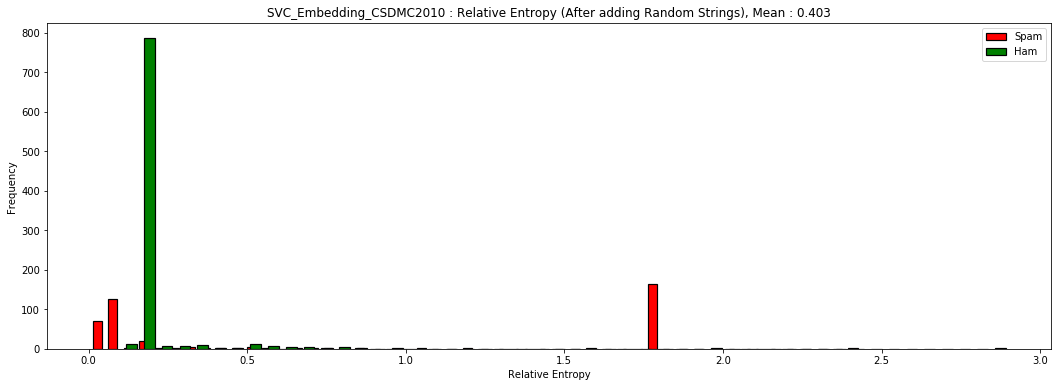

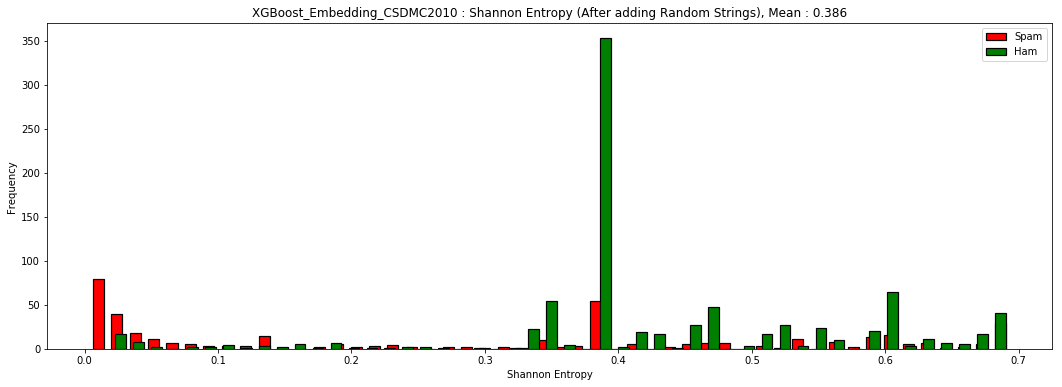

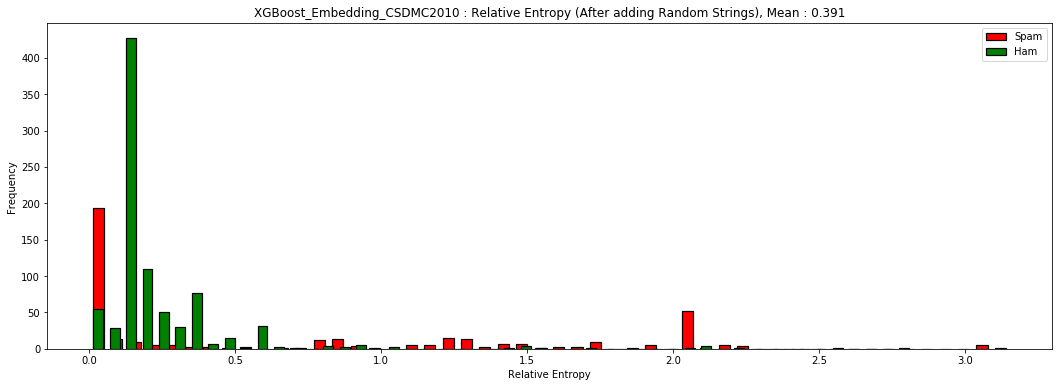

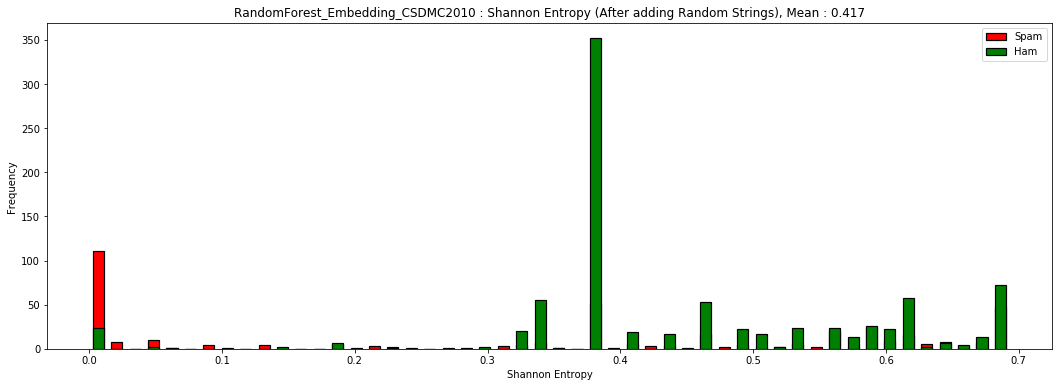

In [50]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.472033903167492
ROC AUC :  0.824612719234101
Accuracy :  0.8415686274509804
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       863
         1.0       0.94      0.54      0.69       412

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.88      0.76      0.79      1275
weighted avg       0.86      0.84      0.83      1275



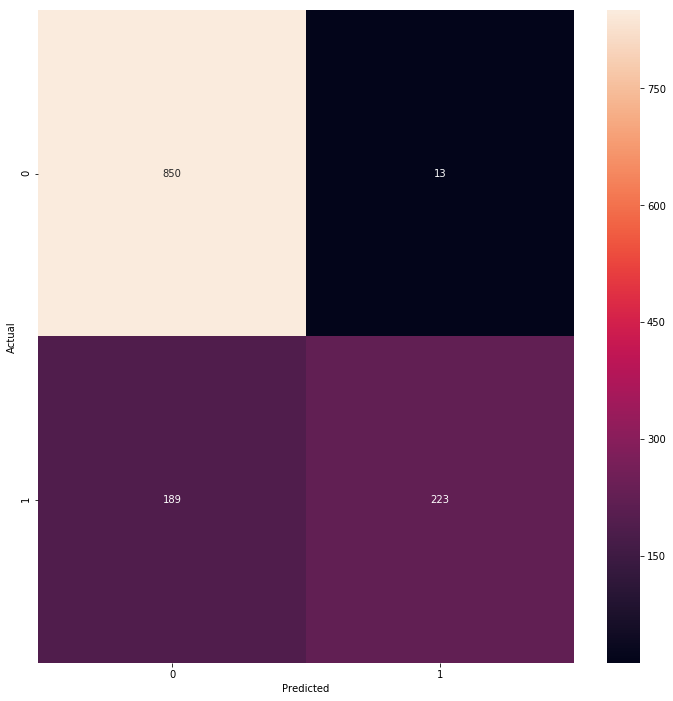

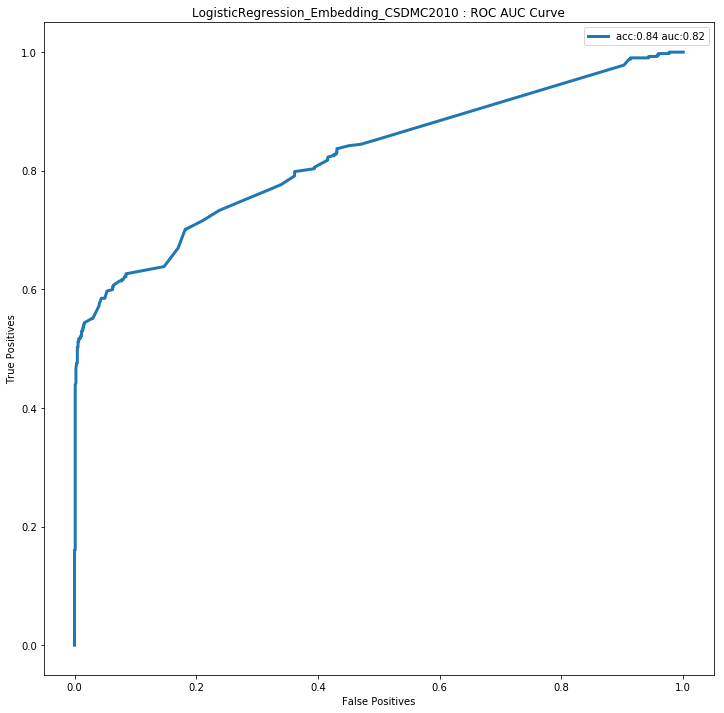

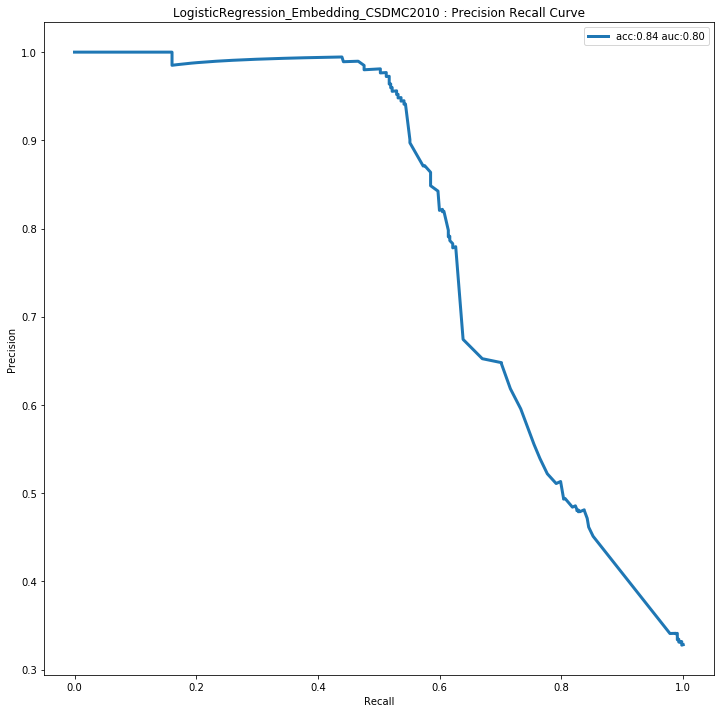

********************************************************************************
SVC_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.092778949516023
ROC AUC :  0.7730188774764032
Accuracy :  0.8525490196078431
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       863
         1.0       0.98      0.55      0.71       412

   micro avg       0.85      0.85      0.85      1275
   macro avg       0.90      0.77      0.80      1275
weighted avg       0.88      0.85      0.84      1275



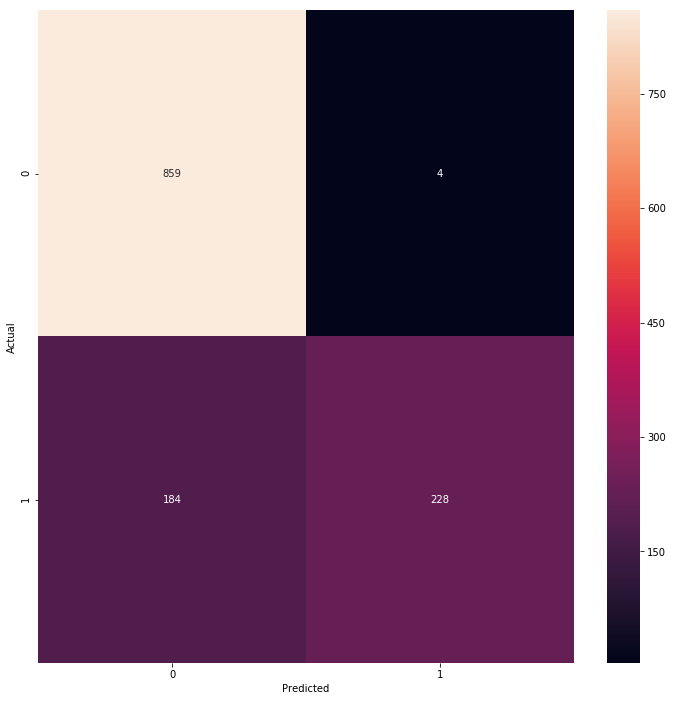

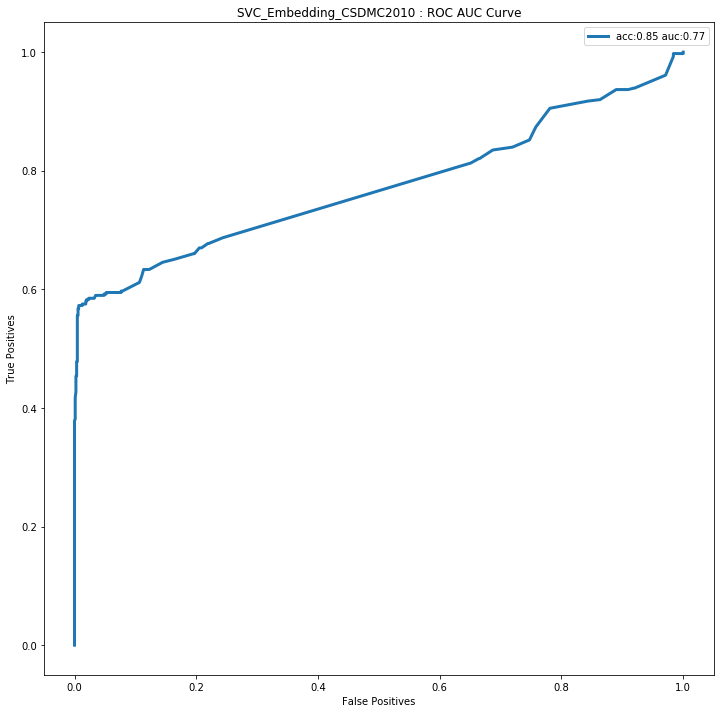

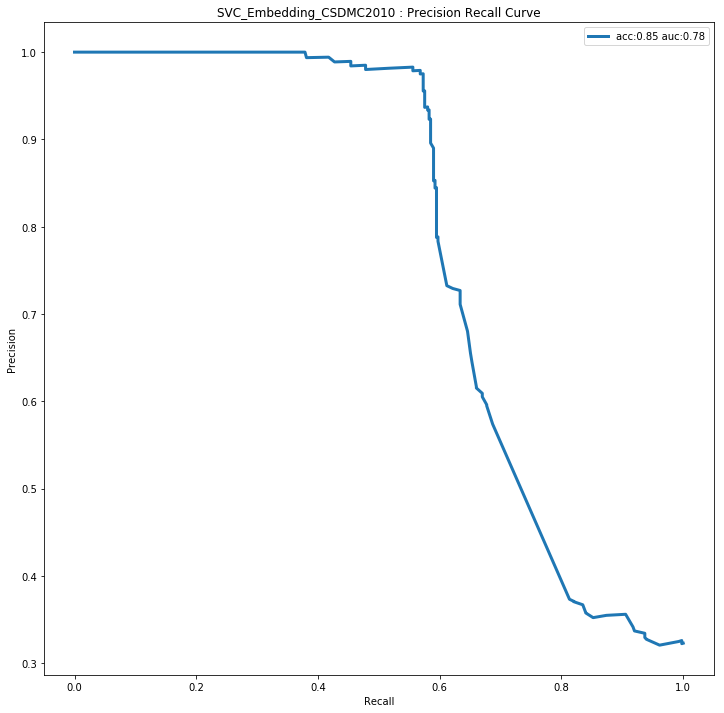

********************************************************************************
XGBoost_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.526222410107652
ROC AUC :  0.836125673592908
Accuracy :  0.84
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       863
         1.0       0.89      0.58      0.70       412

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.86      0.77      0.80      1275
weighted avg       0.85      0.84      0.83      1275



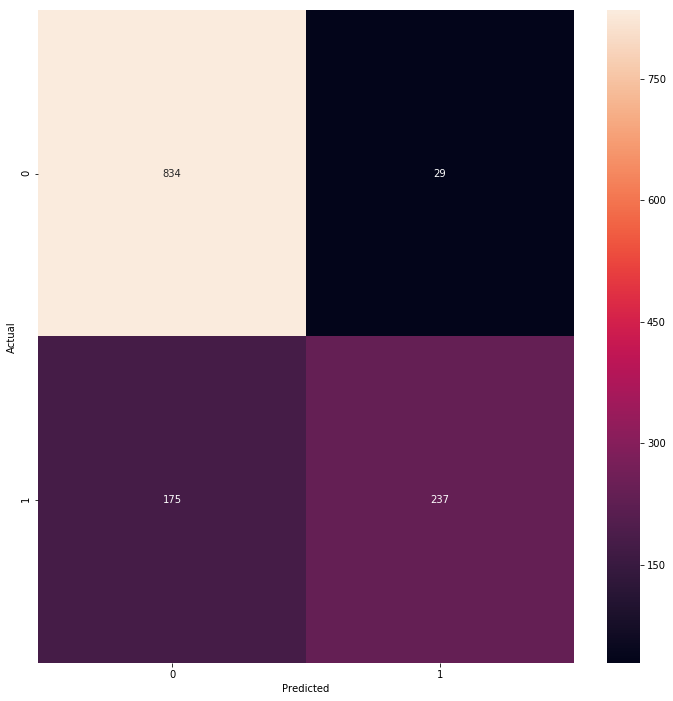

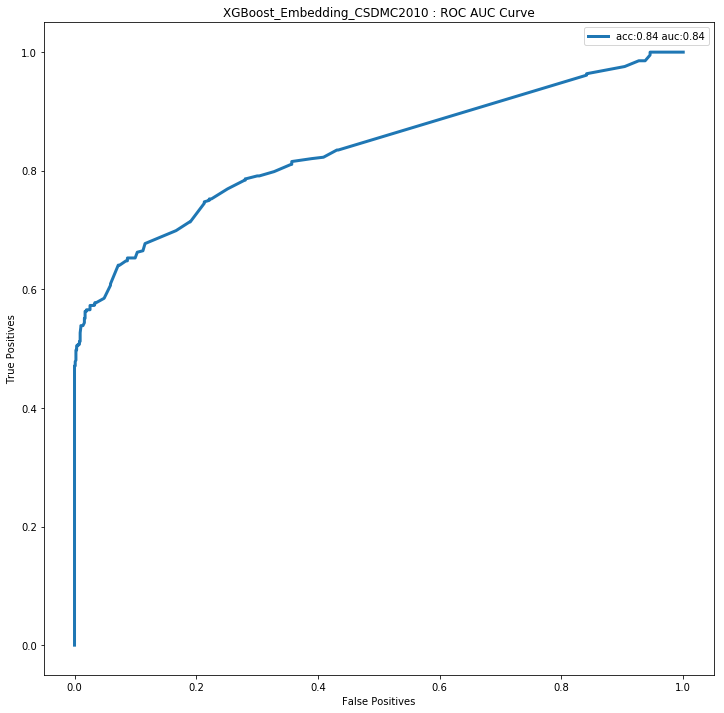

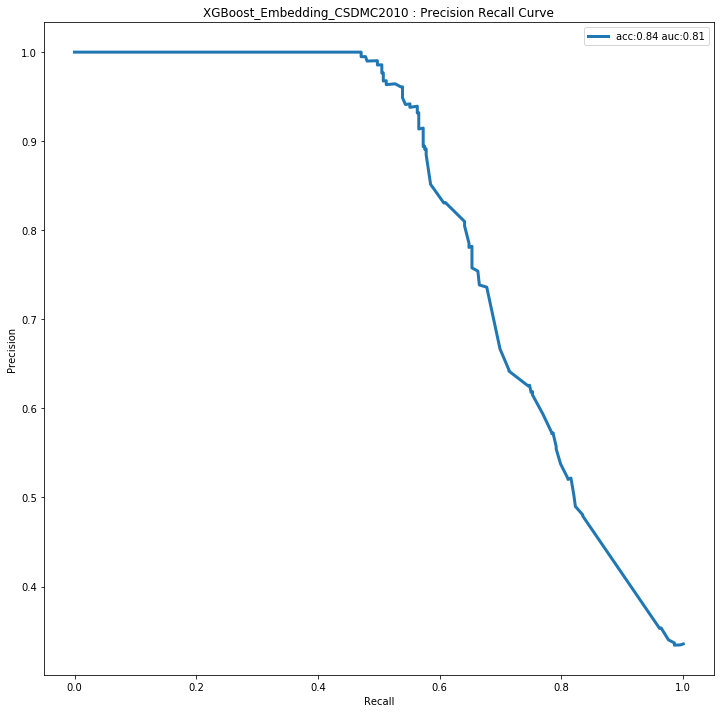

********************************************************************************
RandomForest_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.742943199700607
ROC AUC :  0.8327478653151684
Accuracy :  0.8337254901960784
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       863
         1.0       0.86      0.58      0.69       412

   micro avg       0.83      0.83      0.83      1275
   macro avg       0.84      0.77      0.79      1275
weighted avg       0.84      0.83      0.82      1275



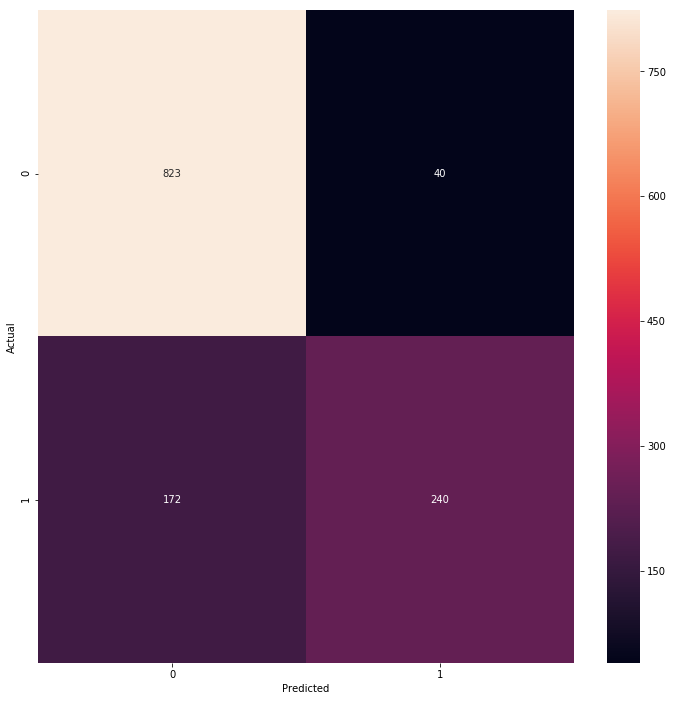

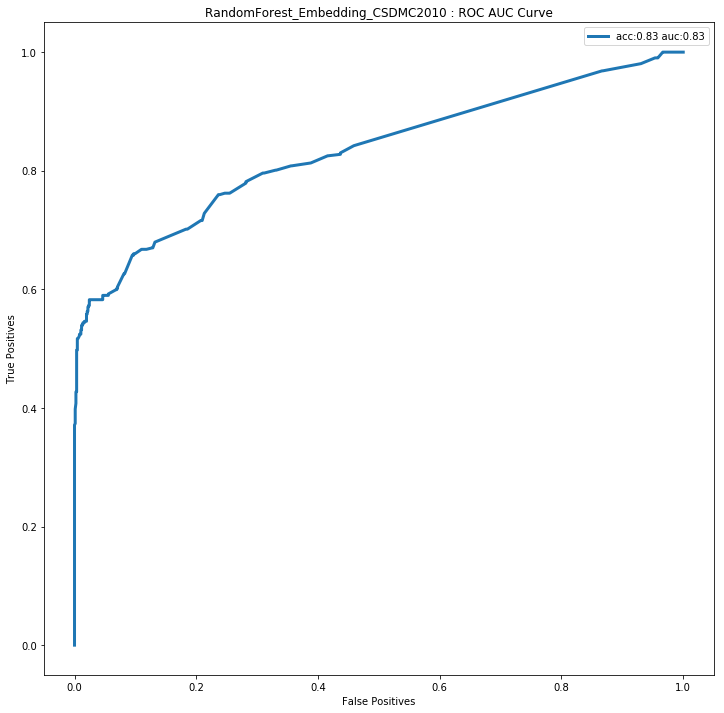

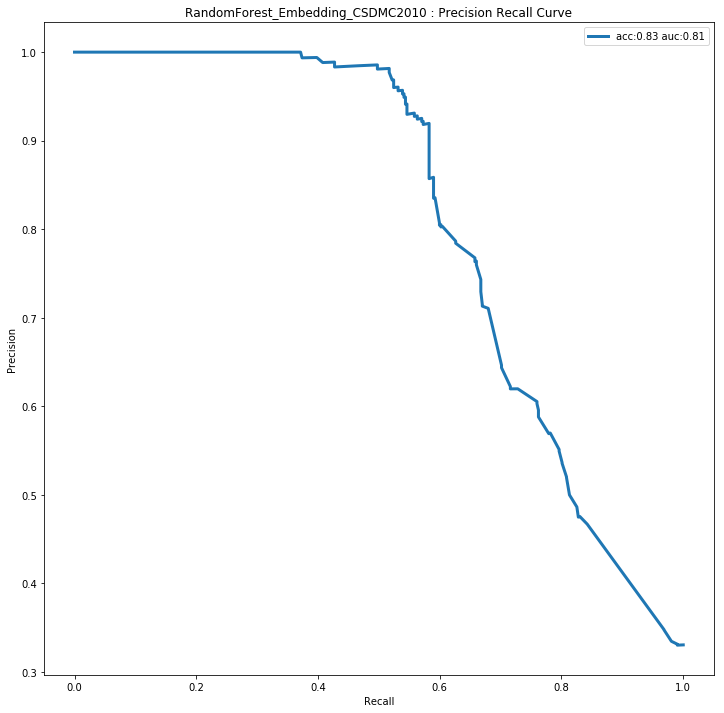

In [51]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [52]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
test_x_with_random_strings_glove = np.array([text2vec(x,embedding_size) for x in test_x_cleaned])

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.3938196062603986
Mean Relative Entropy :  0.40085313713624665
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1     0.389     2.031     1.0     0.0       0.869       0.131
2     0.512     1.569     1.0     0.0       0.792       0.208
10    0.389     2.031     1.0     0.0       0.869       0.131
12    0.381     2.061     1.0     0.0       0.873       0.127
15    0.389     2.031     1.0     0.0       0.869       0.131
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
884     0.677     0.893     0.0     1.0       0.409       0.591
956     0.693     0.709     0.0     1.0       0.492       0.508
1032    0.258     2.638     0.0     1.0       0.072       0.928
1187    0.642     1.074     0.0     1.0       0.342       0.658

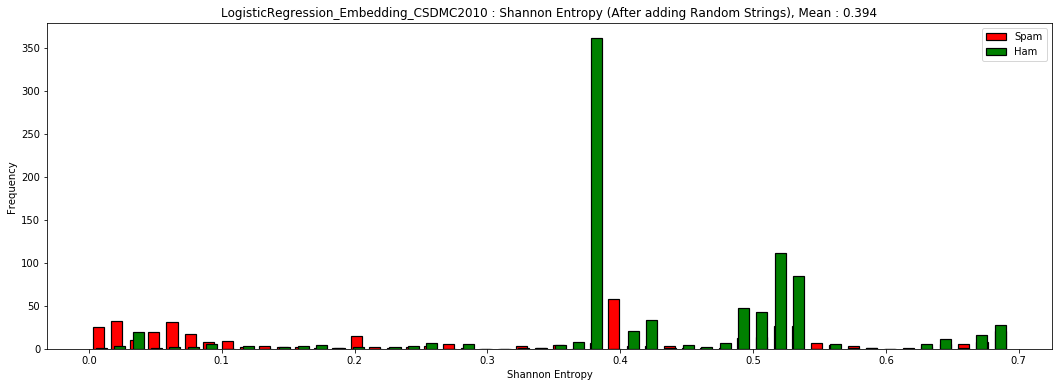

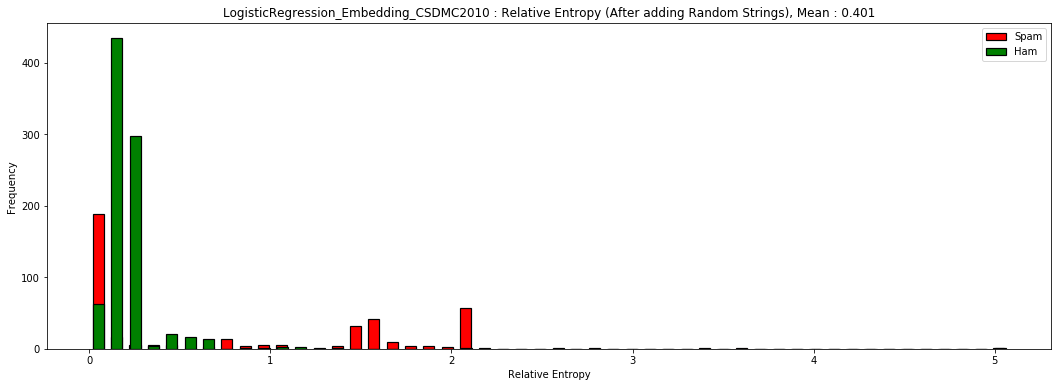

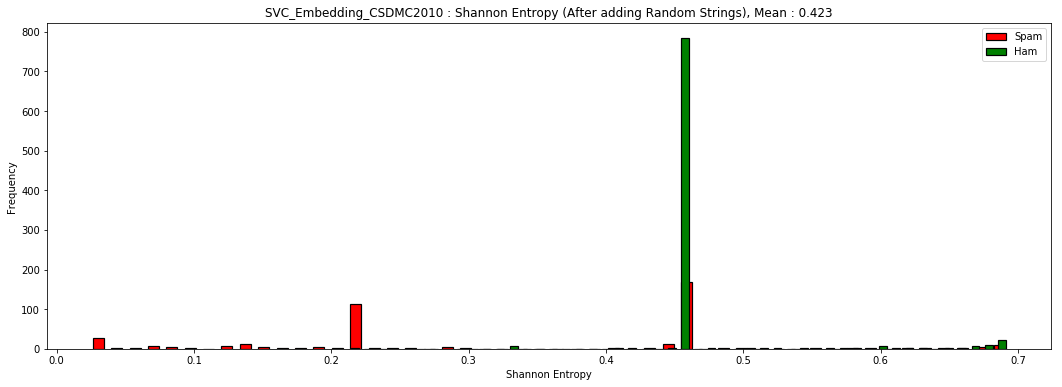

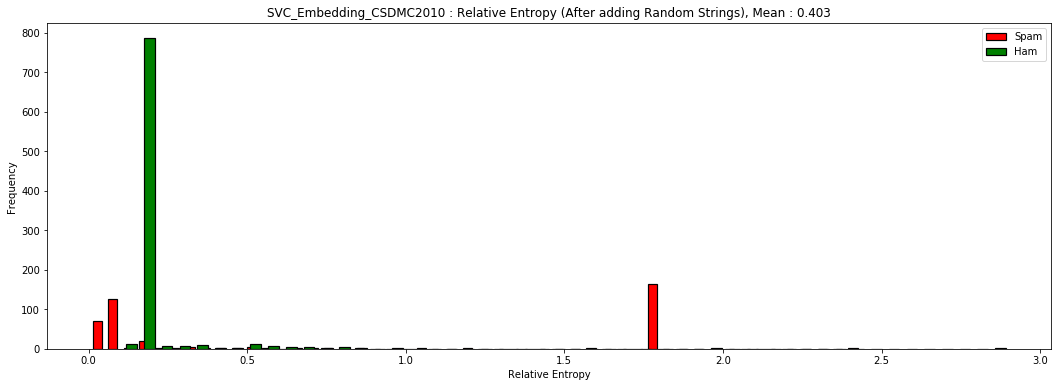

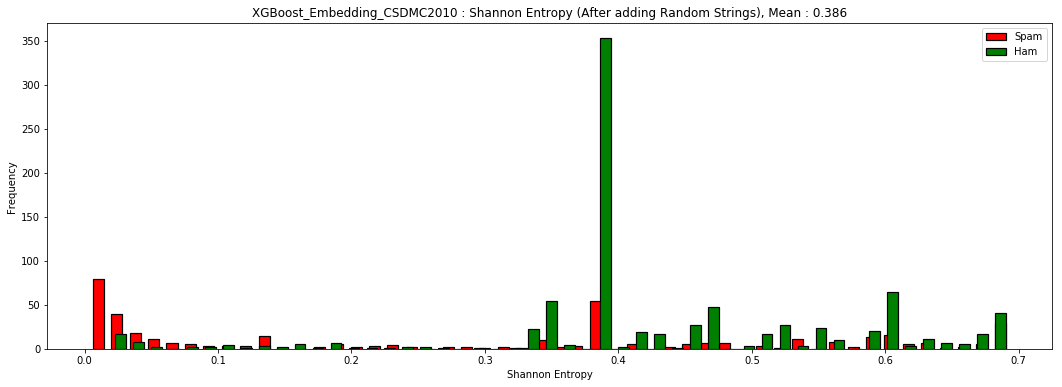

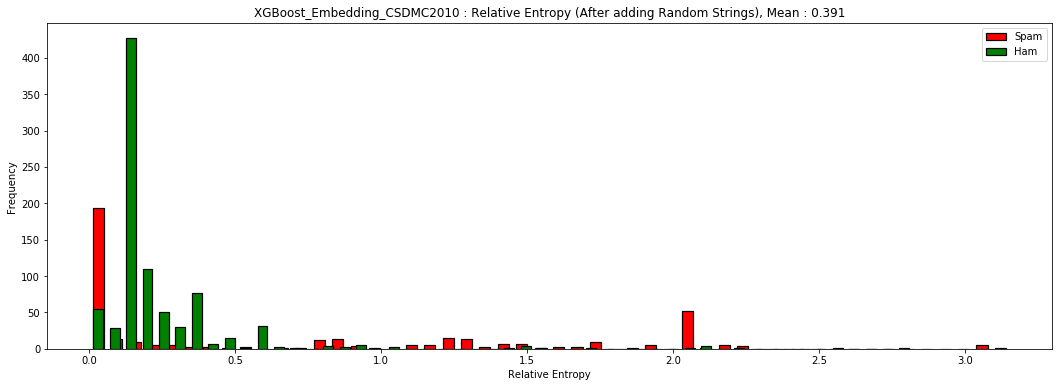

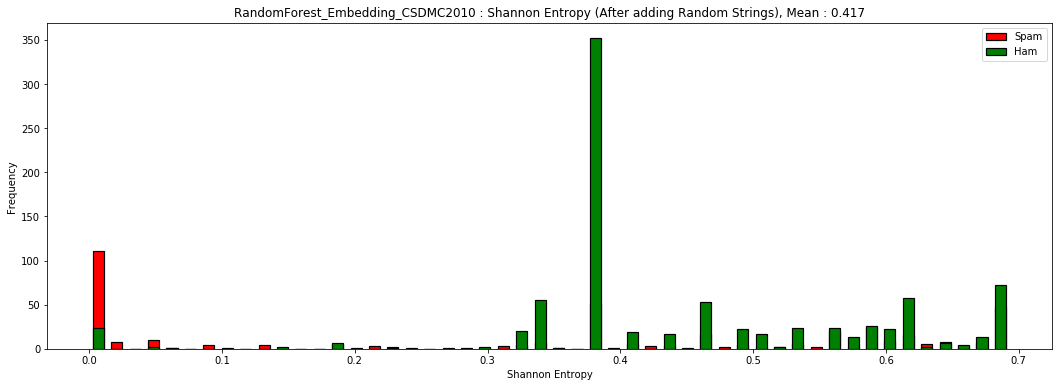

In [53]:
visualise_entropies(dataset, test_x_with_random_strings_glove, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
LogisticRegression_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.472033903167492
ROC AUC :  0.824612719234101
Accuracy :  0.8415686274509804
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       863
         1.0       0.94      0.54      0.69       412

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.88      0.76      0.79      1275
weighted avg       0.86      0.84      0.83      1275



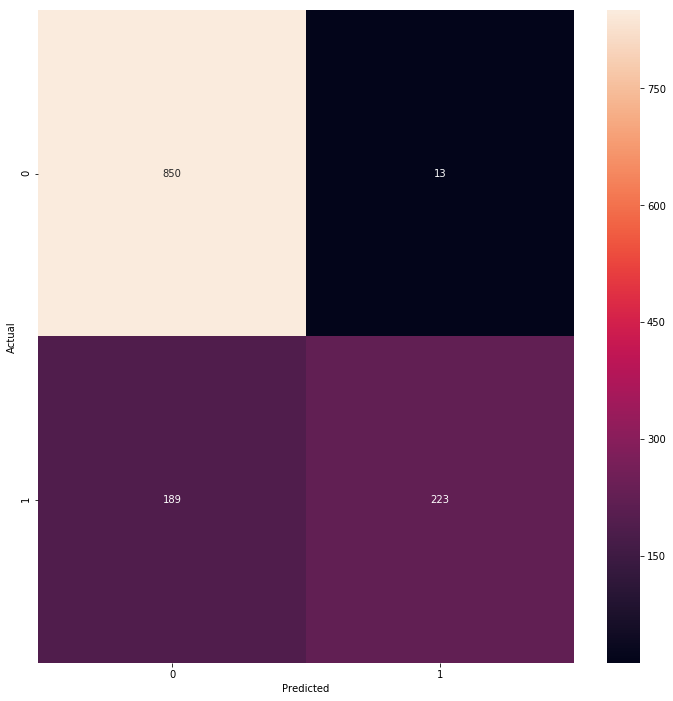

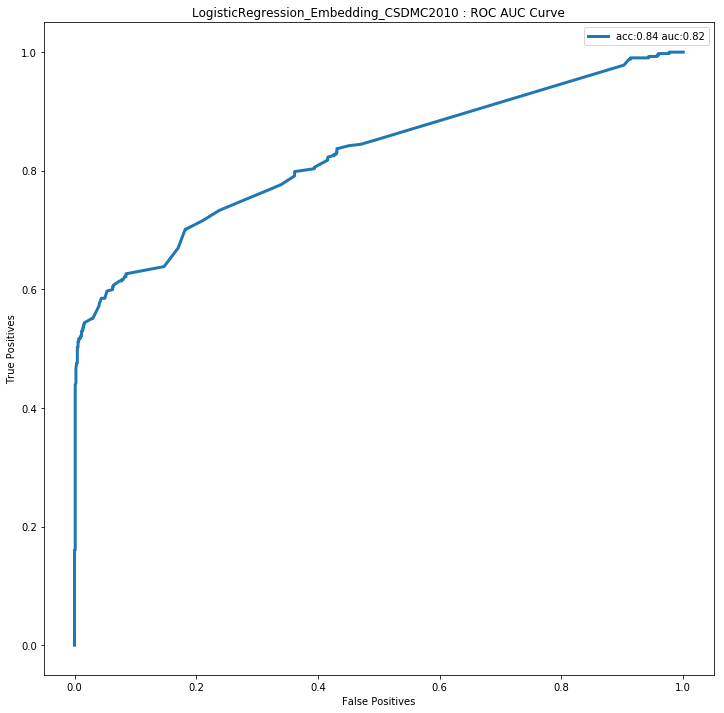

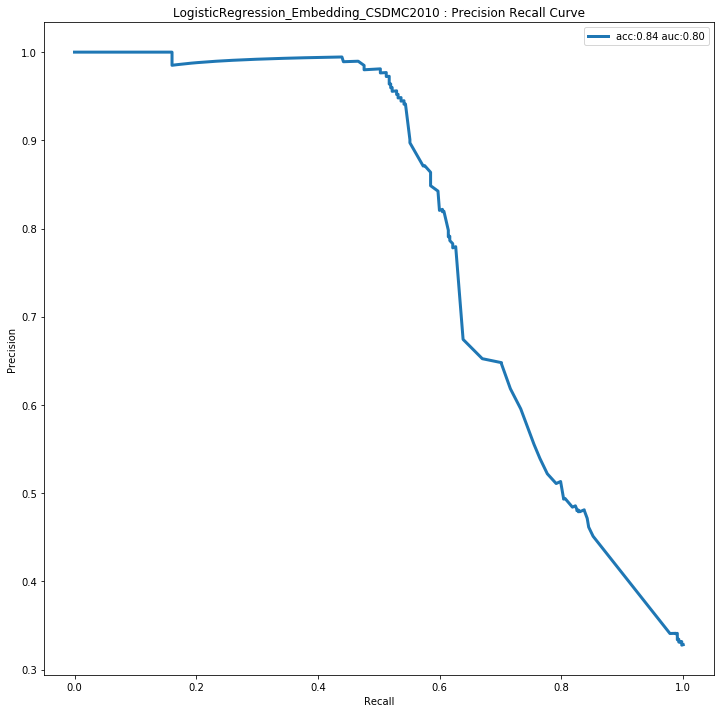

********************************************************************************
SVC_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.092778949516023
ROC AUC :  0.7730188774764032
Accuracy :  0.8525490196078431
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       863
         1.0       0.98      0.55      0.71       412

   micro avg       0.85      0.85      0.85      1275
   macro avg       0.90      0.77      0.80      1275
weighted avg       0.88      0.85      0.84      1275



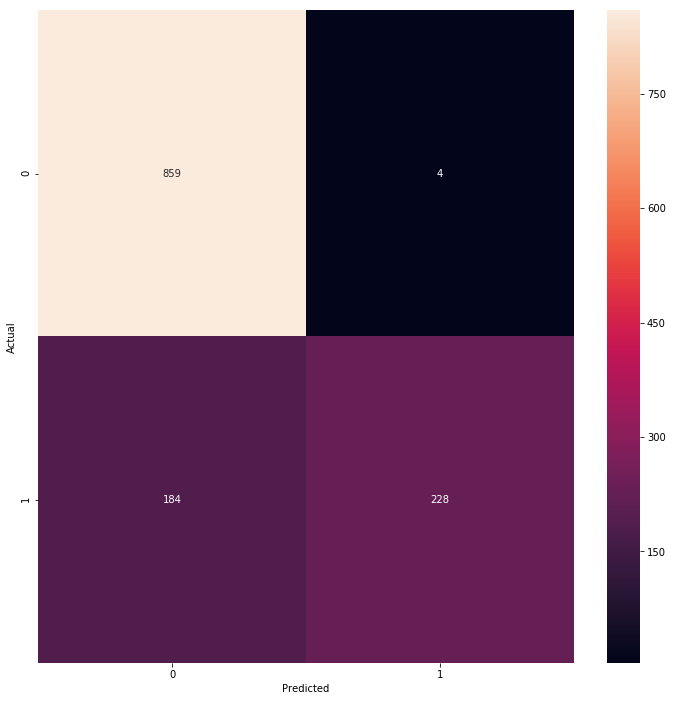

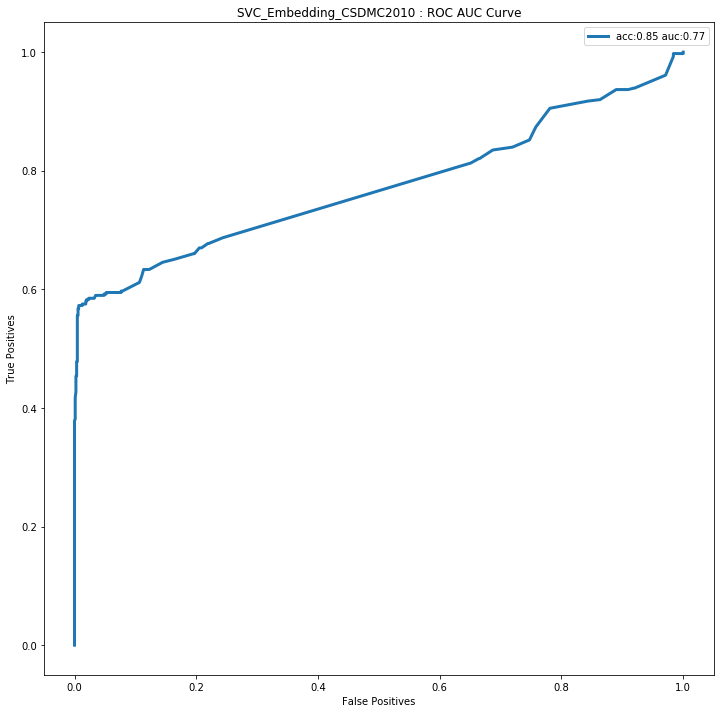

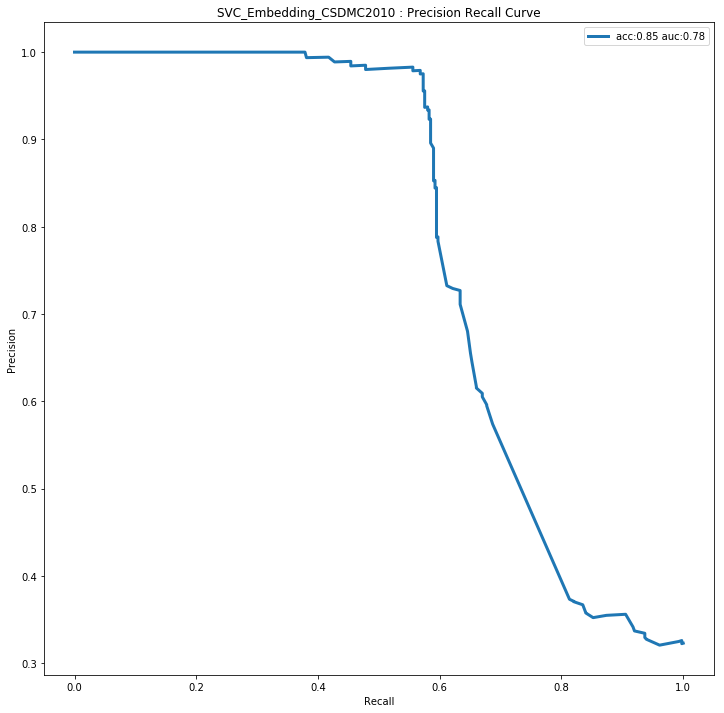

********************************************************************************
XGBoost_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.526222410107652
ROC AUC :  0.836125673592908
Accuracy :  0.84
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       863
         1.0       0.89      0.58      0.70       412

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.86      0.77      0.80      1275
weighted avg       0.85      0.84      0.83      1275



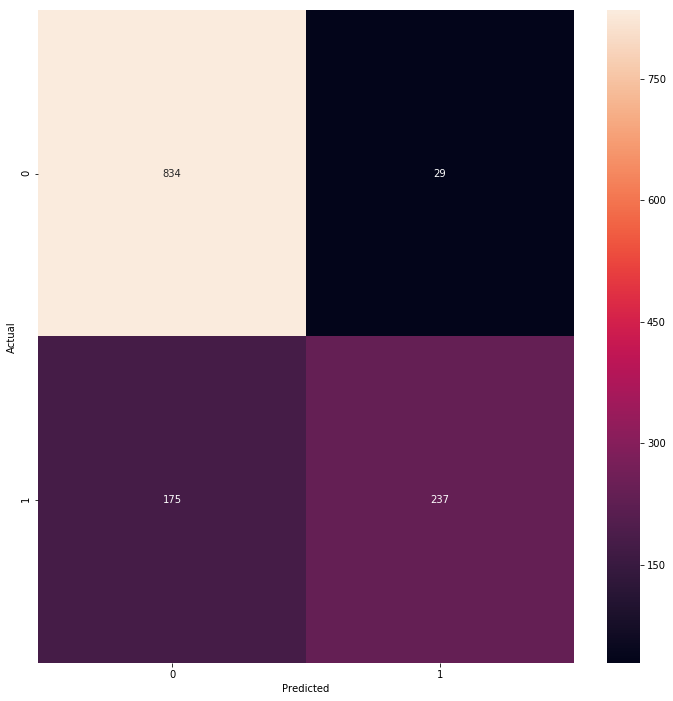

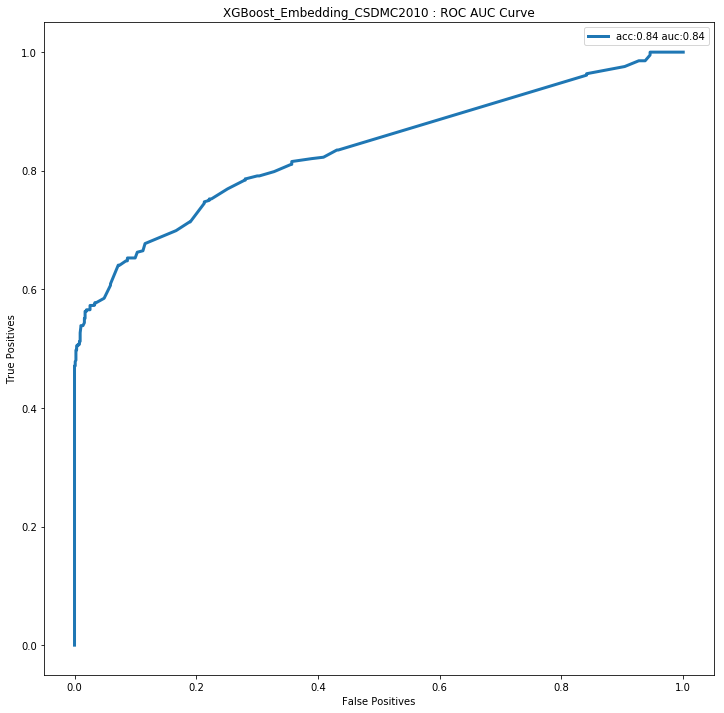

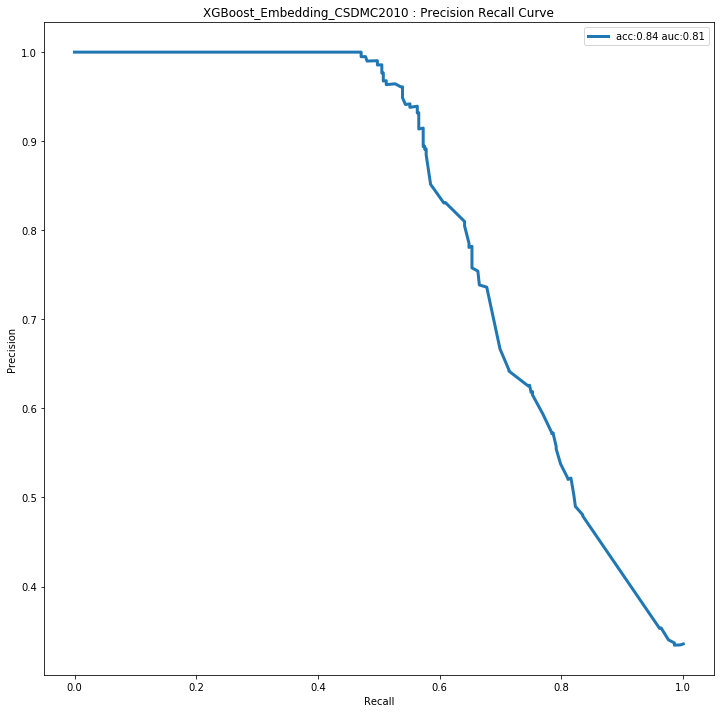

********************************************************************************
RandomForest_Embedding_CSDMC2010
********************************************************************************
Log Loss :  5.742943199700607
ROC AUC :  0.8327478653151684
Accuracy :  0.8337254901960784
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       863
         1.0       0.86      0.58      0.69       412

   micro avg       0.83      0.83      0.83      1275
   macro avg       0.84      0.77      0.79      1275
weighted avg       0.84      0.83      0.82      1275



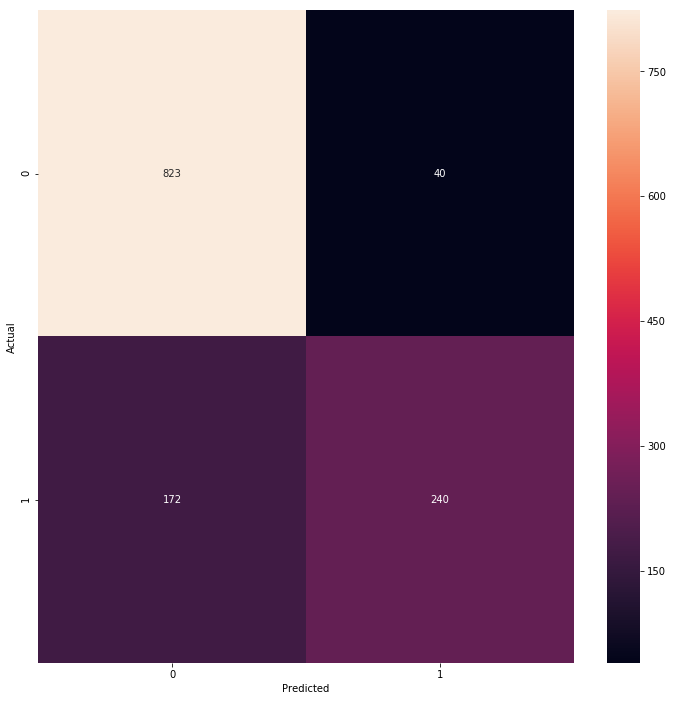

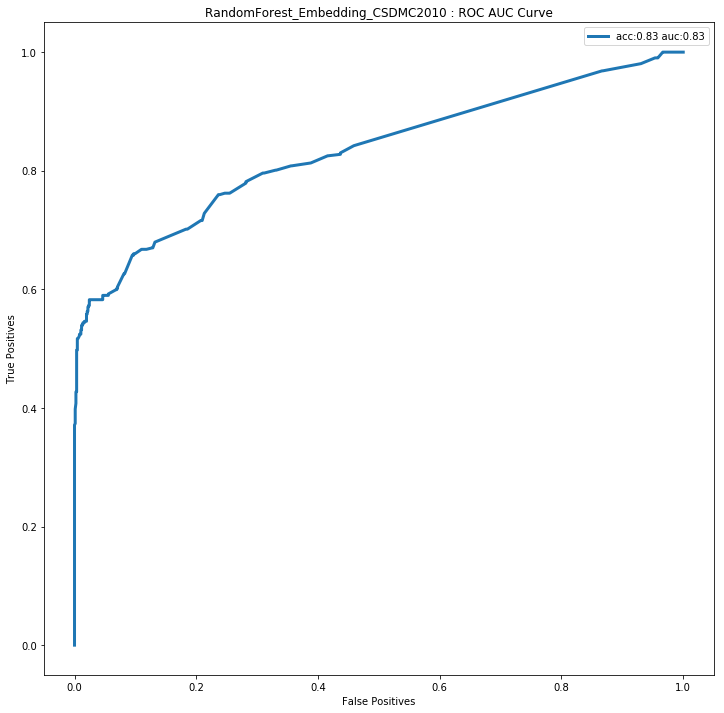

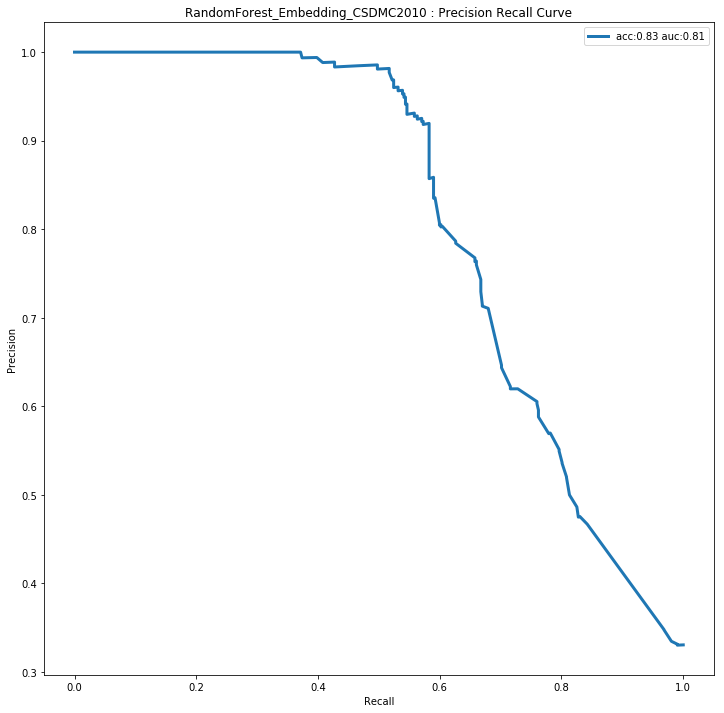

In [54]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_glove, y_test)

## 4. Embeddings with Dense Network

In [55]:
grids = {}
num_max = 1000
le = LabelEncoder()
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(train_x_cleaned)
train_x_dense = tok.texts_to_matrix(train_x_cleaned,mode='count')
test_x_dense = tok.texts_to_matrix(test_x_cleaned,mode='count')
print(y_train.shape,train_x_dense.shape, y_test.shape, test_x_dense.shape)

(3052,) (3052, 1000) (1275,) (1275, 1000)


In [56]:
dense_model = get_dense_model(num_max)
dense_model.fit(train_x_dense,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['DNN_'+dataset] = copy.deepcopy(dense_model)

gc.enable(); gc.collect();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compile done
Instructions for updating:
Use tf.cast instead.
Train on 2441 samples, validate on 611 samples
Epoch 1/10
2441/2441 [==============================] - 5s 2ms/step - loss: 0.2093 - acc: 0.9095 - binary_accuracy: 0.9095 - val_loss: 0.0717 - val_acc: 0.9689 - val_binary_accuracy: 0.9689
Epoch 2/10
2441/2441 [==============================] - 0s 160us/step - loss: 0.0520 - acc: 0.9857 - binary_accuracy: 0.9857 - val_loss: 0.0835 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 3/10
2441/2441 [==============================] - 0s 161us/step - loss: 0.0360 - acc: 0.9873 - binary_accuracy: 0.9873 - val_loss: 0.0692 - val_acc: 0.9771 - val_binary_accuracy: 0.9771
Epoch 4/10
2441/2441 [==============================] - 0s 161us/step - loss: 0.0370 - acc: 0.9898 - binary_accuracy: 0.9898 - val_

## Visualise Shannon and Relative entropies for various models

********************************************************************************
DNN_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.06365621
Mean Relative Entropy :  0.07845497560833652
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2      0.480     1.683     1.0       0       0.814       0.186
74     0.518     1.547     1.0       0       0.787       0.213
97     0.567     1.369     1.0       0       0.746       0.254
101    0.514     1.559     1.0       0       0.790       0.210
137    0.503     1.601     1.0       0       0.798       0.202
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1063    0.056     4.605     0.0       1       0.010       0.990
1078    0.151     3.362     0.0       1       0.035       0.965
1128    0.104     3.842     0.0       1       0.021       0.979
1141    0.679     0.878     0.0       1       0.416       0.584
1188    0.056     4.603   

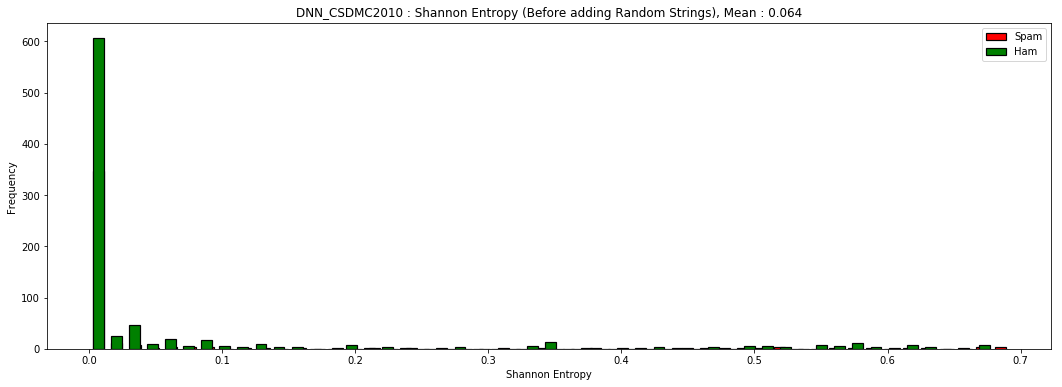

In [57]:
visualise_entropies(dataset, test_x_dense, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
DNN_CSDMC2010
********************************************************************************
Log Loss :  0.9210434442262098
ROC AUC :  0.9958600051749935
Accuracy :  0.9733333333333334
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       863
         1.0       0.96      0.95      0.96       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.97      0.97      1275
weighted avg       0.97      0.97      0.97      1275



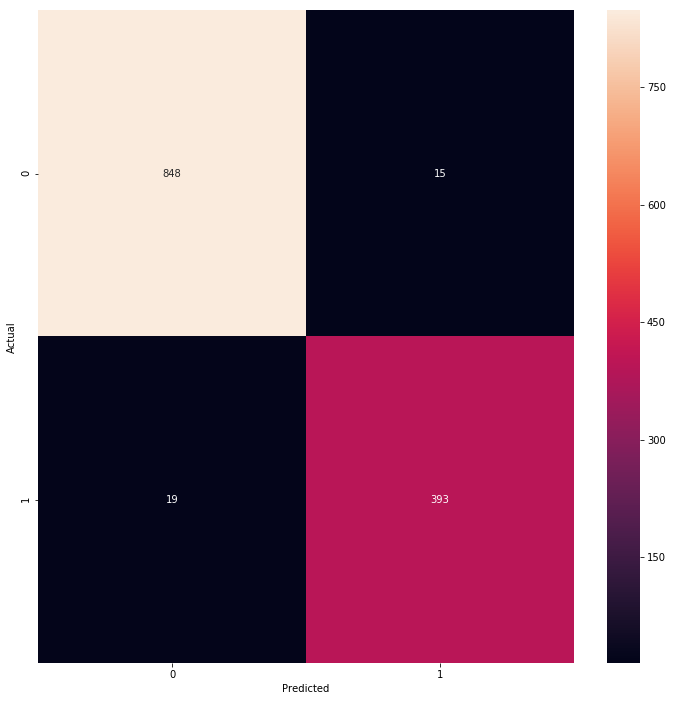

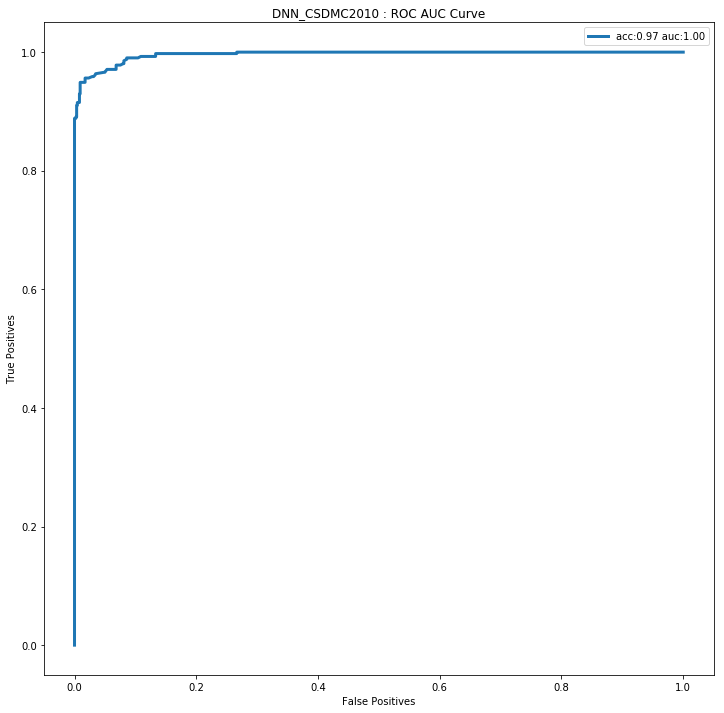

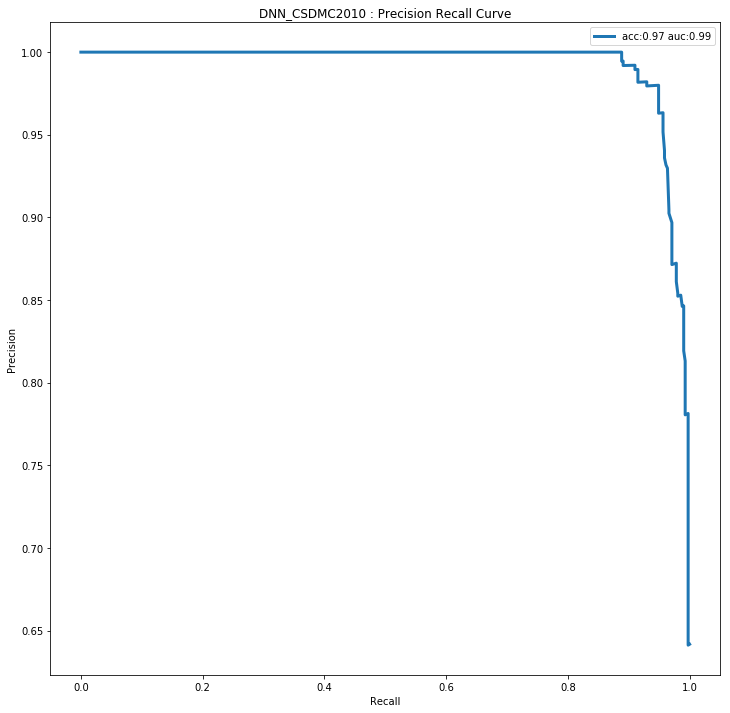

In [58]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_dense, y_test)

## Adding Meaningful Strings to Test Data

In [59]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.07348111
Mean Relative Entropy :  0.08594492671258722
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
74     0.634     1.109     1.0       0       0.670       0.330
97     0.585     1.303     1.0       0       0.728       0.272
137    0.523     1.527     1.0       0       0.783       0.217
144    0.482     1.675     1.0       0       0.813       0.187
151    0.630     1.128     1.0       0       0.676       0.324
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1128    0.045     4.859     0.0       1       0.008       0.992
1140    0.647     1.054     0.0       1       0.349       0.651
1141    0.667     0.954     0.0       1       0.385       0.615
1188    0.024     5.604     0.0       1       0.004       0.996
1197    0.693     0.728   

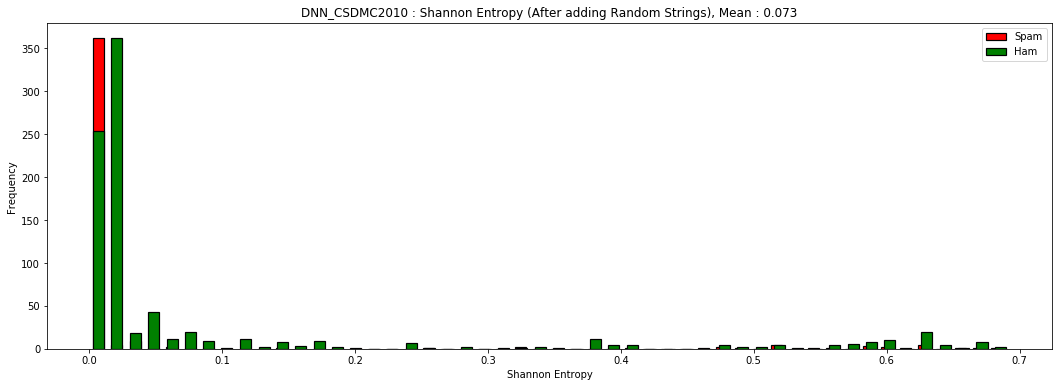

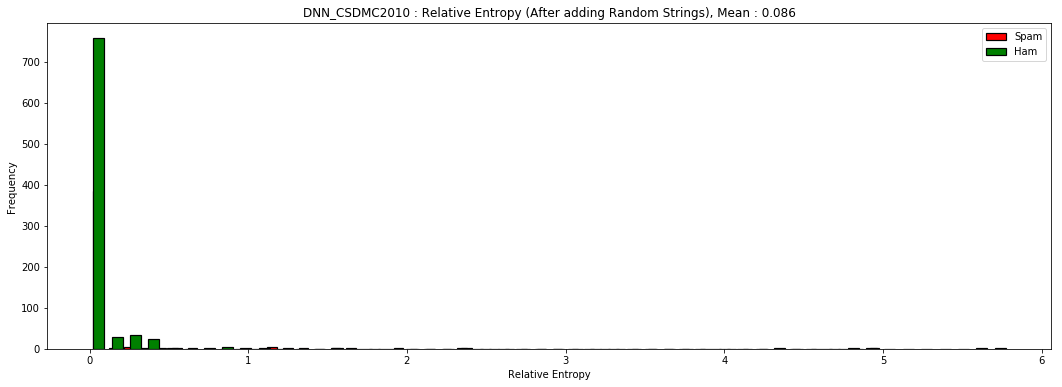

In [60]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_CSDMC2010
********************************************************************************
Log Loss :  0.9481351891553323
ROC AUC :  0.9962101609872988
Accuracy :  0.9725490196078431
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       863
         1.0       0.95      0.96      0.96       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.97      0.97      1275
weighted avg       0.97      0.97      0.97      1275



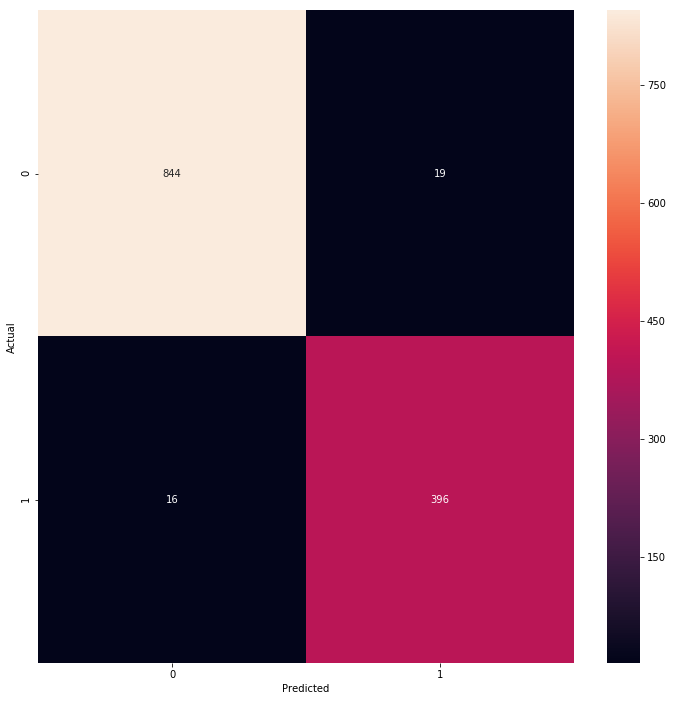

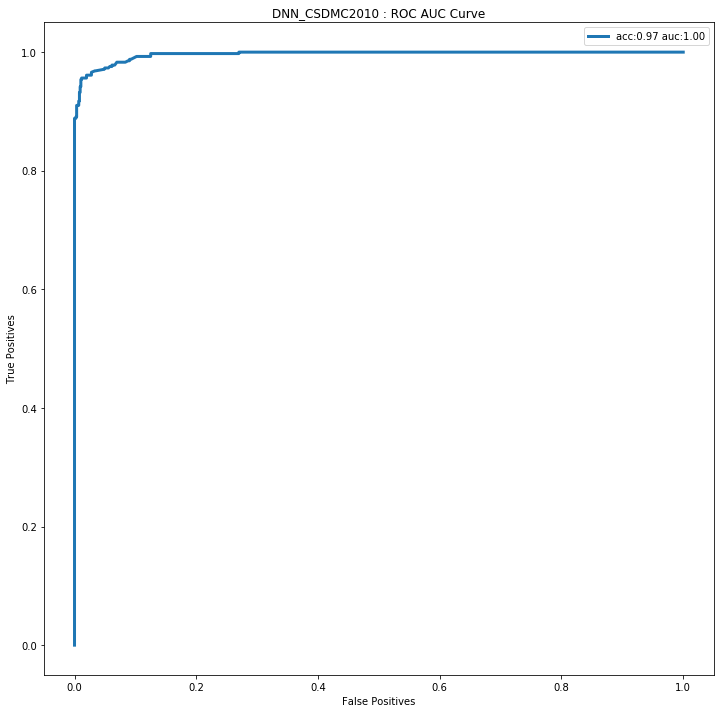

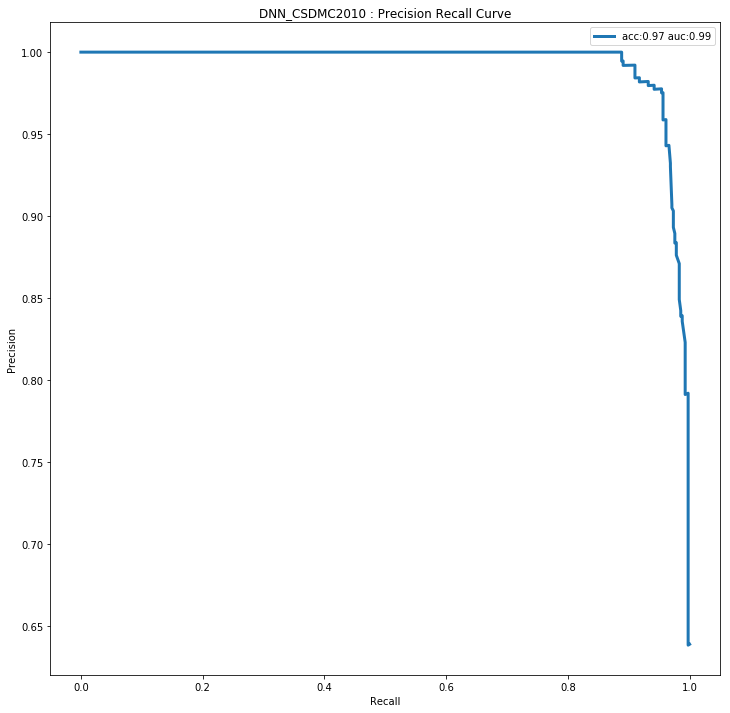

In [61]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [62]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
test_x_with_random_strings_dense = tok.texts_to_matrix(test_x_with_random_strings,mode='count')

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
DNN_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.6270117
Mean Relative Entropy :  0.9334125533640287
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
0     0.679     0.874     1.0       0       0.583       0.417
3     0.688     0.800     1.0       0       0.551       0.449
14    0.679     0.874     1.0       0       0.583       0.417
16    0.679     0.874     1.0       0       0.583       0.417
18    0.679     0.874     1.0       0       0.583       0.417
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1270    0.622     1.160     0.0       1       0.314       0.686
1271    0.668     0.946     0.0       1       0.388       0.612
1272    0.693     0.697     0.0       1       0.498       0.502
1273    0.622     1.160     0.0       1       0.314       0.686
1274    0.435     1.850     0.0   

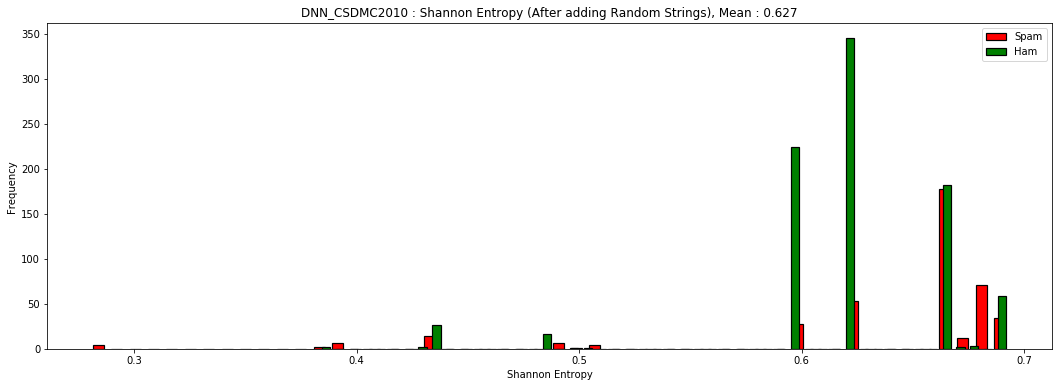

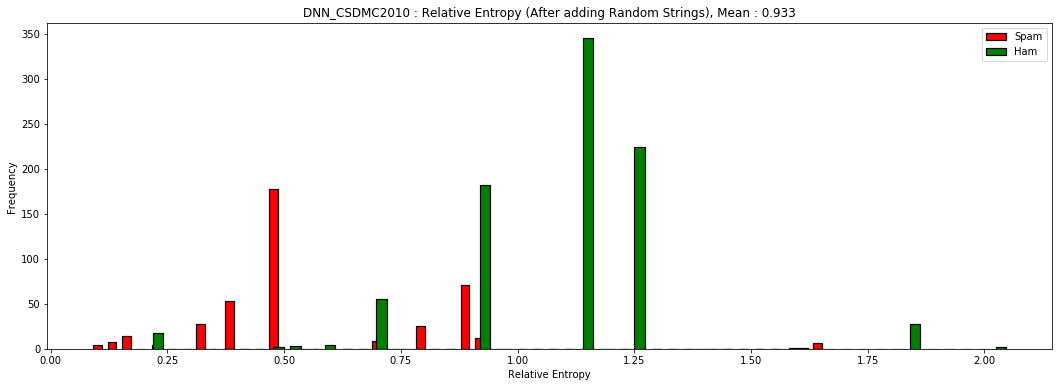

In [63]:
visualise_entropies(dataset, test_x_with_random_strings_dense, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
DNN_CSDMC2010
********************************************************************************
Log Loss :  25.78947795372866
ROC AUC :  0.2857862052672434
Accuracy :  0.25333333333333335
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.18      0.03      0.05       863
         1.0       0.26      0.72      0.38       412

   micro avg       0.25      0.25      0.25      1275
   macro avg       0.22      0.38      0.22      1275
weighted avg       0.21      0.25      0.16      1275



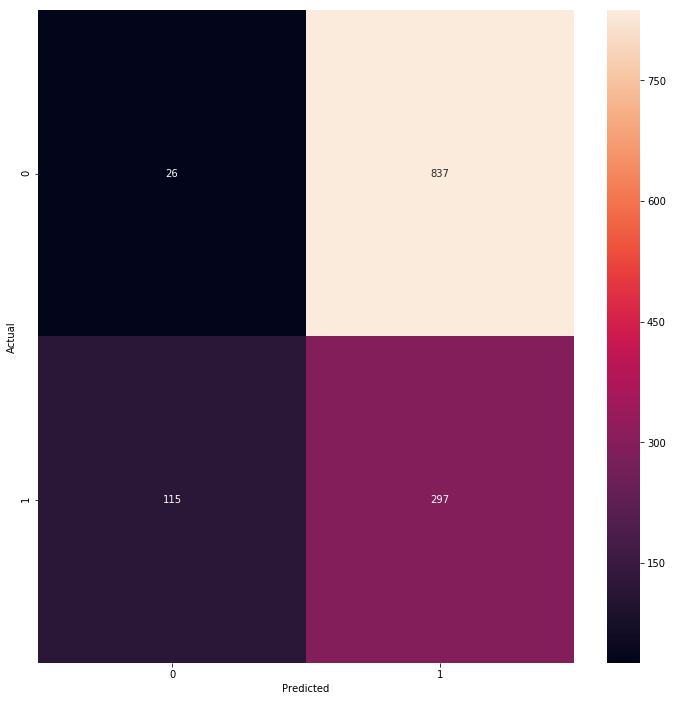

In [64]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_dense, y_test)

## 5. Embeddings with CNNs
### Initial Data Cleaning

In [65]:
grids = {}
max_len = 100
cnn_train_seq = tok.texts_to_sequences(train_x_cleaned)
cnn_test_seq = tok.texts_to_sequences(test_x_cleaned)
#print(cnn_texts_seq[0])
train_x_cnn = sequence.pad_sequences(cnn_train_seq,maxlen=max_len)
test_x_cnn = sequence.pad_sequences(cnn_test_seq,maxlen=max_len)
#print(train_x_cnn[0])
print(train_x_cnn.shape)

(3052, 100)


## CNN Version 1
### Training Model

In [66]:
cnn_v1 = get_cnn_model_v1(max_len)
cnn_v1.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V1_'+dataset] = copy.deepcopy(cnn_v1)

gc.enable(); gc.collect();

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2441 samples, validate on 611 samples
Epoch 1/10
2441/2441 [==============================] - 1s 440us/step - loss: 0.4100 - acc: 0.7902 - binary_accuracy: 0.7902 - val_loss: 0.0794 - val_acc: 0.9574 - val_binary_accuracy: 0.9574
Epoch 2/10
2441/2441 [==============================] - 0s 171us/step - loss: 0.0826 - acc: 0.9746 - binary_accuracy: 0.9746 - val_loss: 0.1068 - val_acc: 0.9722 - val_binary_accuracy: 0.9722
Epoch 3/10
2441/2441 [==============================] - 0s 167us/step - loss: 0.0543 - acc: 0.9828 - binary_accuracy: 0.9828 - val_loss: 0.0614 - val_acc: 0.9787 - val_binary_accuracy: 0.9787
Epoch 4/10
2441/2441 [==============================] - 0s 166us/step - loss: 0.0448 - acc: 0.9853 - binary_accuracy: 0.9853 - val_loss: 0.0489 - val_acc: 0.9853 - val_binary_accuracy: 0.9853
Epoch 5/10
2441/2441 [==============================] - 0s 175us/step - loss: 0.0483 - acc: 0.9865 - binary

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V1_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.05463281
Mean Relative Entropy :  0.08108895977889893
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2      0.621     1.164     1.0       0       0.688       0.312
74     0.383     2.055     1.0       0       0.872       0.128
97     0.486     1.660     1.0       0       0.810       0.190
101    0.218     2.868     1.0       0       0.943       0.057
107    0.455     1.774     1.0       0       0.830       0.170
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1078    0.472     1.714     0.0       1       0.180       0.820
1128    0.293     2.455     0.0       1       0.086       0.914
1129    0.691     0.765     0.0       1       0.465       0.535
1188    0.353     2.180     0.0       1       0.113       0.887
1269    0.692     0.751

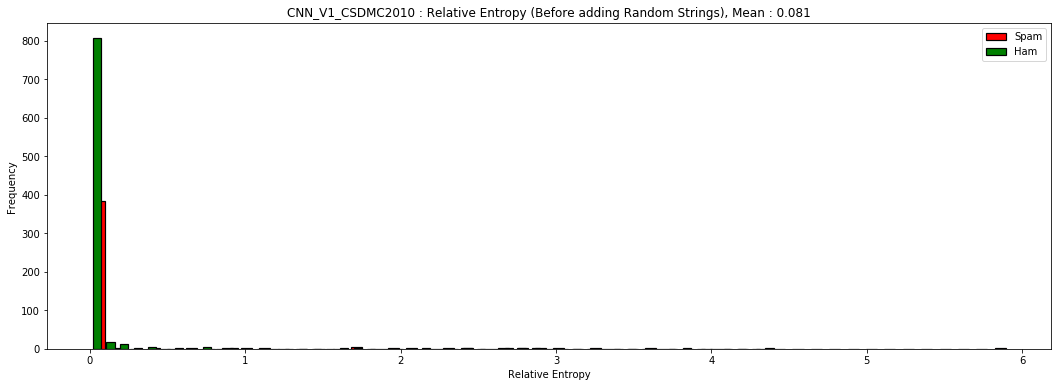

In [67]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V1_CSDMC2010
********************************************************************************
Log Loss :  1.0294003897788704
ROC AUC :  0.9952426621966723
Accuracy :  0.9701960784313726
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       863
         1.0       0.96      0.94      0.95       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.96      0.97      1275
weighted avg       0.97      0.97      0.97      1275



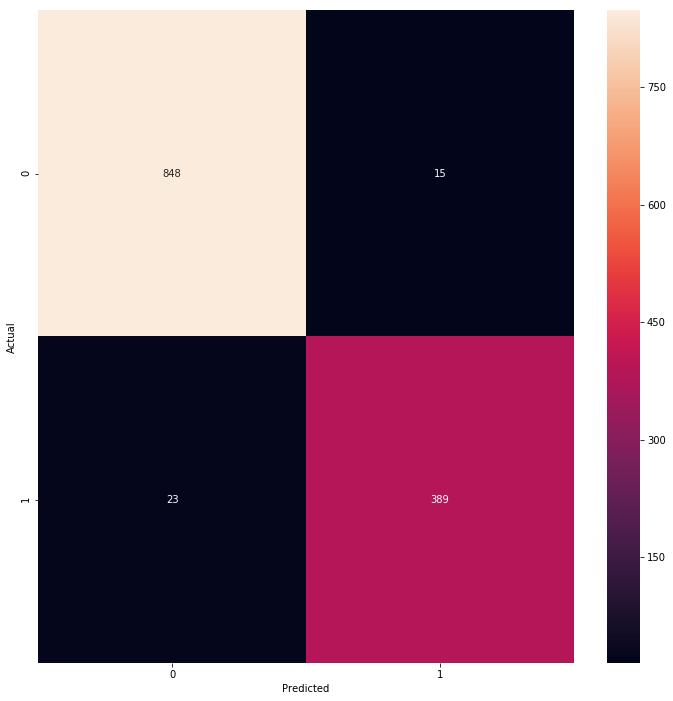

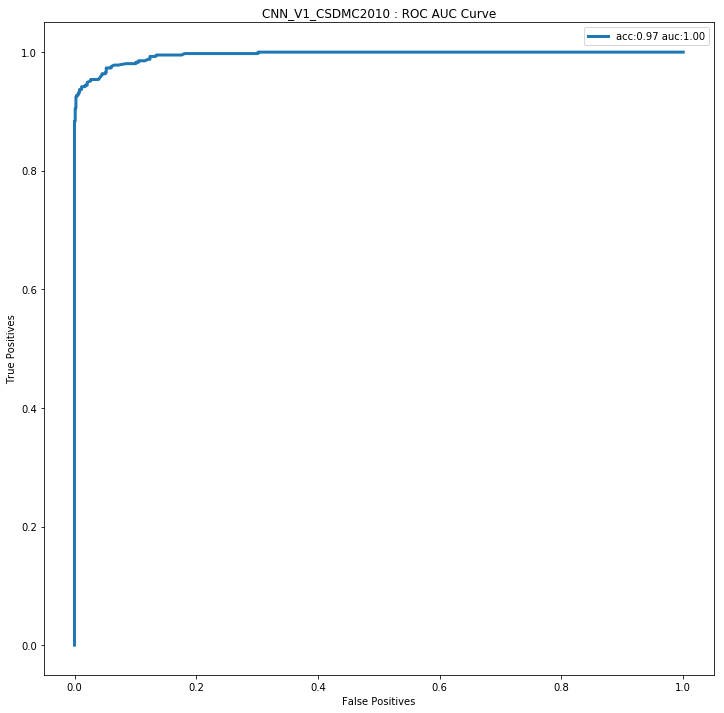

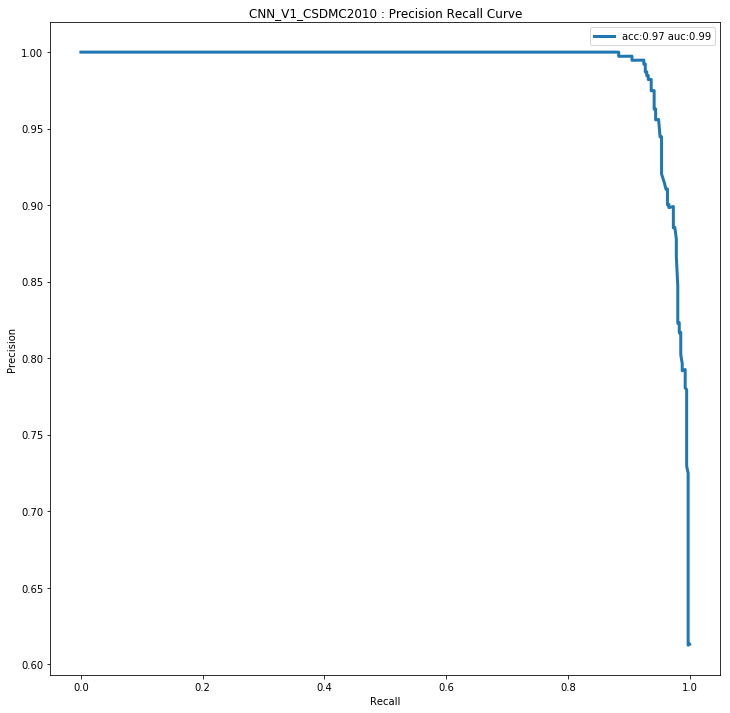

In [68]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [69]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.056970324
Mean Relative Entropy :  0.08068203849022342
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2      0.624     1.151     1.0       0       0.684       0.316
74     0.414     1.930     1.0       0       0.855       0.145
97     0.488     1.655     1.0       0       0.809       0.191
101    0.214     2.892     1.0       0       0.945       0.055
107    0.520     1.537     1.0       0       0.785       0.215
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1078    0.390     2.025     0.0       1       0.132       0.868
1128    0.314     2.355     0.0       1       0.095       0.905
1129    0.690     0.771     0.0       1       0.463       0.537
1188    0.352     2.183     0.0       1       0.113       0.887
1269    0.645     1.06

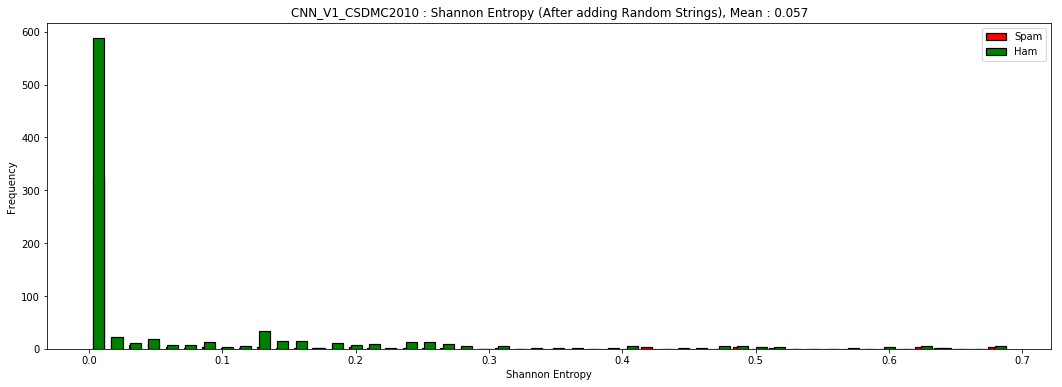

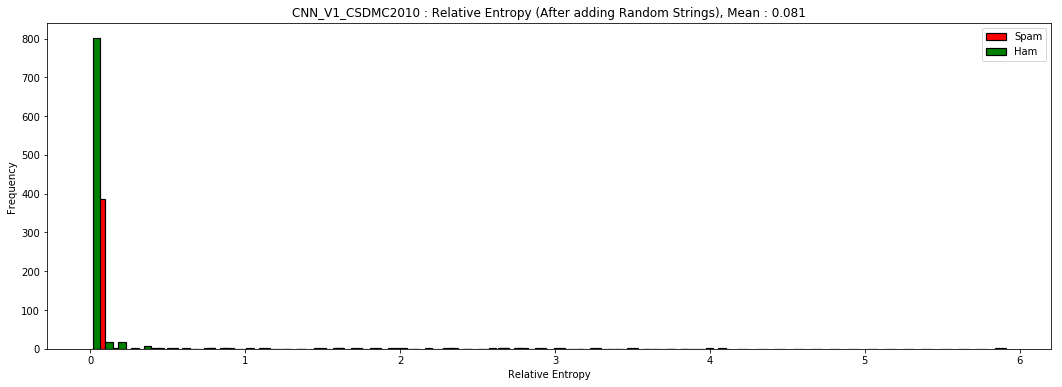

In [70]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_CSDMC2010
********************************************************************************
Log Loss :  1.0294003897788704
ROC AUC :  0.9952089122388597
Accuracy :  0.9701960784313726
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       863
         1.0       0.96      0.94      0.95       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.97      0.96      0.97      1275
weighted avg       0.97      0.97      0.97      1275



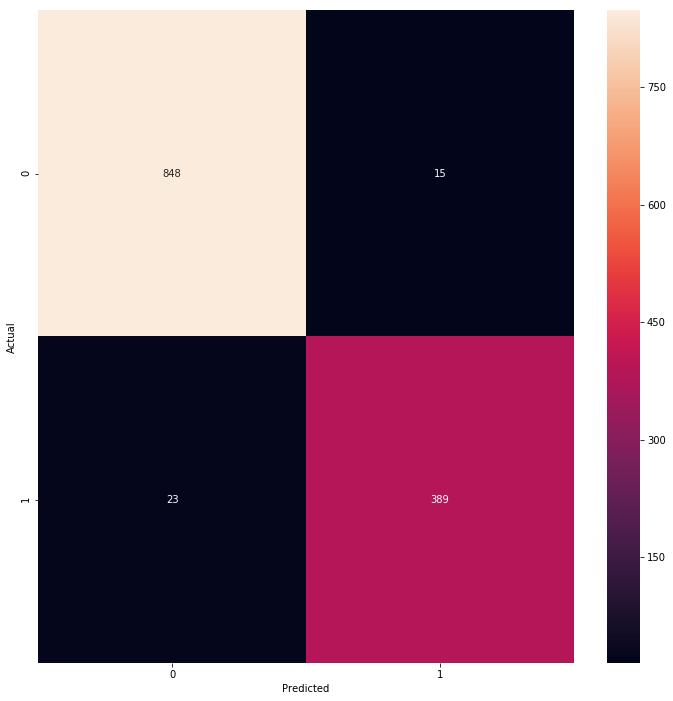

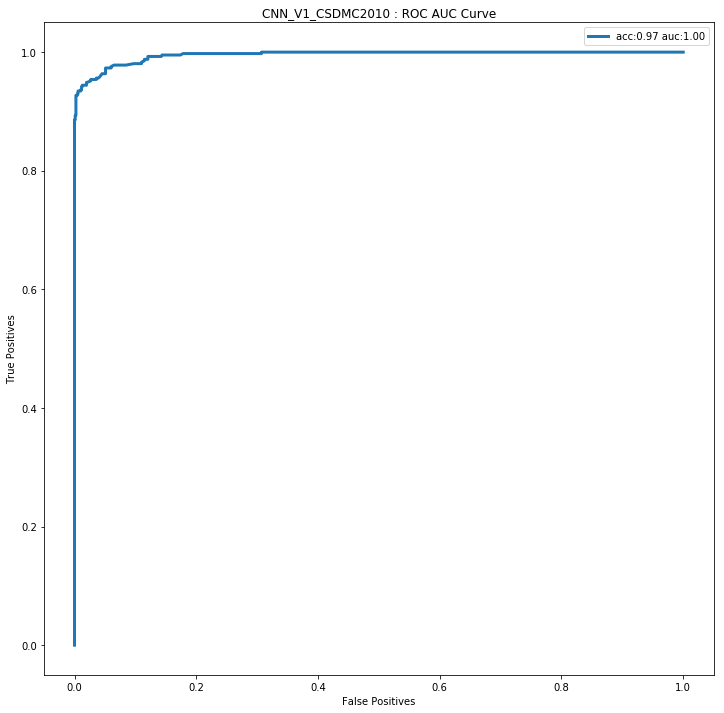

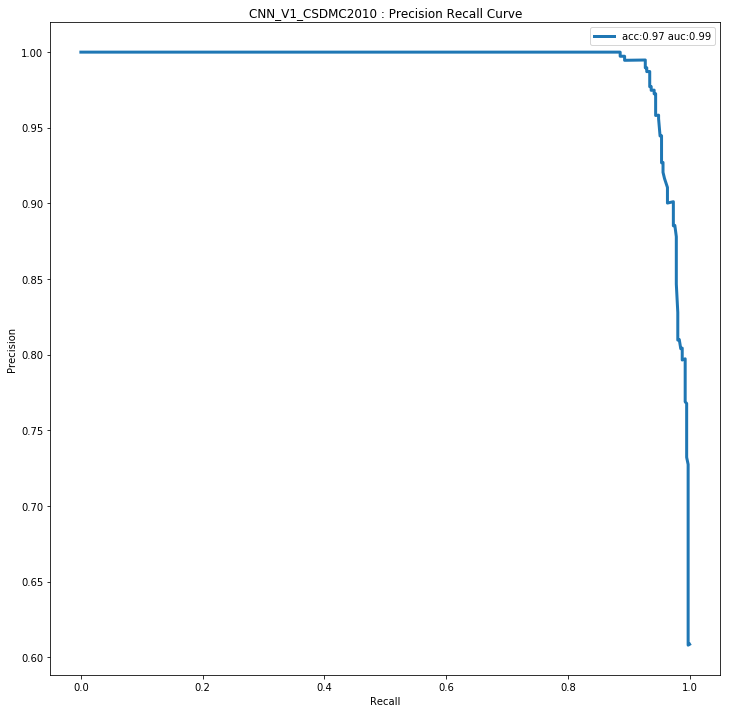

In [71]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [72]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V1_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.6425764
Mean Relative Entropy :  0.889258427453899
Head 5 : 
    Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
0     0.681     0.862     1.0       0       0.578       0.422
14    0.681     0.862     1.0       0       0.578       0.422
16    0.681     0.862     1.0       0       0.578       0.422
18    0.681     0.862     1.0       0       0.578       0.422
24    0.681     0.862     1.0       0       0.578       0.422
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1270    0.581     1.316     0.0       1       0.268       0.732
1271    0.667     0.951     0.0       1       0.386       0.614
1272    0.674     0.911     0.0       1       0.402       0.598
1273    0.581     1.316     0.0       1       0.268       0.732
1274    0.633     1.114     0.0 

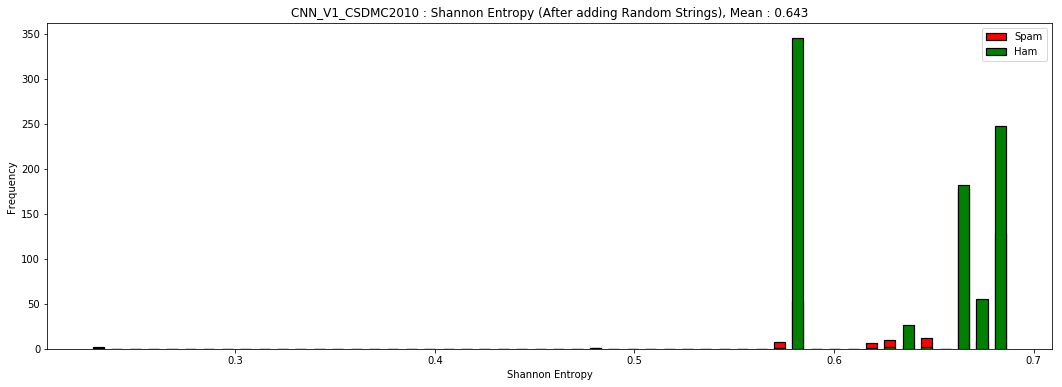

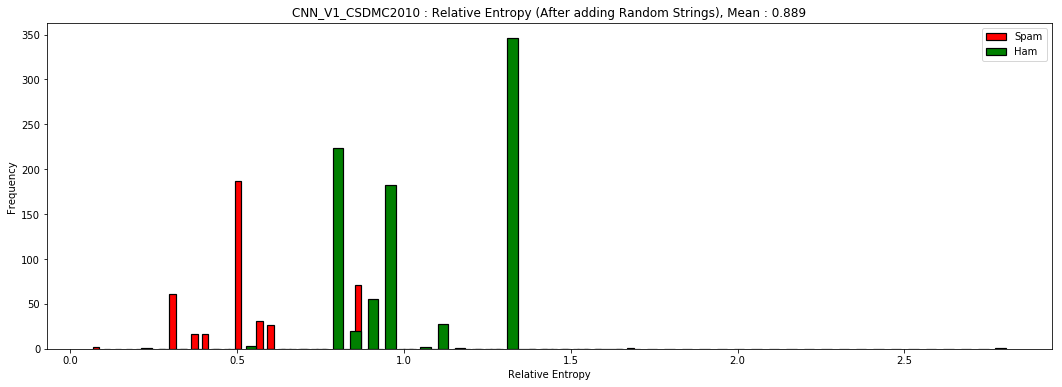

In [73]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V1_CSDMC2010
********************************************************************************
Log Loss :  25.220617786552456
ROC AUC :  0.40572933658832927
Accuracy :  0.2698039215686274
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.05      0.00      0.01       863
         1.0       0.28      0.83      0.42       412

   micro avg       0.27      0.27      0.27      1275
   macro avg       0.17      0.41      0.22      1275
weighted avg       0.13      0.27      0.14      1275



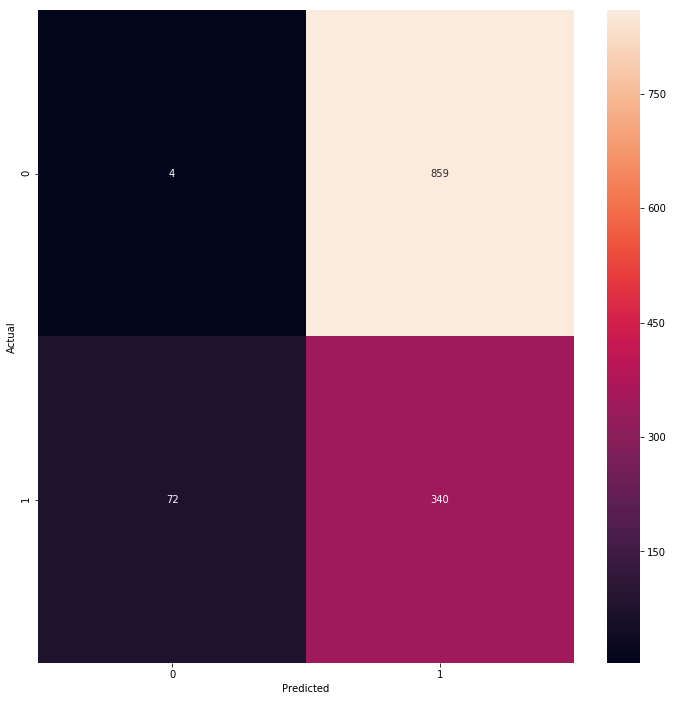

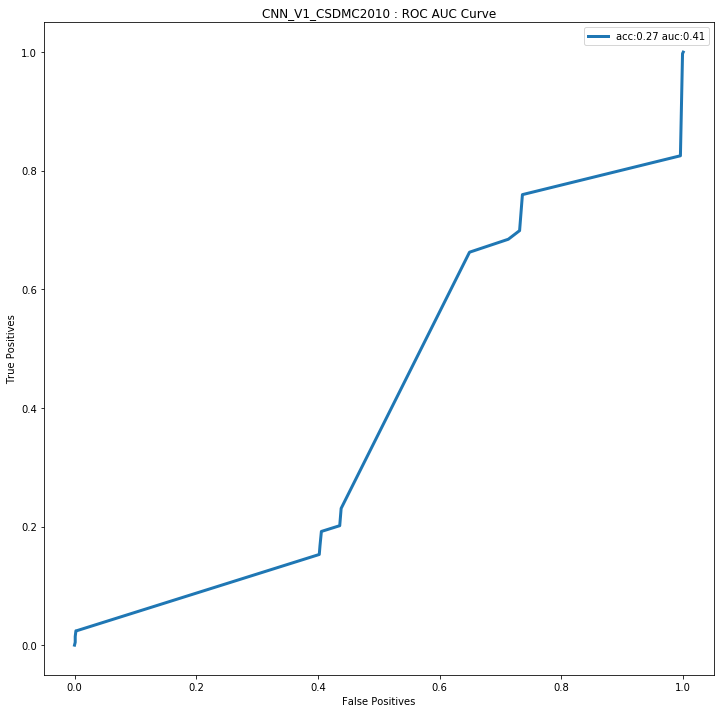

In [74]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## CNN Version 2
### Training Model

In [75]:
grids = {}
cnn_v2 = get_cnn_model_v2(max_len)
cnn_v2.fit(train_x_cnn,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

grids['CNN_V2_'+dataset] = copy.deepcopy(cnn_v2)

gc.enable(); gc.collect();

Train on 2441 samples, validate on 611 samples
Epoch 1/10
2441/2441 [==============================] - 1s 510us/step - loss: 0.3384 - acc: 0.8275 - binary_accuracy: 0.8275 - val_loss: 0.1101 - val_acc: 0.9525 - val_binary_accuracy: 0.9525
Epoch 2/10
2441/2441 [==============================] - 0s 174us/step - loss: 0.0838 - acc: 0.9738 - binary_accuracy: 0.9738 - val_loss: 0.0467 - val_acc: 0.9820 - val_binary_accuracy: 0.9820
Epoch 3/10
2441/2441 [==============================] - 0s 173us/step - loss: 0.0553 - acc: 0.9807 - binary_accuracy: 0.9807 - val_loss: 0.0609 - val_acc: 0.9804 - val_binary_accuracy: 0.9804
Epoch 4/10
2441/2441 [==============================] - 0s 164us/step - loss: 0.0441 - acc: 0.9865 - binary_accuracy: 0.9865 - val_loss: 0.0531 - val_acc: 0.9820 - val_binary_accuracy: 0.9820
Epoch 5/10
2441/2441 [==============================] - 0s 168us/step - loss: 0.0403 - acc: 0.9885 - binary_accuracy: 0.9885 - val_loss: 0.0760 - val_acc: 0.9771 - val_binary_accuracy: 

## Visualise Shannon and Relative entropies for various models

********************************************************************************
CNN_V2_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.0628999
Mean Relative Entropy :  0.07706432094366131
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2      0.421     1.902     1.0       0       0.851       0.149
74     0.633     1.113     1.0       0       0.672       0.328
97     0.634     1.109     1.0       0       0.670       0.330
101    0.548     1.438     1.0       0       0.763       0.237
107    0.689     0.786     1.0       0       0.544       0.456
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1078    0.401     1.983     0.0       1       0.138       0.862
1129    0.682     0.856     0.0       1       0.425       0.575
1168    0.689     0.790     0.0       1       0.454       0.546
1188    0.328     2.291     0.0       1       0.101       0.899
1269    0.561     1.391 

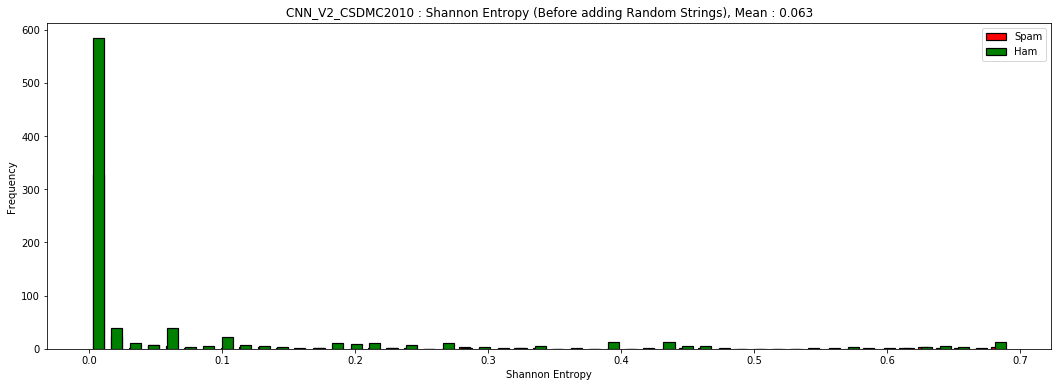

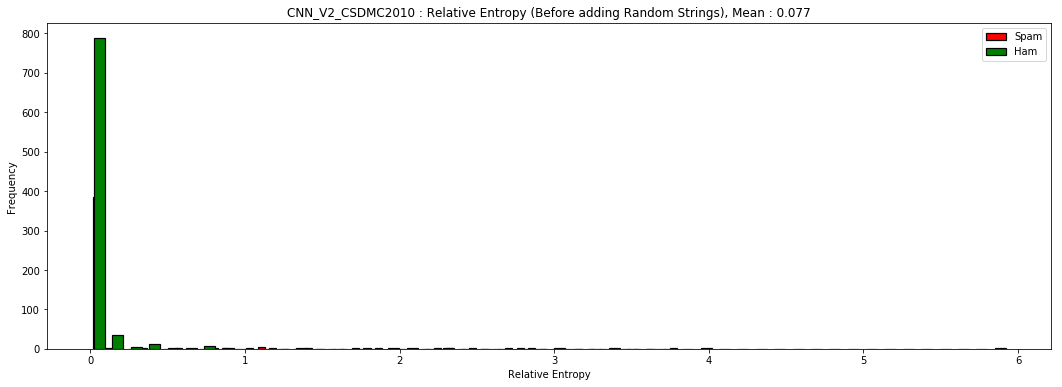

In [76]:
visualise_entropies(dataset, test_x_cnn, y_test,'Before')

## Calculating Various Metrics and Displaying Results

********************************************************************************
CNN_V2_CSDMC2010
********************************************************************************
Log Loss :  1.110671234619563
ROC AUC :  0.9959514113107358
Accuracy :  0.967843137254902
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       863
         1.0       0.95      0.95      0.95       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.96      0.96      0.96      1275
weighted avg       0.97      0.97      0.97      1275



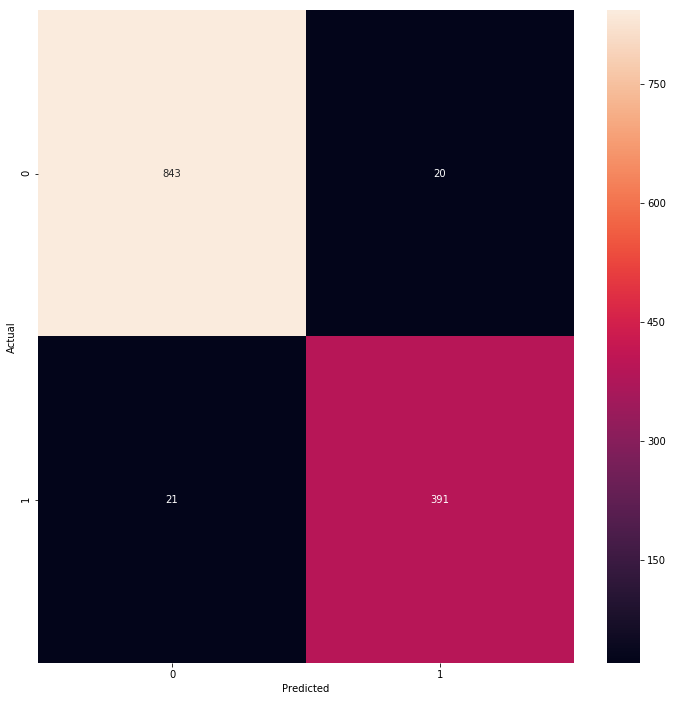

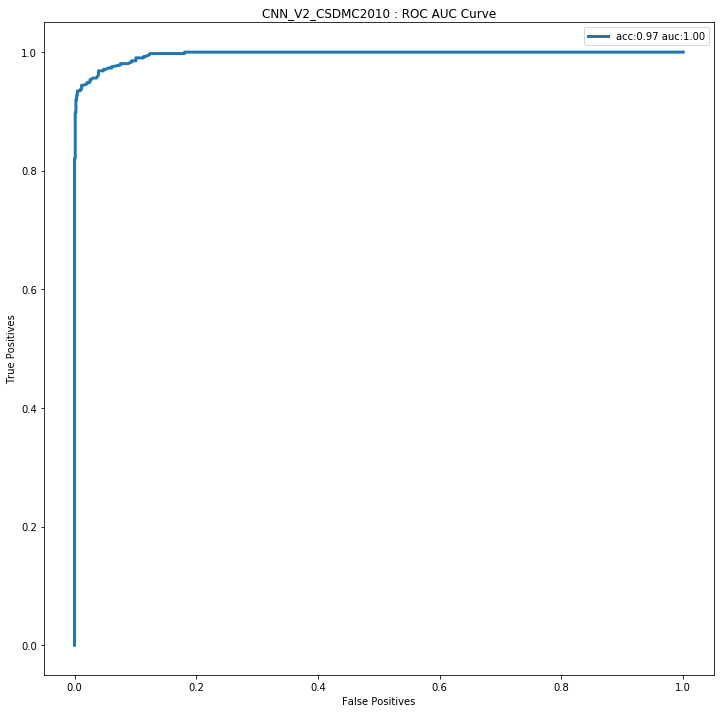

In [77]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_cnn, y_test)

## Adding Meaningful Strings to Test Data

In [78]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.076186344
Mean Relative Entropy :  0.0828152824727914
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
2      0.474     1.706     1.0       0       0.818       0.182
74     0.636     1.099     1.0       0       0.667       0.333
97     0.656     1.008     1.0       0       0.635       0.365
101    0.567     1.371     1.0       0       0.746       0.254
137    0.513     1.564     1.0       0       0.791       0.209
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1078    0.308     2.380     0.0       1       0.093       0.907
1129    0.671     0.928     0.0       1       0.395       0.605
1168    0.686     0.820     0.0       1       0.440       0.560
1188    0.307     2.385     0.0       1       0.092       0.908
1269    0.433     1.856

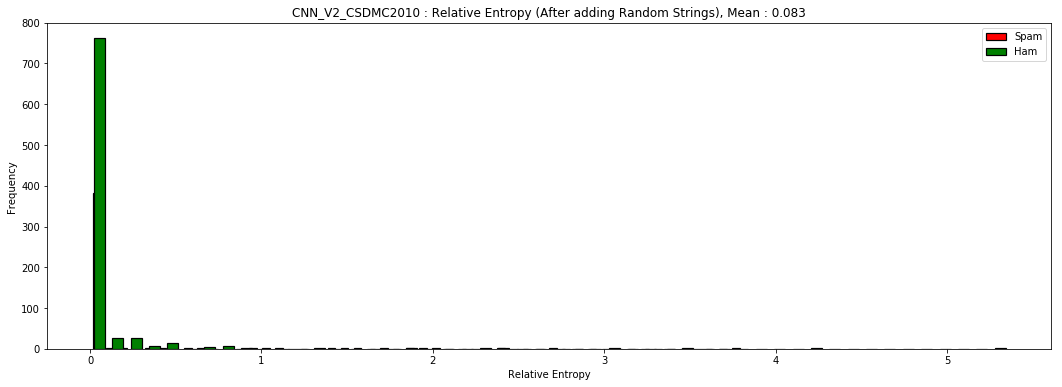

In [79]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_CSDMC2010
********************************************************************************
Log Loss :  1.0835832525018765
ROC AUC :  0.9954859431425711
Accuracy :  0.9686274509803922
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       863
         1.0       0.95      0.96      0.95       412

   micro avg       0.97      0.97      0.97      1275
   macro avg       0.96      0.97      0.96      1275
weighted avg       0.97      0.97      0.97      1275



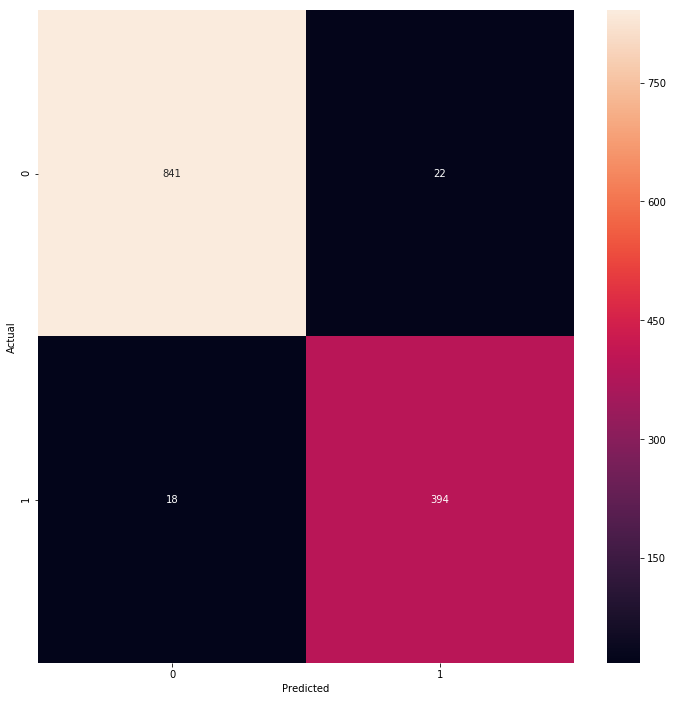

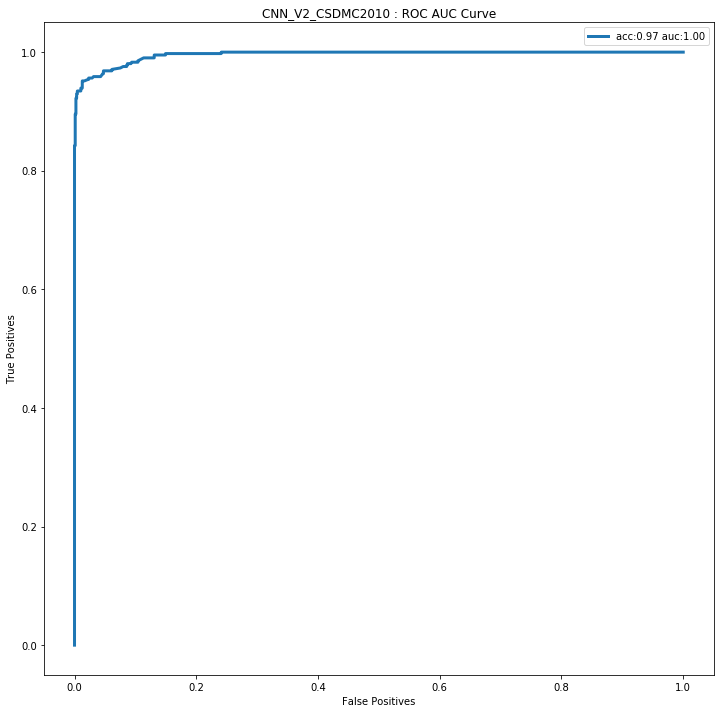

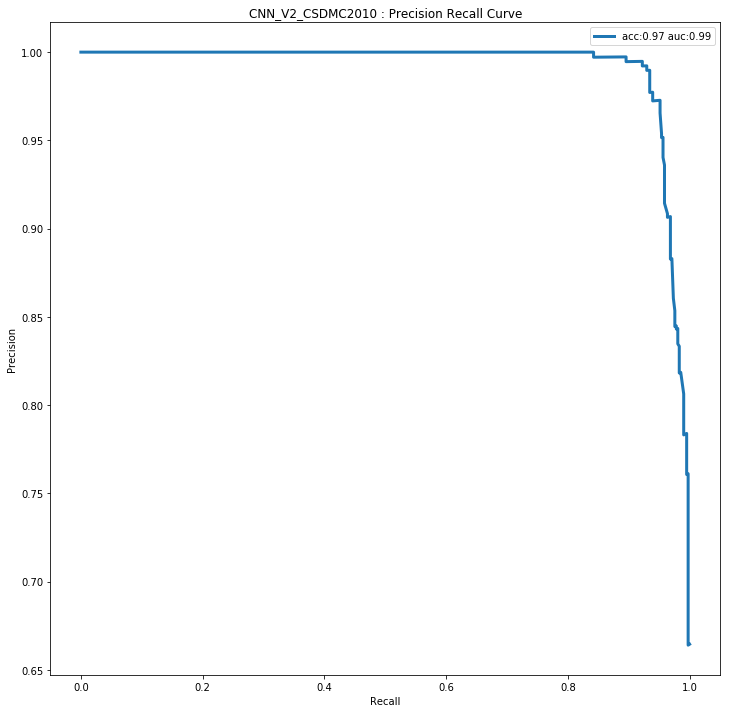

In [80]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)

## Adding Meaningful Scrambled Strings to Test Data

In [81]:
## Adding meaningful strings to test dataset to confuse classifier
test_x_with_random_strings = add_meaningfull_strings_scrambled(test_x_cleaned, string_size)
cnn_test_seq_rand = tok.texts_to_sequences(test_x_with_random_strings)
test_x_with_random_strings_cnn = sequence.pad_sequences(cnn_test_seq_rand,maxlen=max_len)

## Visualise Shannon and Relative entropies for various models (After Adding Strings)

********************************************************************************
CNN_V2_CSDMC2010
********************************************************************************
Mean Shannon Entropy :  0.52244323
Mean Relative Entropy :  1.2021814739659709
Head 5 : 
     Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
96     0.369      2.11     1.0       0       0.879       0.121
140    0.369      2.11     1.0       0       0.879       0.121
238    0.369      2.11     1.0       0       0.879       0.121
291    0.369      2.11     1.0       0       0.879       0.121
310    0.369      2.11     1.0       0       0.879       0.121
Tail 5 : 
      Shannon  Relative  Y True  Y Pred  Y Preds(0)  Y Preds(1)
1270    0.314     2.353     0.0       1       0.095       0.905
1271    0.642     1.077     0.0       1       0.341       0.659
1272    0.676     0.898     0.0       1       0.407       0.593
1273    0.314     2.353     0.0       1       0.095       0.905
1274    0.469     1.723 

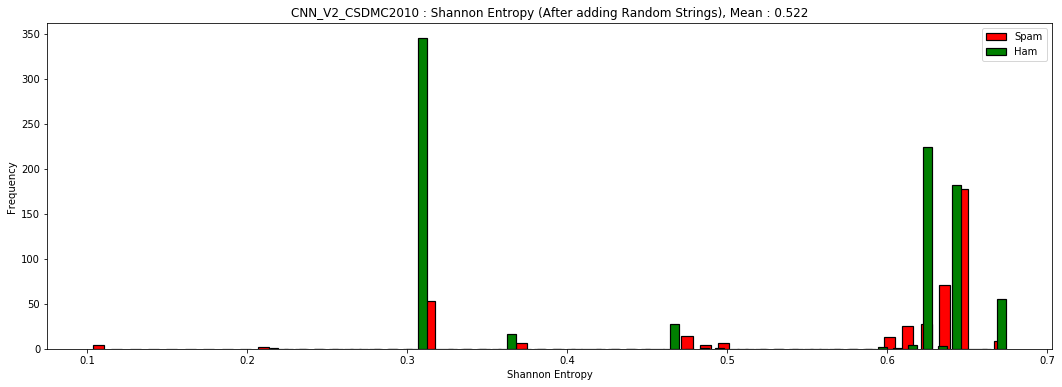

In [82]:
visualise_entropies(dataset, test_x_with_random_strings_cnn, y_test,'After')

## Calculating Various Metrics and Displaying Results (After Adding Strings)

********************************************************************************
CNN_V2_CSDMC2010
********************************************************************************
Log Loss :  23.107649195517457
ROC AUC :  0.36290064012419987
Accuracy :  0.33098039215686276
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.71      0.02      0.04       863
         1.0       0.32      0.98      0.49       412

   micro avg       0.33      0.33      0.33      1275
   macro avg       0.52      0.50      0.26      1275
weighted avg       0.58      0.33      0.18      1275



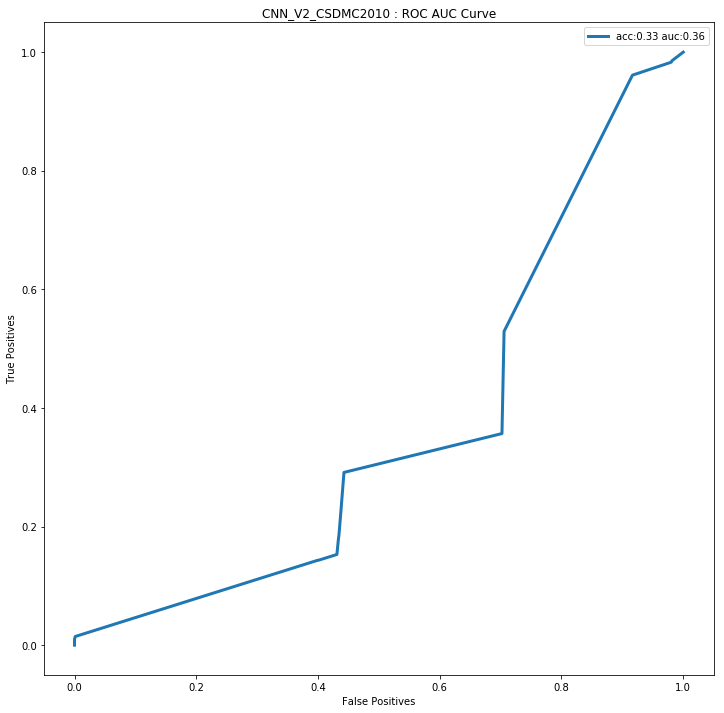

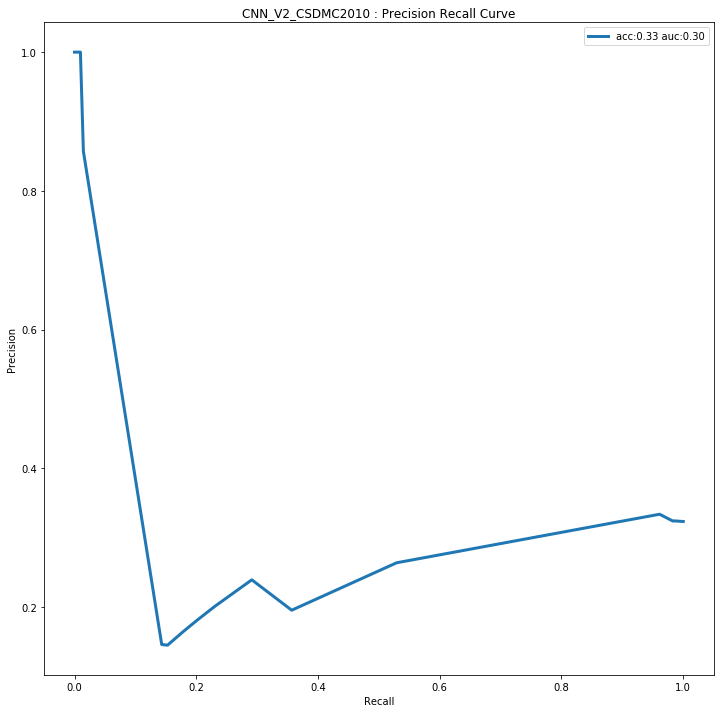

In [83]:
calculate_evaluation_metrics_and_display_metrics(dataset, test_x_with_random_strings_cnn, y_test)